In [1]:
import pandas as pd
import numpy as np
#import panel as pn

from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders import TargetEncoder, MEstimateEncoder, CatBoostEncoder
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
#from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv('new_result_requetes.csv')

In [3]:
data["avatar_id"]=pd.Categorical(data["avatar_id"],ordered=False)
data["city"]=pd.Categorical(data["city"],ordered=False)
data["language"]=pd.Categorical(data["language"],ordered=False)
data["mobile"]=pd.Categorical(data["mobile"],ordered=False)
data["hotel_id"]=pd.Categorical(data["hotel_id"],ordered=False)
data["group"]=pd.Categorical(data["group"],ordered=False)
data["brand"]=pd.Categorical(data["brand"],ordered=False)
data["parking"]=pd.Categorical(data["parking"],ordered=False)
data["pool"]=pd.Categorical(data["pool"],ordered=False)
data["children_policy"]=pd.Categorical(data["children_policy"],ordered=False)
data["nb_requete"]=pd.Categorical(data["nb_requete"],ordered=False)

data["price"]=pd.DataFrame(data["price"], dtype=float)

In [4]:
data = data.drop_duplicates(subset =['nb_requete','hotel_id','price','stock','city','date',
                                         'language','mobile','group','brand','parking',
                                         'pool','children_policy'])

In [5]:
test = pd.read_csv('defi-ia-2023/test_set3.csv')

In [6]:
test['target'] = 0
data['target'] = 1
target = 'target'

In [7]:
test.columns

Index(['nb_requete', 'index', 'order_requests', 'city', 'date', 'language',
       'mobile', 'avatar_id', 'hotel_id', 'stock', 'group', 'brand', 'parking',
       'pool', 'children_policy', 'target'],
      dtype='object')

In [8]:
cat_cols = ['hotel_id','city','language', 'mobile','group', 'brand', 'parking','pool', 'children_policy']
numeric_cols = ['stock','date']

In [30]:
#cat_cols = ['city','language', 'mobile', 'group','brand']
#numeric_cols = ['date','stock']

In [9]:
def create_adversarial_data(df_train, df_test, cols, N_val=2500):
    df_master = pd.concat([df_train[cols], df_test[cols]], axis=0)
    adversarial_val = df_master.sample(N_val, replace=False)
    adversarial_train = df_master[~df_master.index.isin(adversarial_val.index)]
    return adversarial_train, adversarial_val

features = cat_cols + numeric_cols 
all_cols = features + [target]
adversarial_train, adversarial_test = create_adversarial_data(data,#.drop(columns=['price','order_requests','avatar_id','nb_requete']),
                                                              test,#.drop(columns=['order_requests','index','avatar_id','nb_requete']),
                                                              all_cols)

In [10]:
adversarial_train.shape

(549853, 12)

In [35]:
from catboost import Pool, CatBoostClassifier

L = 0
while (L < 60000) : #60000 <=> taille du nouveau dataset # à ajuster
    
    adversarial_train, adversarial_test = create_adversarial_data(data.sample(10000),test,all_cols)

    train_data = Pool(    
        data=adversarial_train[features],
        label=adversarial_train[target],
        cat_features=cat_cols )

    holdout_data = Pool(
        data=adversarial_test[features],
        label=adversarial_test[target],
        cat_features=cat_cols)

    params = {
        'iterations': 100,
        'eval_metric': 'AUC',
        'od_type': 'Iter',
        'od_wait': 50,
    }

    params2 = dict(params)
    params2.update({"ignored_features": ['hotel_id','stock','date']})#,'brand','group']})
    model2 = CatBoostClassifier(**params2)
    _ = model2.fit(train_data,eval_set=holdout_data)

    p = model2.predict(holdout_data)
    adversarial_test['predicted'] = p
    test_t1p0 = adversarial_test[adversarial_test['target'] == 1 ]
    test_t1p0 = test_t1p0[test_t1p0['predicted'] == 0]

    results = pd.read_csv('results_to_keep2.csv')
    results_kept = pd.concat([test_t1p0,results], axis = 0 )
    new_data = results_kept.drop_duplicates(subset =['hotel_id', 'city', 'language', 'mobile', 'group', 'brand', 'parking',
                                                     'pool', 'children_policy', 'stock', 'date', 'target', 'predicted'])
    L = len(new_data)
    new_data.to_csv('results_to_keep2.csv', index = False)

Learning rate set to 0.165922
0:	test: 0.6394097	best: 0.6394097 (0)	total: 25ms	remaining: 2.47s
1:	test: 0.6400772	best: 0.6400772 (1)	total: 44.8ms	remaining: 2.19s
2:	test: 0.6378198	best: 0.6400772 (1)	total: 62.3ms	remaining: 2.02s
3:	test: 0.6683428	best: 0.6683428 (3)	total: 86.3ms	remaining: 2.07s
4:	test: 0.6690562	best: 0.6690562 (4)	total: 110ms	remaining: 2.09s
5:	test: 0.6719450	best: 0.6719450 (5)	total: 127ms	remaining: 1.99s
6:	test: 0.6746491	best: 0.6746491 (6)	total: 150ms	remaining: 1.99s
7:	test: 0.6814081	best: 0.6814081 (7)	total: 174ms	remaining: 2s
8:	test: 0.6938280	best: 0.6938280 (8)	total: 213ms	remaining: 2.15s
9:	test: 0.7082925	best: 0.7082925 (9)	total: 244ms	remaining: 2.2s
10:	test: 0.7133050	best: 0.7133050 (10)	total: 267ms	remaining: 2.16s
11:	test: 0.7273279	best: 0.7273279 (11)	total: 290ms	remaining: 2.13s
12:	test: 0.7298634	best: 0.7298634 (12)	total: 314ms	remaining: 2.1s
13:	test: 0.7318508	best: 0.7318508 (13)	total: 336ms	remaining: 2.07s

15:	test: 0.7598497	best: 0.7602879 (14)	total: 433ms	remaining: 2.27s
16:	test: 0.7618104	best: 0.7618104 (16)	total: 457ms	remaining: 2.23s
17:	test: 0.7631558	best: 0.7631558 (17)	total: 482ms	remaining: 2.19s
18:	test: 0.7629413	best: 0.7631558 (17)	total: 505ms	remaining: 2.15s
19:	test: 0.7668221	best: 0.7668221 (19)	total: 528ms	remaining: 2.11s
20:	test: 0.7667748	best: 0.7668221 (19)	total: 551ms	remaining: 2.07s
21:	test: 0.7661574	best: 0.7668221 (19)	total: 575ms	remaining: 2.04s
22:	test: 0.7664918	best: 0.7668221 (19)	total: 599ms	remaining: 2s
23:	test: 0.7721135	best: 0.7721135 (23)	total: 622ms	remaining: 1.97s
24:	test: 0.7742601	best: 0.7742601 (24)	total: 646ms	remaining: 1.94s
25:	test: 0.7739044	best: 0.7742601 (24)	total: 672ms	remaining: 1.91s
26:	test: 0.7739800	best: 0.7742601 (24)	total: 683ms	remaining: 1.85s
27:	test: 0.7757203	best: 0.7757203 (27)	total: 707ms	remaining: 1.82s
28:	test: 0.7762071	best: 0.7762071 (28)	total: 730ms	remaining: 1.79s
29:	test:

31:	test: 0.7656557	best: 0.7656557 (31)	total: 845ms	remaining: 1.8s
32:	test: 0.7651587	best: 0.7656557 (31)	total: 875ms	remaining: 1.78s
33:	test: 0.7655308	best: 0.7656557 (31)	total: 899ms	remaining: 1.74s
34:	test: 0.7663555	best: 0.7663555 (34)	total: 922ms	remaining: 1.71s
35:	test: 0.7670801	best: 0.7670801 (35)	total: 944ms	remaining: 1.68s
36:	test: 0.7670566	best: 0.7670801 (35)	total: 969ms	remaining: 1.65s
37:	test: 0.7671157	best: 0.7671157 (37)	total: 991ms	remaining: 1.62s
38:	test: 0.7683510	best: 0.7683510 (38)	total: 1.01s	remaining: 1.59s
39:	test: 0.7698983	best: 0.7698983 (39)	total: 1.04s	remaining: 1.56s
40:	test: 0.7723079	best: 0.7723079 (40)	total: 1.06s	remaining: 1.53s
41:	test: 0.7734408	best: 0.7734408 (41)	total: 1.09s	remaining: 1.5s
42:	test: 0.7745664	best: 0.7745664 (42)	total: 1.11s	remaining: 1.47s
43:	test: 0.7764917	best: 0.7764917 (43)	total: 1.14s	remaining: 1.45s
44:	test: 0.7765253	best: 0.7765253 (44)	total: 1.16s	remaining: 1.42s
45:	test

52:	test: 0.7826706	best: 0.7826706 (52)	total: 1.31s	remaining: 1.16s
53:	test: 0.7855307	best: 0.7855307 (53)	total: 1.34s	remaining: 1.14s
54:	test: 0.7855039	best: 0.7855307 (53)	total: 1.36s	remaining: 1.11s
55:	test: 0.7866258	best: 0.7866258 (55)	total: 1.39s	remaining: 1.09s
56:	test: 0.7864253	best: 0.7866258 (55)	total: 1.41s	remaining: 1.06s
57:	test: 0.7864574	best: 0.7866258 (55)	total: 1.43s	remaining: 1.04s
58:	test: 0.7863864	best: 0.7866258 (55)	total: 1.45s	remaining: 1.01s
59:	test: 0.7863864	best: 0.7866258 (55)	total: 1.48s	remaining: 985ms
60:	test: 0.7864782	best: 0.7866258 (55)	total: 1.5s	remaining: 959ms
61:	test: 0.7864782	best: 0.7866258 (55)	total: 1.51s	remaining: 927ms
62:	test: 0.7913334	best: 0.7913334 (62)	total: 1.54s	remaining: 904ms
63:	test: 0.7913461	best: 0.7913461 (63)	total: 1.57s	remaining: 886ms
64:	test: 0.7943758	best: 0.7943758 (64)	total: 1.61s	remaining: 869ms
65:	test: 0.7944811	best: 0.7944811 (65)	total: 1.65s	remaining: 848ms
66:	tes

75:	test: 0.7789985	best: 0.7789985 (75)	total: 1.88s	remaining: 595ms
76:	test: 0.7790801	best: 0.7790801 (76)	total: 1.91s	remaining: 569ms
77:	test: 0.7789427	best: 0.7790801 (76)	total: 1.93s	remaining: 544ms
78:	test: 0.7792566	best: 0.7792566 (78)	total: 1.95s	remaining: 519ms
79:	test: 0.7801492	best: 0.7801492 (79)	total: 1.98s	remaining: 494ms
80:	test: 0.7803769	best: 0.7803769 (80)	total: 2s	remaining: 469ms
81:	test: 0.7803702	best: 0.7803769 (80)	total: 2.02s	remaining: 443ms
82:	test: 0.7808839	best: 0.7808839 (82)	total: 2.04s	remaining: 418ms
83:	test: 0.7808448	best: 0.7808839 (82)	total: 2.06s	remaining: 393ms
84:	test: 0.7810983	best: 0.7810983 (84)	total: 2.09s	remaining: 368ms
85:	test: 0.7816849	best: 0.7816849 (85)	total: 2.11s	remaining: 344ms
86:	test: 0.7818907	best: 0.7818907 (86)	total: 2.13s	remaining: 319ms
87:	test: 0.7817108	best: 0.7818907 (86)	total: 2.16s	remaining: 294ms
88:	test: 0.7817108	best: 0.7818907 (86)	total: 2.18s	remaining: 269ms
89:	test:

95:	test: 0.7907103	best: 0.7907202 (94)	total: 2.28s	remaining: 95ms
96:	test: 0.7908002	best: 0.7908002 (96)	total: 2.31s	remaining: 71.4ms
97:	test: 0.7907024	best: 0.7908002 (96)	total: 2.33s	remaining: 47.6ms
98:	test: 0.7913408	best: 0.7913408 (98)	total: 2.36s	remaining: 23.8ms
99:	test: 0.7913408	best: 0.7913408 (98)	total: 2.38s	remaining: 0us

bestTest = 0.7913407603
bestIteration = 98

Shrink model to first 99 iterations.
Learning rate set to 0.165925
0:	test: 0.6123012	best: 0.6123012 (0)	total: 24.1ms	remaining: 2.39s
1:	test: 0.6107912	best: 0.6123012 (0)	total: 52.1ms	remaining: 2.55s
2:	test: 0.6165494	best: 0.6165494 (2)	total: 78.6ms	remaining: 2.54s
3:	test: 0.6506105	best: 0.6506105 (3)	total: 105ms	remaining: 2.53s
4:	test: 0.6676681	best: 0.6676681 (4)	total: 134ms	remaining: 2.54s
5:	test: 0.6746840	best: 0.6746840 (5)	total: 156ms	remaining: 2.44s
6:	test: 0.6791067	best: 0.6791067 (6)	total: 184ms	remaining: 2.44s
7:	test: 0.6886963	best: 0.6886963 (7)	total: 2

16:	test: 0.7247951	best: 0.7247951 (16)	total: 432ms	remaining: 2.11s
17:	test: 0.7268673	best: 0.7268673 (17)	total: 459ms	remaining: 2.09s
18:	test: 0.7318642	best: 0.7318642 (18)	total: 483ms	remaining: 2.06s
19:	test: 0.7327343	best: 0.7327343 (19)	total: 510ms	remaining: 2.04s
20:	test: 0.7335035	best: 0.7335035 (20)	total: 537ms	remaining: 2.02s
21:	test: 0.7334250	best: 0.7335035 (20)	total: 562ms	remaining: 1.99s
22:	test: 0.7428382	best: 0.7428382 (22)	total: 590ms	remaining: 1.97s
23:	test: 0.7433103	best: 0.7433103 (23)	total: 615ms	remaining: 1.95s
24:	test: 0.7448279	best: 0.7448279 (24)	total: 642ms	remaining: 1.93s
25:	test: 0.7479139	best: 0.7479139 (25)	total: 669ms	remaining: 1.9s
26:	test: 0.7543604	best: 0.7543604 (26)	total: 695ms	remaining: 1.88s
27:	test: 0.7543604	best: 0.7543604 (26)	total: 707ms	remaining: 1.82s
28:	test: 0.7542933	best: 0.7543604 (26)	total: 732ms	remaining: 1.79s
29:	test: 0.7551731	best: 0.7551731 (29)	total: 757ms	remaining: 1.76s
30:	tes

31:	test: 0.7536862	best: 0.7536862 (31)	total: 831ms	remaining: 1.77s
32:	test: 0.7567097	best: 0.7567097 (32)	total: 854ms	remaining: 1.73s
33:	test: 0.7575460	best: 0.7575460 (33)	total: 877ms	remaining: 1.7s
34:	test: 0.7658858	best: 0.7658858 (34)	total: 899ms	remaining: 1.67s
35:	test: 0.7656519	best: 0.7658858 (34)	total: 916ms	remaining: 1.63s
36:	test: 0.7681023	best: 0.7681023 (36)	total: 938ms	remaining: 1.6s
37:	test: 0.7678798	best: 0.7681023 (36)	total: 962ms	remaining: 1.57s
38:	test: 0.7680148	best: 0.7681023 (36)	total: 984ms	remaining: 1.54s
39:	test: 0.7716668	best: 0.7716668 (39)	total: 1.01s	remaining: 1.51s
40:	test: 0.7716668	best: 0.7716668 (39)	total: 1.02s	remaining: 1.47s
41:	test: 0.7716086	best: 0.7716668 (39)	total: 1.04s	remaining: 1.44s
42:	test: 0.7715131	best: 0.7716668 (39)	total: 1.07s	remaining: 1.41s
43:	test: 0.7715071	best: 0.7716668 (39)	total: 1.09s	remaining: 1.39s
44:	test: 0.7740477	best: 0.7740477 (44)	total: 1.11s	remaining: 1.36s
45:	test

50:	test: 0.7779260	best: 0.7779260 (50)	total: 1.29s	remaining: 1.24s
51:	test: 0.7784312	best: 0.7784312 (51)	total: 1.31s	remaining: 1.21s
52:	test: 0.7783396	best: 0.7784312 (51)	total: 1.34s	remaining: 1.19s
53:	test: 0.7801506	best: 0.7801506 (53)	total: 1.37s	remaining: 1.17s
54:	test: 0.7799999	best: 0.7801506 (53)	total: 1.38s	remaining: 1.13s
55:	test: 0.7799295	best: 0.7801506 (53)	total: 1.41s	remaining: 1.11s
56:	test: 0.7802701	best: 0.7802701 (56)	total: 1.44s	remaining: 1.08s
57:	test: 0.7810720	best: 0.7810720 (57)	total: 1.46s	remaining: 1.06s
58:	test: 0.7810753	best: 0.7810753 (58)	total: 1.49s	remaining: 1.03s
59:	test: 0.7814425	best: 0.7814425 (59)	total: 1.52s	remaining: 1.01s
60:	test: 0.7822736	best: 0.7822736 (60)	total: 1.54s	remaining: 987ms
61:	test: 0.7823108	best: 0.7823108 (61)	total: 1.57s	remaining: 962ms
62:	test: 0.7825883	best: 0.7825883 (62)	total: 1.59s	remaining: 936ms
63:	test: 0.7827987	best: 0.7827987 (63)	total: 1.62s	remaining: 910ms
64:	te

70:	test: 0.8180127	best: 0.8180127 (70)	total: 1.7s	remaining: 693ms
71:	test: 0.8194156	best: 0.8194156 (71)	total: 1.72s	remaining: 670ms
72:	test: 0.8195068	best: 0.8195068 (72)	total: 1.75s	remaining: 646ms
73:	test: 0.8197703	best: 0.8197703 (73)	total: 1.77s	remaining: 622ms
74:	test: 0.8202531	best: 0.8202531 (74)	total: 1.79s	remaining: 598ms
75:	test: 0.8203906	best: 0.8203906 (75)	total: 1.82s	remaining: 574ms
76:	test: 0.8207205	best: 0.8207205 (76)	total: 1.84s	remaining: 550ms
77:	test: 0.8207712	best: 0.8207712 (77)	total: 1.86s	remaining: 526ms
78:	test: 0.8213258	best: 0.8213258 (78)	total: 1.89s	remaining: 502ms
79:	test: 0.8213258	best: 0.8213258 (78)	total: 1.91s	remaining: 478ms
80:	test: 0.8219347	best: 0.8219347 (80)	total: 1.94s	remaining: 454ms
81:	test: 0.8219011	best: 0.8219347 (80)	total: 1.96s	remaining: 430ms
82:	test: 0.8221915	best: 0.8221915 (82)	total: 1.98s	remaining: 406ms
83:	test: 0.8230271	best: 0.8230271 (83)	total: 2s	remaining: 382ms
84:	test: 

86:	test: 0.8062624	best: 0.8063429 (84)	total: 2.84s	remaining: 424ms
87:	test: 0.8064566	best: 0.8064566 (87)	total: 2.87s	remaining: 392ms
88:	test: 0.8066056	best: 0.8066056 (88)	total: 2.91s	remaining: 360ms
89:	test: 0.8080789	best: 0.8080789 (89)	total: 2.95s	remaining: 328ms
90:	test: 0.8081999	best: 0.8081999 (90)	total: 3s	remaining: 297ms
91:	test: 0.8082019	best: 0.8082019 (91)	total: 3.05s	remaining: 265ms
92:	test: 0.8081288	best: 0.8082019 (91)	total: 3.1s	remaining: 233ms
93:	test: 0.8089342	best: 0.8089342 (93)	total: 3.15s	remaining: 201ms
94:	test: 0.8089489	best: 0.8089489 (94)	total: 3.2s	remaining: 169ms
95:	test: 0.8090470	best: 0.8090470 (95)	total: 3.24s	remaining: 135ms
96:	test: 0.8089605	best: 0.8090470 (95)	total: 3.28s	remaining: 101ms
97:	test: 0.8090264	best: 0.8090470 (95)	total: 3.32s	remaining: 67.8ms
98:	test: 0.8093596	best: 0.8093596 (98)	total: 3.36s	remaining: 33.9ms
99:	test: 0.8105861	best: 0.8105861 (99)	total: 3.4s	remaining: 0us

bestTest = 

5:	test: 0.6849434	best: 0.6849434 (5)	total: 190ms	remaining: 2.98s
6:	test: 0.7095136	best: 0.7095136 (6)	total: 229ms	remaining: 3.04s
7:	test: 0.7151596	best: 0.7151596 (7)	total: 270ms	remaining: 3.1s
8:	test: 0.7185865	best: 0.7185865 (8)	total: 297ms	remaining: 3.01s
9:	test: 0.7256171	best: 0.7256171 (9)	total: 326ms	remaining: 2.94s
10:	test: 0.7243998	best: 0.7256171 (9)	total: 353ms	remaining: 2.85s
11:	test: 0.7289475	best: 0.7289475 (11)	total: 382ms	remaining: 2.8s
12:	test: 0.7347213	best: 0.7347213 (12)	total: 412ms	remaining: 2.75s
13:	test: 0.7375960	best: 0.7375960 (13)	total: 440ms	remaining: 2.7s
14:	test: 0.7399330	best: 0.7399330 (14)	total: 470ms	remaining: 2.66s
15:	test: 0.7418314	best: 0.7418314 (15)	total: 500ms	remaining: 2.62s
16:	test: 0.7415972	best: 0.7418314 (15)	total: 529ms	remaining: 2.58s
17:	test: 0.7423092	best: 0.7423092 (17)	total: 556ms	remaining: 2.53s
18:	test: 0.7431832	best: 0.7431832 (18)	total: 583ms	remaining: 2.48s
19:	test: 0.7429202	

21:	test: 0.7494309	best: 0.7494309 (21)	total: 674ms	remaining: 2.39s
22:	test: 0.7536611	best: 0.7536611 (22)	total: 698ms	remaining: 2.34s
23:	test: 0.7574275	best: 0.7574275 (23)	total: 721ms	remaining: 2.28s
24:	test: 0.7580282	best: 0.7580282 (24)	total: 746ms	remaining: 2.24s
25:	test: 0.7591840	best: 0.7591840 (25)	total: 770ms	remaining: 2.19s
26:	test: 0.7603112	best: 0.7603112 (26)	total: 793ms	remaining: 2.14s
27:	test: 0.7608048	best: 0.7608048 (27)	total: 816ms	remaining: 2.1s
28:	test: 0.7627264	best: 0.7627264 (28)	total: 840ms	remaining: 2.06s
29:	test: 0.7631195	best: 0.7631195 (29)	total: 864ms	remaining: 2.02s
30:	test: 0.7666192	best: 0.7666192 (30)	total: 889ms	remaining: 1.98s
31:	test: 0.7664102	best: 0.7666192 (30)	total: 913ms	remaining: 1.94s
32:	test: 0.7672648	best: 0.7672648 (32)	total: 936ms	remaining: 1.9s
33:	test: 0.7671321	best: 0.7672648 (32)	total: 960ms	remaining: 1.86s
34:	test: 0.7688710	best: 0.7688710 (34)	total: 984ms	remaining: 1.83s
35:	test

41:	test: 0.7927985	best: 0.7929935 (40)	total: 1.06s	remaining: 1.46s
42:	test: 0.7934701	best: 0.7934701 (42)	total: 1.08s	remaining: 1.44s
43:	test: 0.7943645	best: 0.7943645 (43)	total: 1.11s	remaining: 1.41s
44:	test: 0.7945264	best: 0.7945264 (44)	total: 1.13s	remaining: 1.38s
45:	test: 0.7975433	best: 0.7975433 (45)	total: 1.15s	remaining: 1.35s
46:	test: 0.7980638	best: 0.7980638 (46)	total: 1.18s	remaining: 1.33s
47:	test: 0.7980638	best: 0.7980638 (46)	total: 1.19s	remaining: 1.28s
48:	test: 0.7980617	best: 0.7980638 (46)	total: 1.21s	remaining: 1.26s
49:	test: 0.7991809	best: 0.7991809 (49)	total: 1.23s	remaining: 1.23s
50:	test: 0.7991314	best: 0.7991809 (49)	total: 1.26s	remaining: 1.21s
51:	test: 0.7990578	best: 0.7991809 (49)	total: 1.28s	remaining: 1.18s
52:	test: 0.7999796	best: 0.7999796 (52)	total: 1.31s	remaining: 1.17s
53:	test: 0.8000987	best: 0.8000987 (53)	total: 1.35s	remaining: 1.15s
54:	test: 0.8000987	best: 0.8000987 (53)	total: 1.37s	remaining: 1.12s
55:	te

61:	test: 0.7724221	best: 0.7724221 (61)	total: 1.73s	remaining: 1.06s
62:	test: 0.7726159	best: 0.7726159 (62)	total: 1.76s	remaining: 1.03s
63:	test: 0.7726567	best: 0.7726567 (63)	total: 1.78s	remaining: 1s
64:	test: 0.7726748	best: 0.7726748 (64)	total: 1.81s	remaining: 976ms
65:	test: 0.7780433	best: 0.7780433 (65)	total: 1.84s	remaining: 949ms
66:	test: 0.7780955	best: 0.7780955 (66)	total: 1.87s	remaining: 923ms
67:	test: 0.7781817	best: 0.7781817 (67)	total: 1.9s	remaining: 895ms
68:	test: 0.7782713	best: 0.7782713 (68)	total: 1.93s	remaining: 866ms
69:	test: 0.7791463	best: 0.7791463 (69)	total: 1.96s	remaining: 839ms
70:	test: 0.7814559	best: 0.7814559 (70)	total: 1.98s	remaining: 811ms
71:	test: 0.7818195	best: 0.7818195 (71)	total: 2.01s	remaining: 783ms
72:	test: 0.7823249	best: 0.7823249 (72)	total: 2.04s	remaining: 754ms
73:	test: 0.7822360	best: 0.7823249 (72)	total: 2.06s	remaining: 725ms
74:	test: 0.7823817	best: 0.7823817 (74)	total: 2.09s	remaining: 696ms
75:	test: 

80:	test: 0.7958997	best: 0.7960003 (77)	total: 2.27s	remaining: 533ms
81:	test: 0.7970823	best: 0.7970823 (81)	total: 2.3s	remaining: 505ms
82:	test: 0.7975547	best: 0.7975547 (82)	total: 2.32s	remaining: 476ms
83:	test: 0.7975329	best: 0.7975547 (82)	total: 2.35s	remaining: 447ms
84:	test: 0.7997038	best: 0.7997038 (84)	total: 2.37s	remaining: 419ms
85:	test: 0.7998425	best: 0.7998425 (85)	total: 2.4s	remaining: 391ms
86:	test: 0.7998159	best: 0.7998425 (85)	total: 2.42s	remaining: 362ms
87:	test: 0.8005581	best: 0.8005581 (87)	total: 2.45s	remaining: 334ms
88:	test: 0.8009021	best: 0.8009021 (88)	total: 2.48s	remaining: 306ms
89:	test: 0.8010944	best: 0.8010944 (89)	total: 2.5s	remaining: 278ms
90:	test: 0.8019270	best: 0.8019270 (90)	total: 2.52s	remaining: 250ms
91:	test: 0.8021669	best: 0.8021669 (91)	total: 2.55s	remaining: 222ms
92:	test: 0.8020663	best: 0.8021669 (91)	total: 2.57s	remaining: 194ms
93:	test: 0.8020629	best: 0.8021669 (91)	total: 2.6s	remaining: 166ms
94:	test: 

99:	test: 0.7999564	best: 0.7999564 (98)	total: 2.92s	remaining: 0us

bestTest = 0.7999564053
bestIteration = 98

Shrink model to first 99 iterations.
Learning rate set to 0.165898
0:	test: 0.6286788	best: 0.6286788 (0)	total: 24.9ms	remaining: 2.46s
1:	test: 0.6360433	best: 0.6360433 (1)	total: 52.6ms	remaining: 2.58s
2:	test: 0.6362088	best: 0.6362088 (2)	total: 78.4ms	remaining: 2.54s
3:	test: 0.6686518	best: 0.6686518 (3)	total: 116ms	remaining: 2.79s
4:	test: 0.6737068	best: 0.6737068 (4)	total: 149ms	remaining: 2.83s
5:	test: 0.6785997	best: 0.6785997 (5)	total: 174ms	remaining: 2.73s
6:	test: 0.6832719	best: 0.6832719 (6)	total: 206ms	remaining: 2.74s
7:	test: 0.6880347	best: 0.6880347 (7)	total: 237ms	remaining: 2.72s
8:	test: 0.7018381	best: 0.7018381 (8)	total: 266ms	remaining: 2.68s
9:	test: 0.7099921	best: 0.7099921 (9)	total: 297ms	remaining: 2.68s
10:	test: 0.7317695	best: 0.7317695 (10)	total: 326ms	remaining: 2.64s
11:	test: 0.7462036	best: 0.7462036 (11)	total: 356ms	r

15:	test: 0.7546544	best: 0.7546544 (15)	total: 441ms	remaining: 2.31s
16:	test: 0.7584883	best: 0.7584883 (16)	total: 471ms	remaining: 2.3s
17:	test: 0.7602809	best: 0.7602809 (17)	total: 502ms	remaining: 2.29s
18:	test: 0.7629972	best: 0.7629972 (18)	total: 532ms	remaining: 2.27s
19:	test: 0.7657594	best: 0.7657594 (19)	total: 560ms	remaining: 2.24s
20:	test: 0.7650932	best: 0.7657594 (19)	total: 587ms	remaining: 2.21s
21:	test: 0.7662259	best: 0.7662259 (21)	total: 615ms	remaining: 2.18s
22:	test: 0.7715570	best: 0.7715570 (22)	total: 646ms	remaining: 2.16s
23:	test: 0.7746441	best: 0.7746441 (23)	total: 675ms	remaining: 2.14s
24:	test: 0.7767608	best: 0.7767608 (24)	total: 704ms	remaining: 2.11s
25:	test: 0.7768401	best: 0.7768401 (25)	total: 728ms	remaining: 2.07s
26:	test: 0.7764300	best: 0.7768401 (25)	total: 798ms	remaining: 2.16s
27:	test: 0.7764300	best: 0.7768401 (25)	total: 816ms	remaining: 2.1s
28:	test: 0.7772963	best: 0.7772963 (28)	total: 868ms	remaining: 2.12s
29:	test

34:	test: 0.7726470	best: 0.7726470 (34)	total: 862ms	remaining: 1.6s
35:	test: 0.7724503	best: 0.7726470 (34)	total: 889ms	remaining: 1.58s
36:	test: 0.7725637	best: 0.7726470 (34)	total: 920ms	remaining: 1.56s
37:	test: 0.7722543	best: 0.7726470 (34)	total: 973ms	remaining: 1.59s
38:	test: 0.7725383	best: 0.7726470 (34)	total: 1.01s	remaining: 1.58s
39:	test: 0.7736317	best: 0.7736317 (39)	total: 1.06s	remaining: 1.58s
40:	test: 0.7735830	best: 0.7736317 (39)	total: 1.1s	remaining: 1.58s
41:	test: 0.7734663	best: 0.7736317 (39)	total: 1.14s	remaining: 1.57s
42:	test: 0.7734797	best: 0.7736317 (39)	total: 1.18s	remaining: 1.56s
43:	test: 0.7735103	best: 0.7736317 (39)	total: 1.21s	remaining: 1.54s
44:	test: 0.7753617	best: 0.7753617 (44)	total: 1.26s	remaining: 1.53s
45:	test: 0.7757103	best: 0.7757103 (45)	total: 1.28s	remaining: 1.51s
46:	test: 0.7763123	best: 0.7763123 (46)	total: 1.31s	remaining: 1.48s
47:	test: 0.7796857	best: 0.7796857 (47)	total: 1.34s	remaining: 1.45s
48:	test

49:	test: 0.7969711	best: 0.7970646 (48)	total: 1.28s	remaining: 1.28s
50:	test: 0.7969303	best: 0.7970646 (48)	total: 1.31s	remaining: 1.25s
51:	test: 0.7975923	best: 0.7975923 (51)	total: 1.33s	remaining: 1.23s
52:	test: 0.7995743	best: 0.7995743 (52)	total: 1.36s	remaining: 1.2s
53:	test: 0.8014207	best: 0.8014207 (53)	total: 1.38s	remaining: 1.18s
54:	test: 0.8014742	best: 0.8014742 (54)	total: 1.41s	remaining: 1.15s
55:	test: 0.8023179	best: 0.8023179 (55)	total: 1.44s	remaining: 1.13s
56:	test: 0.8033694	best: 0.8033694 (56)	total: 1.46s	remaining: 1.1s
57:	test: 0.8035223	best: 0.8035223 (57)	total: 1.49s	remaining: 1.08s
58:	test: 0.8034094	best: 0.8035223 (57)	total: 1.52s	remaining: 1.05s
59:	test: 0.8034094	best: 0.8035223 (57)	total: 1.54s	remaining: 1.03s
60:	test: 0.8047802	best: 0.8047802 (60)	total: 1.57s	remaining: 1s
61:	test: 0.8048911	best: 0.8048911 (61)	total: 1.59s	remaining: 978ms
62:	test: 0.8048243	best: 0.8048911 (61)	total: 1.62s	remaining: 951ms
63:	test: 0

65:	test: 0.8014735	best: 0.8014735 (65)	total: 2.04s	remaining: 1.05s
66:	test: 0.8016070	best: 0.8016070 (66)	total: 2.07s	remaining: 1.02s
67:	test: 0.8022973	best: 0.8022973 (67)	total: 2.1s	remaining: 989ms
68:	test: 0.8022606	best: 0.8022973 (67)	total: 2.13s	remaining: 957ms
69:	test: 0.8035703	best: 0.8035703 (69)	total: 2.16s	remaining: 927ms
70:	test: 0.8034135	best: 0.8035703 (69)	total: 2.19s	remaining: 896ms
71:	test: 0.8035276	best: 0.8035703 (69)	total: 2.22s	remaining: 865ms
72:	test: 0.8038707	best: 0.8038707 (72)	total: 2.25s	remaining: 834ms
73:	test: 0.8042626	best: 0.8042626 (73)	total: 2.29s	remaining: 805ms
74:	test: 0.8044702	best: 0.8044702 (74)	total: 2.35s	remaining: 784ms
75:	test: 0.8044422	best: 0.8044702 (74)	total: 2.39s	remaining: 755ms
76:	test: 0.8052219	best: 0.8052219 (76)	total: 2.43s	remaining: 725ms
77:	test: 0.8050884	best: 0.8052219 (76)	total: 2.46s	remaining: 695ms
78:	test: 0.8051785	best: 0.8052219 (76)	total: 2.49s	remaining: 663ms
79:	tes

80:	test: 0.8016767	best: 0.8016767 (80)	total: 4.29s	remaining: 1.01s
81:	test: 0.8017193	best: 0.8017193 (81)	total: 4.34s	remaining: 954ms
82:	test: 0.8022612	best: 0.8022612 (82)	total: 4.43s	remaining: 908ms
83:	test: 0.8026701	best: 0.8026701 (83)	total: 4.51s	remaining: 859ms
84:	test: 0.8025086	best: 0.8026701 (83)	total: 4.56s	remaining: 805ms
85:	test: 0.8028377	best: 0.8028377 (85)	total: 4.61s	remaining: 750ms
86:	test: 0.8029288	best: 0.8029288 (86)	total: 4.66s	remaining: 696ms
87:	test: 0.8035099	best: 0.8035099 (87)	total: 4.7s	remaining: 642ms
88:	test: 0.8035465	best: 0.8035465 (88)	total: 4.75s	remaining: 587ms
89:	test: 0.8034813	best: 0.8035465 (88)	total: 4.79s	remaining: 532ms
90:	test: 0.8036170	best: 0.8036170 (90)	total: 4.83s	remaining: 478ms
91:	test: 0.8035279	best: 0.8036170 (90)	total: 4.87s	remaining: 424ms
92:	test: 0.8034867	best: 0.8036170 (90)	total: 4.91s	remaining: 369ms
93:	test: 0.8047227	best: 0.8047227 (93)	total: 4.95s	remaining: 316ms
94:	tes

Learning rate set to 0.165907
0:	test: 0.5957962	best: 0.5957962 (0)	total: 26.1ms	remaining: 2.59s
1:	test: 0.6267817	best: 0.6267817 (1)	total: 54.5ms	remaining: 2.67s
2:	test: 0.6260955	best: 0.6267817 (1)	total: 80.6ms	remaining: 2.61s
3:	test: 0.6290210	best: 0.6290210 (3)	total: 105ms	remaining: 2.51s
4:	test: 0.6579809	best: 0.6579809 (4)	total: 130ms	remaining: 2.48s
5:	test: 0.6698847	best: 0.6698847 (5)	total: 154ms	remaining: 2.42s
6:	test: 0.6717026	best: 0.6717026 (6)	total: 179ms	remaining: 2.38s
7:	test: 0.6806339	best: 0.6806339 (7)	total: 204ms	remaining: 2.35s
8:	test: 0.6941164	best: 0.6941164 (8)	total: 229ms	remaining: 2.32s
9:	test: 0.7011850	best: 0.7011850 (9)	total: 253ms	remaining: 2.28s
10:	test: 0.7060440	best: 0.7060440 (10)	total: 278ms	remaining: 2.25s
11:	test: 0.7071405	best: 0.7071405 (11)	total: 301ms	remaining: 2.21s
12:	test: 0.7120797	best: 0.7120797 (12)	total: 326ms	remaining: 2.18s
13:	test: 0.7262208	best: 0.7262208 (13)	total: 349ms	remaining:

16:	test: 0.7708488	best: 0.7708488 (16)	total: 441ms	remaining: 2.15s
17:	test: 0.7711296	best: 0.7711296 (17)	total: 493ms	remaining: 2.24s
18:	test: 0.7719628	best: 0.7719628 (18)	total: 538ms	remaining: 2.29s
19:	test: 0.7720812	best: 0.7720812 (19)	total: 586ms	remaining: 2.34s
20:	test: 0.7737731	best: 0.7737731 (20)	total: 638ms	remaining: 2.4s
21:	test: 0.7749757	best: 0.7749757 (21)	total: 695ms	remaining: 2.46s
22:	test: 0.7760653	best: 0.7760653 (22)	total: 748ms	remaining: 2.5s
23:	test: 0.7777037	best: 0.7777037 (23)	total: 817ms	remaining: 2.59s
24:	test: 0.7824396	best: 0.7824396 (24)	total: 858ms	remaining: 2.57s
25:	test: 0.7901010	best: 0.7901010 (25)	total: 894ms	remaining: 2.54s
26:	test: 0.7923972	best: 0.7923972 (26)	total: 967ms	remaining: 2.62s
27:	test: 0.7964181	best: 0.7964181 (27)	total: 1.02s	remaining: 2.62s
28:	test: 0.7975886	best: 0.7975886 (28)	total: 1.05s	remaining: 2.57s
29:	test: 0.7986929	best: 0.7986929 (29)	total: 1.08s	remaining: 2.53s
30:	test

31:	test: 0.7680212	best: 0.7680212 (31)	total: 1.12s	remaining: 2.37s
32:	test: 0.7695585	best: 0.7695585 (32)	total: 1.15s	remaining: 2.34s
33:	test: 0.7707183	best: 0.7707183 (33)	total: 1.21s	remaining: 2.34s
34:	test: 0.7717695	best: 0.7717695 (34)	total: 1.25s	remaining: 2.33s
35:	test: 0.7715645	best: 0.7717695 (34)	total: 1.28s	remaining: 2.28s
36:	test: 0.7715825	best: 0.7717695 (34)	total: 1.33s	remaining: 2.27s
37:	test: 0.7714966	best: 0.7717695 (34)	total: 1.4s	remaining: 2.29s
38:	test: 0.7714074	best: 0.7717695 (34)	total: 1.45s	remaining: 2.27s
39:	test: 0.7714929	best: 0.7717695 (34)	total: 1.51s	remaining: 2.27s
40:	test: 0.7722133	best: 0.7722133 (40)	total: 1.56s	remaining: 2.24s
41:	test: 0.7743072	best: 0.7743072 (41)	total: 1.61s	remaining: 2.22s
42:	test: 0.7743098	best: 0.7743098 (42)	total: 1.65s	remaining: 2.19s
43:	test: 0.7742180	best: 0.7743098 (42)	total: 1.7s	remaining: 2.16s
44:	test: 0.7765582	best: 0.7765582 (44)	total: 1.73s	remaining: 2.11s
45:	test

51:	test: 0.7936976	best: 0.7936976 (51)	total: 1.27s	remaining: 1.17s
52:	test: 0.7934317	best: 0.7936976 (51)	total: 1.29s	remaining: 1.15s
53:	test: 0.7934284	best: 0.7936976 (51)	total: 1.32s	remaining: 1.12s
54:	test: 0.7955670	best: 0.7955670 (54)	total: 1.34s	remaining: 1.1s
55:	test: 0.7955769	best: 0.7955769 (55)	total: 1.36s	remaining: 1.07s
56:	test: 0.7956177	best: 0.7956177 (56)	total: 1.39s	remaining: 1.05s
57:	test: 0.7962844	best: 0.7962844 (57)	total: 1.41s	remaining: 1.02s
58:	test: 0.7970908	best: 0.7970908 (58)	total: 1.44s	remaining: 998ms
59:	test: 0.7969177	best: 0.7970908 (58)	total: 1.46s	remaining: 973ms
60:	test: 0.7968308	best: 0.7970908 (58)	total: 1.48s	remaining: 948ms
61:	test: 0.7969038	best: 0.7970908 (58)	total: 1.51s	remaining: 923ms
62:	test: 0.7983111	best: 0.7983111 (62)	total: 1.53s	remaining: 899ms
63:	test: 0.7990687	best: 0.7990687 (63)	total: 1.55s	remaining: 874ms
64:	test: 0.7995795	best: 0.7995795 (64)	total: 1.58s	remaining: 850ms
65:	tes

69:	test: 0.7973456	best: 0.7973456 (69)	total: 1.98s	remaining: 848ms
70:	test: 0.7980154	best: 0.7980154 (70)	total: 2s	remaining: 819ms
71:	test: 0.7989874	best: 0.7989874 (71)	total: 2.04s	remaining: 792ms
72:	test: 0.7992033	best: 0.7992033 (72)	total: 2.06s	remaining: 762ms
73:	test: 0.8002157	best: 0.8002157 (73)	total: 2.08s	remaining: 733ms
74:	test: 0.8003233	best: 0.8003233 (74)	total: 2.11s	remaining: 703ms
75:	test: 0.8008508	best: 0.8008508 (75)	total: 2.14s	remaining: 675ms
76:	test: 0.8009163	best: 0.8009163 (76)	total: 2.16s	remaining: 646ms
77:	test: 0.8009163	best: 0.8009163 (76)	total: 2.19s	remaining: 618ms
78:	test: 0.8013368	best: 0.8013368 (78)	total: 2.22s	remaining: 590ms
79:	test: 0.8013668	best: 0.8013668 (79)	total: 2.24s	remaining: 561ms
80:	test: 0.8014063	best: 0.8014063 (80)	total: 2.27s	remaining: 532ms
81:	test: 0.8011589	best: 0.8014063 (80)	total: 2.29s	remaining: 503ms
82:	test: 0.8018428	best: 0.8018428 (82)	total: 2.31s	remaining: 474ms
83:	test:

84:	test: 0.7965838	best: 0.7965838 (84)	total: 2.52s	remaining: 446ms
85:	test: 0.7965838	best: 0.7965838 (84)	total: 2.55s	remaining: 416ms
86:	test: 0.7965838	best: 0.7965838 (84)	total: 2.58s	remaining: 385ms
87:	test: 0.7965818	best: 0.7965838 (84)	total: 2.6s	remaining: 355ms
88:	test: 0.7967014	best: 0.7967014 (88)	total: 2.63s	remaining: 325ms
89:	test: 0.7966256	best: 0.7967014 (88)	total: 2.65s	remaining: 294ms
90:	test: 0.7966256	best: 0.7967014 (88)	total: 2.67s	remaining: 264ms
91:	test: 0.7965393	best: 0.7967014 (88)	total: 2.7s	remaining: 235ms
92:	test: 0.7973643	best: 0.7973643 (92)	total: 2.72s	remaining: 205ms
93:	test: 0.7985467	best: 0.7985467 (93)	total: 2.76s	remaining: 176ms
94:	test: 0.7985467	best: 0.7985467 (93)	total: 2.79s	remaining: 147ms
95:	test: 0.7984983	best: 0.7985467 (93)	total: 2.83s	remaining: 118ms
96:	test: 0.7984983	best: 0.7985467 (93)	total: 2.86s	remaining: 88.5ms
97:	test: 0.7996036	best: 0.7996036 (97)	total: 2.89s	remaining: 59ms
98:	test

Learning rate set to 0.16589
0:	test: 0.6314807	best: 0.6314807 (0)	total: 67.4ms	remaining: 6.67s
1:	test: 0.6326405	best: 0.6326405 (1)	total: 128ms	remaining: 6.25s
2:	test: 0.6328376	best: 0.6328376 (2)	total: 179ms	remaining: 5.79s
3:	test: 0.6673224	best: 0.6673224 (3)	total: 215ms	remaining: 5.16s
4:	test: 0.6722985	best: 0.6722985 (4)	total: 255ms	remaining: 4.85s
5:	test: 0.6728292	best: 0.6728292 (5)	total: 280ms	remaining: 4.38s
6:	test: 0.6804962	best: 0.6804962 (6)	total: 313ms	remaining: 4.15s
7:	test: 0.6960433	best: 0.6960433 (7)	total: 344ms	remaining: 3.95s
8:	test: 0.6990147	best: 0.6990147 (8)	total: 375ms	remaining: 3.79s
9:	test: 0.7178124	best: 0.7178124 (9)	total: 414ms	remaining: 3.73s
10:	test: 0.7209812	best: 0.7209812 (10)	total: 463ms	remaining: 3.75s
11:	test: 0.7237130	best: 0.7237130 (11)	total: 500ms	remaining: 3.67s
12:	test: 0.7318060	best: 0.7318060 (12)	total: 534ms	remaining: 3.57s
13:	test: 0.7431247	best: 0.7431247 (13)	total: 567ms	remaining: 3.

18:	test: 0.7367644	best: 0.7367644 (18)	total: 626ms	remaining: 2.67s
19:	test: 0.7445452	best: 0.7445452 (19)	total: 662ms	remaining: 2.65s
20:	test: 0.7441922	best: 0.7445452 (19)	total: 701ms	remaining: 2.64s
21:	test: 0.7440486	best: 0.7445452 (19)	total: 796ms	remaining: 2.82s
22:	test: 0.7443704	best: 0.7445452 (19)	total: 852ms	remaining: 2.85s
23:	test: 0.7519659	best: 0.7519659 (23)	total: 898ms	remaining: 2.84s
24:	test: 0.7577343	best: 0.7577343 (24)	total: 940ms	remaining: 2.82s
25:	test: 0.7576336	best: 0.7577343 (24)	total: 985ms	remaining: 2.8s
26:	test: 0.7588811	best: 0.7588811 (26)	total: 1.08s	remaining: 2.92s
27:	test: 0.7581431	best: 0.7588811 (26)	total: 1.15s	remaining: 2.96s
28:	test: 0.7587600	best: 0.7588811 (26)	total: 1.22s	remaining: 2.98s
29:	test: 0.7595056	best: 0.7595056 (29)	total: 1.33s	remaining: 3.12s
30:	test: 0.7636795	best: 0.7636795 (30)	total: 1.45s	remaining: 3.22s
31:	test: 0.7661188	best: 0.7661188 (31)	total: 1.51s	remaining: 3.22s
32:	tes

40:	test: 0.7742527	best: 0.7742527 (40)	total: 1.13s	remaining: 1.63s
41:	test: 0.7743292	best: 0.7743292 (41)	total: 1.15s	remaining: 1.59s
42:	test: 0.7755423	best: 0.7755423 (42)	total: 1.18s	remaining: 1.56s
43:	test: 0.7767487	best: 0.7767487 (43)	total: 1.2s	remaining: 1.53s
44:	test: 0.7776195	best: 0.7776195 (44)	total: 1.23s	remaining: 1.51s
45:	test: 0.7779831	best: 0.7779831 (45)	total: 1.26s	remaining: 1.48s
46:	test: 0.7779984	best: 0.7779984 (46)	total: 1.28s	remaining: 1.45s
47:	test: 0.7781512	best: 0.7781512 (47)	total: 1.31s	remaining: 1.42s
48:	test: 0.7781512	best: 0.7781512 (47)	total: 1.33s	remaining: 1.38s
49:	test: 0.7779950	best: 0.7781512 (47)	total: 1.35s	remaining: 1.35s
50:	test: 0.7804053	best: 0.7804053 (50)	total: 1.38s	remaining: 1.33s
51:	test: 0.7806406	best: 0.7806406 (51)	total: 1.41s	remaining: 1.3s
52:	test: 0.7806406	best: 0.7806406 (51)	total: 1.42s	remaining: 1.26s
53:	test: 0.7808951	best: 0.7808951 (53)	total: 1.45s	remaining: 1.23s
54:	test

60:	test: 0.8092694	best: 0.8092694 (60)	total: 1.53s	remaining: 976ms
61:	test: 0.8097753	best: 0.8097753 (61)	total: 1.55s	remaining: 951ms
62:	test: 0.8097646	best: 0.8097753 (61)	total: 1.58s	remaining: 926ms
63:	test: 0.8103984	best: 0.8103984 (63)	total: 1.6s	remaining: 901ms
64:	test: 0.8110282	best: 0.8110282 (64)	total: 1.63s	remaining: 876ms
65:	test: 0.8134507	best: 0.8134507 (65)	total: 1.65s	remaining: 850ms
66:	test: 0.8137146	best: 0.8137146 (66)	total: 1.68s	remaining: 825ms
67:	test: 0.8137213	best: 0.8137213 (67)	total: 1.7s	remaining: 800ms
68:	test: 0.8139679	best: 0.8139679 (68)	total: 1.72s	remaining: 775ms
69:	test: 0.8144844	best: 0.8144844 (69)	total: 1.75s	remaining: 751ms
70:	test: 0.8151118	best: 0.8151118 (70)	total: 1.78s	remaining: 726ms
71:	test: 0.8170192	best: 0.8170192 (71)	total: 1.8s	remaining: 701ms
72:	test: 0.8178942	best: 0.8178942 (72)	total: 1.83s	remaining: 676ms
73:	test: 0.8188966	best: 0.8188966 (73)	total: 1.86s	remaining: 654ms
74:	test:

82:	test: 0.7913011	best: 0.7913011 (82)	total: 2.45s	remaining: 502ms
83:	test: 0.7916438	best: 0.7916438 (83)	total: 2.48s	remaining: 472ms
84:	test: 0.7917477	best: 0.7917477 (84)	total: 2.5s	remaining: 441ms
85:	test: 0.7917550	best: 0.7917550 (85)	total: 2.52s	remaining: 411ms
86:	test: 0.7919978	best: 0.7919978 (86)	total: 2.55s	remaining: 381ms
87:	test: 0.7926197	best: 0.7926197 (87)	total: 2.57s	remaining: 351ms
88:	test: 0.7925615	best: 0.7926197 (87)	total: 2.6s	remaining: 321ms
89:	test: 0.7926700	best: 0.7926700 (89)	total: 2.62s	remaining: 292ms
90:	test: 0.7931325	best: 0.7931325 (90)	total: 2.65s	remaining: 262ms
91:	test: 0.7936942	best: 0.7936942 (91)	total: 2.68s	remaining: 233ms
92:	test: 0.7941104	best: 0.7941104 (92)	total: 2.71s	remaining: 204ms
93:	test: 0.7941825	best: 0.7941825 (93)	total: 2.73s	remaining: 175ms
94:	test: 0.7952577	best: 0.7952577 (94)	total: 2.76s	remaining: 145ms
95:	test: 0.7961800	best: 0.7961800 (95)	total: 2.79s	remaining: 116ms
96:	test

Learning rate set to 0.165916
0:	test: 0.6258806	best: 0.6258806 (0)	total: 24.7ms	remaining: 2.45s
1:	test: 0.6440008	best: 0.6440008 (1)	total: 50.9ms	remaining: 2.49s
2:	test: 0.6422178	best: 0.6440008 (1)	total: 64.9ms	remaining: 2.1s
3:	test: 0.6574454	best: 0.6574454 (3)	total: 90.9ms	remaining: 2.18s
4:	test: 0.6607986	best: 0.6607986 (4)	total: 115ms	remaining: 2.19s
5:	test: 0.6608343	best: 0.6608343 (5)	total: 139ms	remaining: 2.18s
6:	test: 0.6701436	best: 0.6701436 (6)	total: 166ms	remaining: 2.2s
7:	test: 0.6725288	best: 0.6725288 (7)	total: 190ms	remaining: 2.18s
8:	test: 0.6747555	best: 0.6747555 (8)	total: 216ms	remaining: 2.18s
9:	test: 0.6844238	best: 0.6844238 (9)	total: 240ms	remaining: 2.16s
10:	test: 0.6883567	best: 0.6883567 (10)	total: 266ms	remaining: 2.15s
11:	test: 0.6928770	best: 0.6928770 (11)	total: 290ms	remaining: 2.13s
12:	test: 0.6994846	best: 0.6994846 (12)	total: 315ms	remaining: 2.11s
13:	test: 0.7081033	best: 0.7081033 (13)	total: 339ms	remaining: 

16:	test: 0.7256027	best: 0.7263800 (12)	total: 431ms	remaining: 2.1s
17:	test: 0.7276250	best: 0.7276250 (17)	total: 456ms	remaining: 2.08s
18:	test: 0.7308046	best: 0.7308046 (18)	total: 480ms	remaining: 2.04s
19:	test: 0.7321837	best: 0.7321837 (19)	total: 505ms	remaining: 2.02s
20:	test: 0.7322456	best: 0.7322456 (20)	total: 529ms	remaining: 1.99s
21:	test: 0.7334257	best: 0.7334257 (21)	total: 554ms	remaining: 1.96s
22:	test: 0.7343043	best: 0.7343043 (22)	total: 578ms	remaining: 1.93s
23:	test: 0.7346998	best: 0.7346998 (23)	total: 611ms	remaining: 1.94s
24:	test: 0.7353670	best: 0.7353670 (24)	total: 653ms	remaining: 1.96s
25:	test: 0.7379206	best: 0.7379206 (25)	total: 694ms	remaining: 1.97s
26:	test: 0.7392803	best: 0.7392803 (26)	total: 731ms	remaining: 1.98s
27:	test: 0.7399181	best: 0.7399181 (27)	total: 763ms	remaining: 1.96s
28:	test: 0.7399181	best: 0.7399181 (27)	total: 774ms	remaining: 1.89s
29:	test: 0.7416927	best: 0.7416927 (29)	total: 797ms	remaining: 1.86s
30:	tes

33:	test: 0.7774677	best: 0.7779442 (32)	total: 841ms	remaining: 1.63s
34:	test: 0.7845387	best: 0.7845387 (34)	total: 868ms	remaining: 1.61s
35:	test: 0.7847286	best: 0.7847286 (35)	total: 893ms	remaining: 1.59s
36:	test: 0.7852178	best: 0.7852178 (36)	total: 918ms	remaining: 1.56s
37:	test: 0.7894171	best: 0.7894171 (37)	total: 942ms	remaining: 1.54s
38:	test: 0.7899942	best: 0.7899942 (38)	total: 969ms	remaining: 1.51s
39:	test: 0.7896916	best: 0.7899942 (38)	total: 994ms	remaining: 1.49s
40:	test: 0.7903647	best: 0.7903647 (40)	total: 1.02s	remaining: 1.47s
41:	test: 0.7920968	best: 0.7920968 (41)	total: 1.04s	remaining: 1.44s
42:	test: 0.7931715	best: 0.7931715 (42)	total: 1.07s	remaining: 1.42s
43:	test: 0.7934980	best: 0.7934980 (43)	total: 1.1s	remaining: 1.4s
44:	test: 0.7941518	best: 0.7941518 (44)	total: 1.12s	remaining: 1.37s
45:	test: 0.7952295	best: 0.7952295 (45)	total: 1.15s	remaining: 1.35s
46:	test: 0.7970342	best: 0.7970342 (46)	total: 1.18s	remaining: 1.33s
47:	test

56:	test: 0.8020702	best: 0.8020702 (56)	total: 1.84s	remaining: 1.39s
57:	test: 0.8020843	best: 0.8020843 (57)	total: 1.88s	remaining: 1.36s
58:	test: 0.8020843	best: 0.8020843 (57)	total: 1.9s	remaining: 1.32s
59:	test: 0.8021509	best: 0.8021509 (59)	total: 1.94s	remaining: 1.29s
60:	test: 0.8024716	best: 0.8024716 (60)	total: 1.98s	remaining: 1.26s
61:	test: 0.8024924	best: 0.8024924 (61)	total: 2.04s	remaining: 1.25s
62:	test: 0.8025113	best: 0.8025113 (62)	total: 2.08s	remaining: 1.22s
63:	test: 0.8025045	best: 0.8025113 (62)	total: 2.12s	remaining: 1.19s
64:	test: 0.8025045	best: 0.8025113 (62)	total: 2.14s	remaining: 1.15s
65:	test: 0.8033910	best: 0.8033910 (65)	total: 2.17s	remaining: 1.12s
66:	test: 0.8037271	best: 0.8037271 (66)	total: 2.2s	remaining: 1.08s
67:	test: 0.8036417	best: 0.8037271 (66)	total: 2.22s	remaining: 1.05s
68:	test: 0.8034844	best: 0.8037271 (66)	total: 2.25s	remaining: 1.01s
69:	test: 0.8042724	best: 0.8042724 (69)	total: 2.27s	remaining: 975ms
70:	test

79:	test: 0.8127756	best: 0.8130102 (76)	total: 1.94s	remaining: 485ms
80:	test: 0.8126407	best: 0.8130102 (76)	total: 1.96s	remaining: 461ms
81:	test: 0.8126460	best: 0.8130102 (76)	total: 1.99s	remaining: 437ms
82:	test: 0.8127005	best: 0.8130102 (76)	total: 2.02s	remaining: 413ms
83:	test: 0.8133577	best: 0.8133577 (83)	total: 2.04s	remaining: 389ms
84:	test: 0.8139132	best: 0.8139132 (84)	total: 2.07s	remaining: 365ms
85:	test: 0.8137909	best: 0.8139132 (84)	total: 2.09s	remaining: 340ms
86:	test: 0.8137179	best: 0.8139132 (84)	total: 2.11s	remaining: 316ms
87:	test: 0.8138581	best: 0.8139132 (84)	total: 2.14s	remaining: 292ms
88:	test: 0.8138581	best: 0.8139132 (84)	total: 2.16s	remaining: 267ms
89:	test: 0.8139591	best: 0.8139591 (89)	total: 2.19s	remaining: 243ms
90:	test: 0.8142375	best: 0.8142375 (90)	total: 2.21s	remaining: 219ms
91:	test: 0.8148654	best: 0.8148654 (91)	total: 2.24s	remaining: 195ms
92:	test: 0.8148575	best: 0.8148654 (91)	total: 2.26s	remaining: 170ms
93:	te

97:	test: 0.8158536	best: 0.8158536 (97)	total: 3s	remaining: 61.2ms
98:	test: 0.8158649	best: 0.8158649 (98)	total: 3.02s	remaining: 30.6ms
99:	test: 0.8157939	best: 0.8158649 (98)	total: 3.05s	remaining: 0us

bestTest = 0.8158649035
bestIteration = 98

Shrink model to first 99 iterations.
Learning rate set to 0.16591
0:	test: 0.6375314	best: 0.6375314 (0)	total: 28.9ms	remaining: 2.86s
1:	test: 0.6427964	best: 0.6427964 (1)	total: 59.4ms	remaining: 2.91s
2:	test: 0.6422668	best: 0.6427964 (1)	total: 79.9ms	remaining: 2.58s
3:	test: 0.6502037	best: 0.6502037 (3)	total: 110ms	remaining: 2.65s
4:	test: 0.6540521	best: 0.6540521 (4)	total: 139ms	remaining: 2.65s
5:	test: 0.6503793	best: 0.6540521 (4)	total: 165ms	remaining: 2.58s
6:	test: 0.6654496	best: 0.6654496 (6)	total: 189ms	remaining: 2.52s
7:	test: 0.6750850	best: 0.6750850 (7)	total: 215ms	remaining: 2.48s
8:	test: 0.6896442	best: 0.6896442 (8)	total: 242ms	remaining: 2.45s
9:	test: 0.6960895	best: 0.6960895 (9)	total: 268ms	rem

13:	test: 0.7452078	best: 0.7452078 (13)	total: 416ms	remaining: 2.55s
14:	test: 0.7488884	best: 0.7488884 (14)	total: 446ms	remaining: 2.53s
15:	test: 0.7490201	best: 0.7490201 (15)	total: 469ms	remaining: 2.46s
16:	test: 0.7506220	best: 0.7506220 (16)	total: 496ms	remaining: 2.42s
17:	test: 0.7562611	best: 0.7562611 (17)	total: 526ms	remaining: 2.4s
18:	test: 0.7629626	best: 0.7629626 (18)	total: 557ms	remaining: 2.37s
19:	test: 0.7632206	best: 0.7632206 (19)	total: 585ms	remaining: 2.34s
20:	test: 0.7699613	best: 0.7699613 (20)	total: 615ms	remaining: 2.31s
21:	test: 0.7731591	best: 0.7731591 (21)	total: 646ms	remaining: 2.29s
22:	test: 0.7752268	best: 0.7752268 (22)	total: 674ms	remaining: 2.25s
23:	test: 0.7763599	best: 0.7763599 (23)	total: 702ms	remaining: 2.22s
24:	test: 0.7765878	best: 0.7765878 (24)	total: 730ms	remaining: 2.19s
25:	test: 0.7814749	best: 0.7814749 (25)	total: 759ms	remaining: 2.16s
26:	test: 0.7821899	best: 0.7821899 (26)	total: 787ms	remaining: 2.13s
27:	tes

35:	test: 0.7642679	best: 0.7642679 (35)	total: 1.11s	remaining: 1.97s
36:	test: 0.7673042	best: 0.7673042 (36)	total: 1.13s	remaining: 1.93s
37:	test: 0.7674873	best: 0.7674873 (37)	total: 1.16s	remaining: 1.89s
38:	test: 0.7703450	best: 0.7703450 (38)	total: 1.18s	remaining: 1.85s
39:	test: 0.7700106	best: 0.7703450 (38)	total: 1.21s	remaining: 1.81s
40:	test: 0.7701632	best: 0.7703450 (38)	total: 1.23s	remaining: 1.77s
41:	test: 0.7724618	best: 0.7724618 (41)	total: 1.26s	remaining: 1.74s
42:	test: 0.7724399	best: 0.7724618 (41)	total: 1.28s	remaining: 1.7s
43:	test: 0.7727326	best: 0.7727326 (43)	total: 1.3s	remaining: 1.66s
44:	test: 0.7727226	best: 0.7727326 (43)	total: 1.33s	remaining: 1.63s
45:	test: 0.7754370	best: 0.7754370 (45)	total: 1.36s	remaining: 1.59s
46:	test: 0.7757986	best: 0.7757986 (46)	total: 1.38s	remaining: 1.56s
47:	test: 0.7772799	best: 0.7772799 (47)	total: 1.4s	remaining: 1.52s
48:	test: 0.7771313	best: 0.7772799 (47)	total: 1.43s	remaining: 1.49s
49:	test:

56:	test: 0.7713788	best: 0.7715002 (55)	total: 1.78s	remaining: 1.34s
57:	test: 0.7713585	best: 0.7715002 (55)	total: 1.81s	remaining: 1.31s
58:	test: 0.7713842	best: 0.7715002 (55)	total: 1.83s	remaining: 1.27s
59:	test: 0.7713632	best: 0.7715002 (55)	total: 1.86s	remaining: 1.24s
60:	test: 0.7710785	best: 0.7715002 (55)	total: 1.89s	remaining: 1.21s
61:	test: 0.7724339	best: 0.7724339 (61)	total: 1.91s	remaining: 1.17s
62:	test: 0.7738672	best: 0.7738672 (62)	total: 1.93s	remaining: 1.14s
63:	test: 0.7741830	best: 0.7741830 (63)	total: 1.96s	remaining: 1.1s
64:	test: 0.7742127	best: 0.7742127 (64)	total: 2s	remaining: 1.08s
65:	test: 0.7774641	best: 0.7774641 (65)	total: 2.04s	remaining: 1.05s
66:	test: 0.7781106	best: 0.7781106 (66)	total: 2.08s	remaining: 1.02s
67:	test: 0.7789055	best: 0.7789055 (67)	total: 2.12s	remaining: 996ms
68:	test: 0.7793280	best: 0.7793280 (68)	total: 2.14s	remaining: 964ms
69:	test: 0.7800555	best: 0.7800555 (69)	total: 2.17s	remaining: 929ms
70:	test: 

74:	test: 0.8265208	best: 0.8265208 (74)	total: 2.02s	remaining: 673ms
75:	test: 0.8265679	best: 0.8265679 (75)	total: 2.04s	remaining: 646ms
76:	test: 0.8264872	best: 0.8265679 (75)	total: 2.09s	remaining: 626ms
77:	test: 0.8270282	best: 0.8270282 (77)	total: 2.15s	remaining: 608ms
78:	test: 0.8276599	best: 0.8276599 (78)	total: 2.21s	remaining: 586ms
79:	test: 0.8277903	best: 0.8277903 (79)	total: 2.26s	remaining: 564ms
80:	test: 0.8277319	best: 0.8277903 (79)	total: 2.32s	remaining: 544ms
81:	test: 0.8281956	best: 0.8281956 (81)	total: 2.39s	remaining: 524ms
82:	test: 0.8283656	best: 0.8283656 (82)	total: 2.44s	remaining: 499ms
83:	test: 0.8283656	best: 0.8283656 (82)	total: 2.49s	remaining: 474ms
84:	test: 0.8285786	best: 0.8285786 (84)	total: 2.53s	remaining: 446ms
85:	test: 0.8288293	best: 0.8288293 (85)	total: 2.56s	remaining: 417ms
86:	test: 0.8292574	best: 0.8292574 (86)	total: 2.59s	remaining: 387ms
87:	test: 0.8299234	best: 0.8299234 (87)	total: 2.62s	remaining: 358ms
88:	te

94:	test: 0.8110610	best: 0.8111394 (91)	total: 2.65s	remaining: 139ms
95:	test: 0.8113277	best: 0.8113277 (95)	total: 2.67s	remaining: 111ms
96:	test: 0.8125339	best: 0.8125339 (96)	total: 2.71s	remaining: 83.9ms
97:	test: 0.8125339	best: 0.8125339 (96)	total: 2.74s	remaining: 55.9ms
98:	test: 0.8125413	best: 0.8125413 (98)	total: 2.77s	remaining: 28ms
99:	test: 0.8126418	best: 0.8126418 (99)	total: 2.8s	remaining: 0us

bestTest = 0.8126417718
bestIteration = 99

Learning rate set to 0.165916
0:	test: 0.6166111	best: 0.6166111 (0)	total: 40ms	remaining: 3.96s
1:	test: 0.6174520	best: 0.6174520 (1)	total: 84.2ms	remaining: 4.13s
2:	test: 0.6156839	best: 0.6174520 (1)	total: 109ms	remaining: 3.54s
3:	test: 0.6360973	best: 0.6360973 (3)	total: 156ms	remaining: 3.75s
4:	test: 0.6393831	best: 0.6393831 (4)	total: 176ms	remaining: 3.34s
5:	test: 0.6782215	best: 0.6782215 (5)	total: 220ms	remaining: 3.44s
6:	test: 0.6848039	best: 0.6848039 (6)	total: 255ms	remaining: 3.39s
7:	test: 0.6874890

8:	test: 0.7004876	best: 0.7004876 (8)	total: 221ms	remaining: 2.24s
9:	test: 0.7081462	best: 0.7081462 (9)	total: 247ms	remaining: 2.23s
10:	test: 0.7179977	best: 0.7179977 (10)	total: 271ms	remaining: 2.19s
11:	test: 0.7224411	best: 0.7224411 (11)	total: 296ms	remaining: 2.17s
12:	test: 0.7305596	best: 0.7305596 (12)	total: 320ms	remaining: 2.14s
13:	test: 0.7304060	best: 0.7305596 (12)	total: 333ms	remaining: 2.04s
14:	test: 0.7340709	best: 0.7340709 (14)	total: 356ms	remaining: 2.02s
15:	test: 0.7430400	best: 0.7430400 (15)	total: 381ms	remaining: 2s
16:	test: 0.7455782	best: 0.7455782 (16)	total: 404ms	remaining: 1.97s
17:	test: 0.7471254	best: 0.7471254 (17)	total: 428ms	remaining: 1.95s
18:	test: 0.7527981	best: 0.7527981 (18)	total: 453ms	remaining: 1.93s
19:	test: 0.7550056	best: 0.7550056 (19)	total: 479ms	remaining: 1.92s
20:	test: 0.7566557	best: 0.7566557 (20)	total: 504ms	remaining: 1.89s
21:	test: 0.7575777	best: 0.7575777 (21)	total: 530ms	remaining: 1.88s
22:	test: 0.7

24:	test: 0.7749588	best: 0.7749588 (24)	total: 635ms	remaining: 1.9s
25:	test: 0.7754224	best: 0.7754224 (25)	total: 658ms	remaining: 1.87s
26:	test: 0.7747098	best: 0.7754224 (25)	total: 681ms	remaining: 1.84s
27:	test: 0.7773236	best: 0.7773236 (27)	total: 706ms	remaining: 1.82s
28:	test: 0.7771806	best: 0.7773236 (27)	total: 730ms	remaining: 1.79s
29:	test: 0.7781666	best: 0.7781666 (29)	total: 753ms	remaining: 1.76s
30:	test: 0.7776537	best: 0.7781666 (29)	total: 777ms	remaining: 1.73s
31:	test: 0.7775696	best: 0.7781666 (29)	total: 801ms	remaining: 1.7s
32:	test: 0.7777279	best: 0.7781666 (29)	total: 824ms	remaining: 1.67s
33:	test: 0.7777882	best: 0.7781666 (29)	total: 848ms	remaining: 1.65s
34:	test: 0.7780206	best: 0.7781666 (29)	total: 874ms	remaining: 1.62s
35:	test: 0.7783491	best: 0.7783491 (35)	total: 900ms	remaining: 1.6s
36:	test: 0.7802381	best: 0.7802381 (36)	total: 923ms	remaining: 1.57s
37:	test: 0.7851604	best: 0.7851604 (37)	total: 947ms	remaining: 1.54s
38:	test:

41:	test: 0.7754008	best: 0.7754008 (41)	total: 1.26s	remaining: 1.74s
42:	test: 0.7783771	best: 0.7783771 (42)	total: 1.29s	remaining: 1.71s
43:	test: 0.7782677	best: 0.7783771 (42)	total: 1.32s	remaining: 1.68s
44:	test: 0.7783389	best: 0.7783771 (42)	total: 1.34s	remaining: 1.64s
45:	test: 0.7783389	best: 0.7783771 (42)	total: 1.36s	remaining: 1.6s
46:	test: 0.7782522	best: 0.7783771 (42)	total: 1.39s	remaining: 1.57s
47:	test: 0.7802166	best: 0.7802166 (47)	total: 1.42s	remaining: 1.54s
48:	test: 0.7801722	best: 0.7802166 (47)	total: 1.45s	remaining: 1.5s
49:	test: 0.7808861	best: 0.7808861 (49)	total: 1.47s	remaining: 1.47s
50:	test: 0.7875762	best: 0.7875762 (50)	total: 1.5s	remaining: 1.45s
51:	test: 0.7875762	best: 0.7875762 (50)	total: 1.52s	remaining: 1.4s
52:	test: 0.7878986	best: 0.7878986 (52)	total: 1.55s	remaining: 1.37s
53:	test: 0.7900516	best: 0.7900516 (53)	total: 1.57s	remaining: 1.34s
54:	test: 0.7928742	best: 0.7928742 (54)	total: 1.6s	remaining: 1.31s
55:	test: 0

59:	test: 0.7906913	best: 0.7906913 (59)	total: 2.16s	remaining: 1.44s
60:	test: 0.7906181	best: 0.7906913 (59)	total: 2.23s	remaining: 1.42s
61:	test: 0.7906597	best: 0.7906913 (59)	total: 2.29s	remaining: 1.41s
62:	test: 0.7919417	best: 0.7919417 (62)	total: 2.37s	remaining: 1.39s
63:	test: 0.7921027	best: 0.7921027 (63)	total: 2.43s	remaining: 1.37s
64:	test: 0.7965960	best: 0.7965960 (64)	total: 2.5s	remaining: 1.35s
65:	test: 0.7965960	best: 0.7965960 (64)	total: 2.59s	remaining: 1.33s
66:	test: 0.7966000	best: 0.7966000 (66)	total: 2.65s	remaining: 1.3s
67:	test: 0.7970126	best: 0.7970126 (67)	total: 2.71s	remaining: 1.27s
68:	test: 0.7988473	best: 0.7988473 (68)	total: 2.79s	remaining: 1.25s
69:	test: 0.7990553	best: 0.7990553 (69)	total: 2.86s	remaining: 1.22s
70:	test: 0.7992632	best: 0.7992632 (70)	total: 2.94s	remaining: 1.2s
71:	test: 0.7992914	best: 0.7992914 (71)	total: 3.01s	remaining: 1.17s
72:	test: 0.7992914	best: 0.7992914 (71)	total: 3.08s	remaining: 1.14s
73:	test:

74:	test: 0.8030127	best: 0.8030127 (74)	total: 3.24s	remaining: 1.08s
75:	test: 0.8056652	best: 0.8056652 (75)	total: 3.28s	remaining: 1.03s
76:	test: 0.8065146	best: 0.8065146 (76)	total: 3.31s	remaining: 989ms
77:	test: 0.8065038	best: 0.8065146 (76)	total: 3.34s	remaining: 943ms
78:	test: 0.8064951	best: 0.8065146 (76)	total: 3.37s	remaining: 896ms
79:	test: 0.8067152	best: 0.8067152 (79)	total: 3.4s	remaining: 851ms
80:	test: 0.8067650	best: 0.8067650 (80)	total: 3.44s	remaining: 808ms
81:	test: 0.8069211	best: 0.8069211 (81)	total: 3.48s	remaining: 765ms
82:	test: 0.8098556	best: 0.8098556 (82)	total: 3.52s	remaining: 722ms
83:	test: 0.8111008	best: 0.8111008 (83)	total: 3.56s	remaining: 677ms
84:	test: 0.8110813	best: 0.8111008 (83)	total: 3.59s	remaining: 633ms
85:	test: 0.8129207	best: 0.8129207 (85)	total: 3.63s	remaining: 591ms
86:	test: 0.8130721	best: 0.8130721 (86)	total: 3.68s	remaining: 550ms
87:	test: 0.8134497	best: 0.8134497 (87)	total: 3.78s	remaining: 515ms
88:	tes

89:	test: 0.8057170	best: 0.8058040 (87)	total: 2.65s	remaining: 294ms
90:	test: 0.8057349	best: 0.8058040 (87)	total: 2.67s	remaining: 264ms
91:	test: 0.8057349	best: 0.8058040 (87)	total: 2.7s	remaining: 235ms
92:	test: 0.8059124	best: 0.8059124 (92)	total: 2.73s	remaining: 205ms
93:	test: 0.8060526	best: 0.8060526 (93)	total: 2.75s	remaining: 176ms
94:	test: 0.8065057	best: 0.8065057 (94)	total: 2.78s	remaining: 146ms
95:	test: 0.8071570	best: 0.8071570 (95)	total: 2.8s	remaining: 117ms
96:	test: 0.8070799	best: 0.8071570 (95)	total: 2.83s	remaining: 87.5ms
97:	test: 0.8070799	best: 0.8071570 (95)	total: 2.85s	remaining: 58.2ms
98:	test: 0.8078726	best: 0.8078726 (98)	total: 2.88s	remaining: 29.1ms
99:	test: 0.8078447	best: 0.8078726 (98)	total: 2.9s	remaining: 0us

bestTest = 0.8078726161
bestIteration = 98

Shrink model to first 99 iterations.
Learning rate set to 0.165893
0:	test: 0.6242453	best: 0.6242453 (0)	total: 20.9ms	remaining: 2.07s
1:	test: 0.6377813	best: 0.6377813 (1)	

6:	test: 0.6951619	best: 0.6951619 (6)	total: 210ms	remaining: 2.78s
7:	test: 0.6996531	best: 0.6996531 (7)	total: 247ms	remaining: 2.84s
8:	test: 0.7023560	best: 0.7023560 (8)	total: 276ms	remaining: 2.79s
9:	test: 0.7146066	best: 0.7146066 (9)	total: 312ms	remaining: 2.81s
10:	test: 0.7248218	best: 0.7248218 (10)	total: 340ms	remaining: 2.75s
11:	test: 0.7263811	best: 0.7263811 (11)	total: 369ms	remaining: 2.71s
12:	test: 0.7318790	best: 0.7318790 (12)	total: 397ms	remaining: 2.66s
13:	test: 0.7375375	best: 0.7375375 (13)	total: 452ms	remaining: 2.77s
14:	test: 0.7386966	best: 0.7386966 (14)	total: 503ms	remaining: 2.85s
15:	test: 0.7384411	best: 0.7386966 (14)	total: 548ms	remaining: 2.88s
16:	test: 0.7443767	best: 0.7443767 (16)	total: 584ms	remaining: 2.85s
17:	test: 0.7469474	best: 0.7469474 (17)	total: 619ms	remaining: 2.82s
18:	test: 0.7515704	best: 0.7515704 (18)	total: 663ms	remaining: 2.83s
19:	test: 0.7523967	best: 0.7523967 (19)	total: 713ms	remaining: 2.85s
20:	test: 0.75

26:	test: 0.7648977	best: 0.7652214 (25)	total: 905ms	remaining: 2.45s
27:	test: 0.7654467	best: 0.7654467 (27)	total: 935ms	remaining: 2.4s
28:	test: 0.7651209	best: 0.7654467 (27)	total: 968ms	remaining: 2.37s
29:	test: 0.7671367	best: 0.7671367 (29)	total: 1s	remaining: 2.34s
30:	test: 0.7700413	best: 0.7700413 (30)	total: 1.04s	remaining: 2.33s
31:	test: 0.7708933	best: 0.7708933 (31)	total: 1.08s	remaining: 2.29s
32:	test: 0.7707720	best: 0.7708933 (31)	total: 1.1s	remaining: 2.24s
33:	test: 0.7716327	best: 0.7716327 (33)	total: 1.14s	remaining: 2.21s
34:	test: 0.7713331	best: 0.7716327 (33)	total: 1.17s	remaining: 2.17s
35:	test: 0.7734119	best: 0.7734119 (35)	total: 1.2s	remaining: 2.13s
36:	test: 0.7747868	best: 0.7747868 (36)	total: 1.22s	remaining: 2.08s
37:	test: 0.7746198	best: 0.7747868 (36)	total: 1.24s	remaining: 2.03s
38:	test: 0.7749644	best: 0.7749644 (38)	total: 1.27s	remaining: 1.98s
39:	test: 0.7761328	best: 0.7761328 (39)	total: 1.29s	remaining: 1.94s
40:	test: 0.

49:	test: 0.7883912	best: 0.7887034 (42)	total: 1.24s	remaining: 1.24s
50:	test: 0.7904697	best: 0.7904697 (50)	total: 1.27s	remaining: 1.22s
51:	test: 0.7916202	best: 0.7916202 (51)	total: 1.29s	remaining: 1.2s
52:	test: 0.7914894	best: 0.7916202 (51)	total: 1.32s	remaining: 1.17s
53:	test: 0.7917637	best: 0.7917637 (53)	total: 1.35s	remaining: 1.15s
54:	test: 0.7916488	best: 0.7917637 (53)	total: 1.37s	remaining: 1.12s
55:	test: 0.7916488	best: 0.7917637 (53)	total: 1.39s	remaining: 1.09s
56:	test: 0.7937692	best: 0.7937692 (56)	total: 1.42s	remaining: 1.07s
57:	test: 0.7944056	best: 0.7944056 (57)	total: 1.44s	remaining: 1.04s
58:	test: 0.7988470	best: 0.7988470 (58)	total: 1.47s	remaining: 1.02s
59:	test: 0.7987919	best: 0.7988470 (58)	total: 1.5s	remaining: 999ms
60:	test: 0.8011029	best: 0.8011029 (60)	total: 1.52s	remaining: 974ms
61:	test: 0.8013779	best: 0.8013779 (61)	total: 1.55s	remaining: 948ms
62:	test: 0.8014968	best: 0.8014968 (62)	total: 1.57s	remaining: 922ms
63:	test

64:	test: 0.7965012	best: 0.7965012 (64)	total: 1.76s	remaining: 948ms
65:	test: 0.7966263	best: 0.7966263 (65)	total: 1.78s	remaining: 919ms
66:	test: 0.7965444	best: 0.7966263 (65)	total: 1.81s	remaining: 891ms
67:	test: 0.7965318	best: 0.7966263 (65)	total: 1.83s	remaining: 862ms
68:	test: 0.7965651	best: 0.7966263 (65)	total: 1.85s	remaining: 834ms
69:	test: 0.7977828	best: 0.7977828 (69)	total: 1.88s	remaining: 805ms
70:	test: 0.7977908	best: 0.7977908 (70)	total: 1.9s	remaining: 777ms
71:	test: 0.7996157	best: 0.7996157 (71)	total: 1.93s	remaining: 750ms
72:	test: 0.7996157	best: 0.7996157 (71)	total: 1.95s	remaining: 723ms
73:	test: 0.7998607	best: 0.7998607 (73)	total: 1.98s	remaining: 695ms
74:	test: 0.8023607	best: 0.8023607 (74)	total: 2s	remaining: 668ms
75:	test: 0.8023574	best: 0.8023607 (74)	total: 2.03s	remaining: 640ms
76:	test: 0.8037442	best: 0.8037442 (76)	total: 2.05s	remaining: 612ms
77:	test: 0.8052609	best: 0.8052609 (77)	total: 2.07s	remaining: 585ms
78:	test: 

81:	test: 0.7933990	best: 0.7934339 (80)	total: 2.6s	remaining: 572ms
82:	test: 0.7934747	best: 0.7934747 (82)	total: 2.64s	remaining: 541ms
83:	test: 0.7934519	best: 0.7934747 (82)	total: 2.69s	remaining: 513ms
84:	test: 0.7934258	best: 0.7934747 (82)	total: 2.74s	remaining: 483ms
85:	test: 0.7960567	best: 0.7960567 (85)	total: 2.77s	remaining: 451ms
86:	test: 0.7960855	best: 0.7960855 (86)	total: 2.8s	remaining: 419ms
87:	test: 0.7961224	best: 0.7961224 (87)	total: 2.84s	remaining: 387ms
88:	test: 0.7960446	best: 0.7961224 (87)	total: 2.87s	remaining: 355ms
89:	test: 0.7960058	best: 0.7961224 (87)	total: 2.9s	remaining: 323ms
90:	test: 0.7959026	best: 0.7961224 (87)	total: 2.94s	remaining: 291ms
91:	test: 0.7959026	best: 0.7961224 (87)	total: 2.97s	remaining: 259ms
92:	test: 0.7966873	best: 0.7966873 (92)	total: 3.01s	remaining: 226ms
93:	test: 0.7966873	best: 0.7966873 (92)	total: 3.04s	remaining: 194ms
94:	test: 0.7967885	best: 0.7967885 (94)	total: 3.07s	remaining: 162ms
95:	test:

99:	test: 0.8064945	best: 0.8064945 (99)	total: 2.73s	remaining: 0us

bestTest = 0.8064945187
bestIteration = 99

Learning rate set to 0.165896
0:	test: 0.6209494	best: 0.6209494 (0)	total: 25.2ms	remaining: 2.5s
1:	test: 0.6228417	best: 0.6228417 (1)	total: 50.1ms	remaining: 2.46s
2:	test: 0.6468395	best: 0.6468395 (2)	total: 82ms	remaining: 2.65s
3:	test: 0.6500940	best: 0.6500940 (3)	total: 110ms	remaining: 2.65s
4:	test: 0.6565668	best: 0.6565668 (4)	total: 138ms	remaining: 2.63s
5:	test: 0.6829810	best: 0.6829810 (5)	total: 167ms	remaining: 2.61s
6:	test: 0.6893663	best: 0.6893663 (6)	total: 198ms	remaining: 2.63s
7:	test: 0.6953855	best: 0.6953855 (7)	total: 229ms	remaining: 2.63s
8:	test: 0.7002423	best: 0.7002423 (8)	total: 255ms	remaining: 2.57s
9:	test: 0.7030472	best: 0.7030472 (9)	total: 280ms	remaining: 2.52s
10:	test: 0.7100943	best: 0.7100943 (10)	total: 304ms	remaining: 2.46s
11:	test: 0.7185402	best: 0.7185402 (11)	total: 328ms	remaining: 2.4s
12:	test: 0.7199297	best:

14:	test: 0.7331155	best: 0.7331155 (14)	total: 441ms	remaining: 2.5s
15:	test: 0.7346707	best: 0.7346707 (15)	total: 469ms	remaining: 2.46s
16:	test: 0.7352319	best: 0.7352319 (16)	total: 492ms	remaining: 2.4s
17:	test: 0.7419696	best: 0.7419696 (17)	total: 516ms	remaining: 2.35s
18:	test: 0.7488757	best: 0.7488757 (18)	total: 539ms	remaining: 2.3s
19:	test: 0.7535026	best: 0.7535026 (19)	total: 563ms	remaining: 2.25s
20:	test: 0.7529485	best: 0.7535026 (19)	total: 587ms	remaining: 2.21s
21:	test: 0.7575916	best: 0.7575916 (21)	total: 610ms	remaining: 2.16s
22:	test: 0.7571189	best: 0.7575916 (21)	total: 624ms	remaining: 2.09s
23:	test: 0.7577406	best: 0.7577406 (23)	total: 647ms	remaining: 2.05s
24:	test: 0.7609090	best: 0.7609090 (24)	total: 674ms	remaining: 2.02s
25:	test: 0.7621951	best: 0.7621951 (25)	total: 699ms	remaining: 1.99s
26:	test: 0.7628066	best: 0.7628066 (26)	total: 723ms	remaining: 1.95s
27:	test: 0.7640041	best: 0.7640041 (27)	total: 747ms	remaining: 1.92s
28:	test:

37:	test: 0.7857269	best: 0.7857269 (37)	total: 894ms	remaining: 1.46s
38:	test: 0.7860182	best: 0.7860182 (38)	total: 919ms	remaining: 1.44s
39:	test: 0.7858629	best: 0.7860182 (38)	total: 939ms	remaining: 1.41s
40:	test: 0.7857103	best: 0.7860182 (38)	total: 962ms	remaining: 1.38s
41:	test: 0.7856790	best: 0.7860182 (38)	total: 985ms	remaining: 1.36s
42:	test: 0.7856610	best: 0.7860182 (38)	total: 999ms	remaining: 1.32s
43:	test: 0.7866946	best: 0.7866946 (43)	total: 1.02s	remaining: 1.3s
44:	test: 0.7867986	best: 0.7867986 (44)	total: 1.04s	remaining: 1.28s
45:	test: 0.7882921	best: 0.7882921 (45)	total: 1.07s	remaining: 1.25s
46:	test: 0.7892891	best: 0.7892891 (46)	total: 1.09s	remaining: 1.23s
47:	test: 0.7892891	best: 0.7892891 (46)	total: 1.11s	remaining: 1.2s
48:	test: 0.7887729	best: 0.7892891 (46)	total: 1.13s	remaining: 1.18s
49:	test: 0.7886503	best: 0.7892891 (46)	total: 1.16s	remaining: 1.16s
50:	test: 0.7953244	best: 0.7953244 (50)	total: 1.18s	remaining: 1.14s
51:	test

55:	test: 0.7886496	best: 0.7887905 (51)	total: 1.51s	remaining: 1.19s
56:	test: 0.7885990	best: 0.7887905 (51)	total: 1.54s	remaining: 1.16s
57:	test: 0.7892473	best: 0.7892473 (57)	total: 1.57s	remaining: 1.14s
58:	test: 0.7892473	best: 0.7892473 (57)	total: 1.58s	remaining: 1.1s
59:	test: 0.7893724	best: 0.7893724 (59)	total: 1.61s	remaining: 1.07s
60:	test: 0.7893112	best: 0.7893724 (59)	total: 1.64s	remaining: 1.04s
61:	test: 0.7892779	best: 0.7893724 (59)	total: 1.66s	remaining: 1.02s
62:	test: 0.7895087	best: 0.7895087 (62)	total: 1.69s	remaining: 994ms
63:	test: 0.7906616	best: 0.7906616 (63)	total: 1.72s	remaining: 967ms
64:	test: 0.7915440	best: 0.7915440 (64)	total: 1.75s	remaining: 942ms
65:	test: 0.7923392	best: 0.7923392 (65)	total: 1.78s	remaining: 916ms
66:	test: 0.7922960	best: 0.7923392 (65)	total: 1.8s	remaining: 888ms
67:	test: 0.7924210	best: 0.7924210 (67)	total: 1.83s	remaining: 861ms
68:	test: 0.7938579	best: 0.7938579 (68)	total: 1.86s	remaining: 834ms
69:	test

77:	test: 0.8069841	best: 0.8069841 (77)	total: 1.97s	remaining: 557ms
78:	test: 0.8073863	best: 0.8073863 (78)	total: 2.01s	remaining: 535ms
79:	test: 0.8073580	best: 0.8073863 (78)	total: 2.04s	remaining: 511ms
80:	test: 0.8073695	best: 0.8073863 (78)	total: 2.08s	remaining: 488ms
81:	test: 0.8095082	best: 0.8095082 (81)	total: 2.11s	remaining: 463ms
82:	test: 0.8094853	best: 0.8095082 (81)	total: 2.13s	remaining: 437ms
83:	test: 0.8094060	best: 0.8095082 (81)	total: 2.15s	remaining: 411ms
84:	test: 0.8092325	best: 0.8095082 (81)	total: 2.18s	remaining: 385ms
85:	test: 0.8092419	best: 0.8095082 (81)	total: 2.21s	remaining: 359ms
86:	test: 0.8091813	best: 0.8095082 (81)	total: 2.23s	remaining: 333ms
87:	test: 0.8096124	best: 0.8096124 (87)	total: 2.25s	remaining: 307ms
88:	test: 0.8096124	best: 0.8096124 (87)	total: 2.28s	remaining: 281ms
89:	test: 0.8096649	best: 0.8096649 (89)	total: 2.3s	remaining: 255ms
90:	test: 0.8099373	best: 0.8099373 (90)	total: 2.32s	remaining: 230ms
91:	tes

92:	test: 0.8044791	best: 0.8044989 (91)	total: 2.18s	remaining: 164ms
93:	test: 0.8047627	best: 0.8047627 (93)	total: 2.21s	remaining: 141ms
94:	test: 0.8047726	best: 0.8047726 (94)	total: 2.23s	remaining: 118ms
95:	test: 0.8052484	best: 0.8052484 (95)	total: 2.26s	remaining: 94.1ms
96:	test: 0.8061334	best: 0.8061334 (96)	total: 2.28s	remaining: 70.6ms
97:	test: 0.8063611	best: 0.8063611 (97)	total: 2.3s	remaining: 47ms
98:	test: 0.8063611	best: 0.8063611 (97)	total: 2.33s	remaining: 23.5ms
99:	test: 0.8070218	best: 0.8070218 (99)	total: 2.35s	remaining: 0us

bestTest = 0.8070218096
bestIteration = 99

Learning rate set to 0.165933
0:	test: 0.6070994	best: 0.6070994 (0)	total: 19.2ms	remaining: 1.9s
1:	test: 0.6426359	best: 0.6426359 (1)	total: 45.6ms	remaining: 2.23s
2:	test: 0.6449572	best: 0.6449572 (2)	total: 65ms	remaining: 2.1s
3:	test: 0.6463866	best: 0.6463866 (3)	total: 84.2ms	remaining: 2.02s
4:	test: 0.6745194	best: 0.6745194 (4)	total: 107ms	remaining: 2.04s
5:	test: 0.67

7:	test: 0.7081454	best: 0.7081454 (7)	total: 183ms	remaining: 2.11s
8:	test: 0.7170337	best: 0.7170337 (8)	total: 212ms	remaining: 2.14s
9:	test: 0.7221906	best: 0.7221906 (9)	total: 235ms	remaining: 2.12s
10:	test: 0.7262147	best: 0.7262147 (10)	total: 258ms	remaining: 2.09s
11:	test: 0.7333496	best: 0.7333496 (11)	total: 281ms	remaining: 2.06s
12:	test: 0.7317308	best: 0.7333496 (11)	total: 305ms	remaining: 2.04s
13:	test: 0.7320058	best: 0.7333496 (11)	total: 328ms	remaining: 2.02s
14:	test: 0.7346490	best: 0.7346490 (14)	total: 351ms	remaining: 1.99s
15:	test: 0.7350082	best: 0.7350082 (15)	total: 375ms	remaining: 1.97s
16:	test: 0.7347565	best: 0.7350082 (15)	total: 393ms	remaining: 1.92s
17:	test: 0.7361190	best: 0.7361190 (17)	total: 421ms	remaining: 1.92s
18:	test: 0.7366614	best: 0.7366614 (18)	total: 445ms	remaining: 1.9s
19:	test: 0.7407082	best: 0.7407082 (19)	total: 468ms	remaining: 1.87s
20:	test: 0.7414619	best: 0.7414619 (20)	total: 491ms	remaining: 1.85s
21:	test: 0.7

24:	test: 0.7613272	best: 0.7615239 (23)	total: 638ms	remaining: 1.91s
25:	test: 0.7622107	best: 0.7622107 (25)	total: 662ms	remaining: 1.89s
26:	test: 0.7645388	best: 0.7645388 (26)	total: 689ms	remaining: 1.86s
27:	test: 0.7646039	best: 0.7646039 (27)	total: 713ms	remaining: 1.83s
28:	test: 0.7655451	best: 0.7655451 (28)	total: 739ms	remaining: 1.81s
29:	test: 0.7661876	best: 0.7661876 (29)	total: 763ms	remaining: 1.78s
30:	test: 0.7661339	best: 0.7661876 (29)	total: 787ms	remaining: 1.75s
31:	test: 0.7662319	best: 0.7662319 (31)	total: 810ms	remaining: 1.72s
32:	test: 0.7660855	best: 0.7662319 (31)	total: 833ms	remaining: 1.69s
33:	test: 0.7660808	best: 0.7662319 (31)	total: 847ms	remaining: 1.64s
34:	test: 0.7691937	best: 0.7691937 (34)	total: 874ms	remaining: 1.62s
35:	test: 0.7694925	best: 0.7694925 (35)	total: 897ms	remaining: 1.59s
36:	test: 0.7694609	best: 0.7694925 (35)	total: 920ms	remaining: 1.57s
37:	test: 0.7731025	best: 0.7731025 (37)	total: 943ms	remaining: 1.54s
38:	te

46:	test: 0.7933774	best: 0.7933774 (46)	total: 1.35s	remaining: 1.52s
47:	test: 0.7970912	best: 0.7970912 (47)	total: 1.39s	remaining: 1.5s
48:	test: 0.7970145	best: 0.7970912 (47)	total: 1.42s	remaining: 1.47s
49:	test: 0.7971565	best: 0.7971565 (49)	total: 1.44s	remaining: 1.44s
50:	test: 0.8019504	best: 0.8019504 (50)	total: 1.46s	remaining: 1.41s
51:	test: 0.8024178	best: 0.8024178 (51)	total: 1.49s	remaining: 1.37s
52:	test: 0.8020439	best: 0.8024178 (51)	total: 1.51s	remaining: 1.34s
53:	test: 0.8021091	best: 0.8024178 (51)	total: 1.53s	remaining: 1.31s
54:	test: 0.8019289	best: 0.8024178 (51)	total: 1.56s	remaining: 1.28s
55:	test: 0.8059561	best: 0.8059561 (55)	total: 1.59s	remaining: 1.25s
56:	test: 0.8068398	best: 0.8068398 (56)	total: 1.61s	remaining: 1.22s
57:	test: 0.8069784	best: 0.8069784 (57)	total: 1.65s	remaining: 1.19s
58:	test: 0.8069616	best: 0.8069784 (57)	total: 1.67s	remaining: 1.16s
59:	test: 0.8071788	best: 0.8071788 (59)	total: 1.7s	remaining: 1.13s
60:	test

64:	test: 0.7963279	best: 0.7963279 (64)	total: 1.97s	remaining: 1.06s
65:	test: 0.7963053	best: 0.7963279 (64)	total: 2.02s	remaining: 1.04s
66:	test: 0.7963286	best: 0.7963286 (66)	total: 2.06s	remaining: 1.01s
67:	test: 0.7966317	best: 0.7966317 (67)	total: 2.1s	remaining: 990ms
68:	test: 0.7966051	best: 0.7966317 (67)	total: 2.14s	remaining: 961ms
69:	test: 0.7976497	best: 0.7976497 (69)	total: 2.17s	remaining: 928ms
70:	test: 0.7989162	best: 0.7989162 (70)	total: 2.2s	remaining: 899ms
71:	test: 0.7991067	best: 0.7991067 (71)	total: 2.23s	remaining: 865ms
72:	test: 0.7990834	best: 0.7991067 (71)	total: 2.25s	remaining: 832ms
73:	test: 0.7990628	best: 0.7991067 (71)	total: 2.27s	remaining: 798ms
74:	test: 0.7990628	best: 0.7991067 (71)	total: 2.3s	remaining: 767ms
75:	test: 0.7992333	best: 0.7992333 (75)	total: 2.33s	remaining: 737ms
76:	test: 0.7992333	best: 0.7992333 (75)	total: 2.36s	remaining: 706ms
77:	test: 0.7992386	best: 0.7992386 (77)	total: 2.4s	remaining: 676ms
78:	test: 

87:	test: 0.8123540	best: 0.8123540 (87)	total: 2.13s	remaining: 291ms
88:	test: 0.8123265	best: 0.8123540 (87)	total: 2.16s	remaining: 267ms
89:	test: 0.8123964	best: 0.8123964 (89)	total: 2.19s	remaining: 243ms
90:	test: 0.8124239	best: 0.8124239 (90)	total: 2.21s	remaining: 219ms
91:	test: 0.8121243	best: 0.8124239 (90)	total: 2.23s	remaining: 194ms
92:	test: 0.8124461	best: 0.8124461 (92)	total: 2.26s	remaining: 170ms
93:	test: 0.8133692	best: 0.8133692 (93)	total: 2.28s	remaining: 146ms
94:	test: 0.8141384	best: 0.8141384 (94)	total: 2.3s	remaining: 121ms
95:	test: 0.8155465	best: 0.8155465 (95)	total: 2.33s	remaining: 97ms
96:	test: 0.8168055	best: 0.8168055 (96)	total: 2.35s	remaining: 72.8ms
97:	test: 0.8168055	best: 0.8168055 (96)	total: 2.38s	remaining: 48.5ms
98:	test: 0.8168344	best: 0.8168344 (98)	total: 2.4s	remaining: 24.3ms
99:	test: 0.8170077	best: 0.8170077 (99)	total: 2.42s	remaining: 0us

bestTest = 0.8170076774
bestIteration = 99

Learning rate set to 0.165913
0:	t

8:	test: 0.6943826	best: 0.6943826 (8)	total: 210ms	remaining: 2.12s
9:	test: 0.7007552	best: 0.7007552 (9)	total: 237ms	remaining: 2.13s
10:	test: 0.7173502	best: 0.7173502 (10)	total: 261ms	remaining: 2.11s
11:	test: 0.7242542	best: 0.7242542 (11)	total: 287ms	remaining: 2.1s
12:	test: 0.7315808	best: 0.7315808 (12)	total: 311ms	remaining: 2.08s
13:	test: 0.7409976	best: 0.7409976 (13)	total: 336ms	remaining: 2.07s
14:	test: 0.7542238	best: 0.7542238 (14)	total: 359ms	remaining: 2.04s
15:	test: 0.7561844	best: 0.7561844 (15)	total: 382ms	remaining: 2s
16:	test: 0.7574395	best: 0.7574395 (16)	total: 405ms	remaining: 1.98s
17:	test: 0.7601328	best: 0.7601328 (17)	total: 433ms	remaining: 1.97s
18:	test: 0.7600847	best: 0.7601328 (17)	total: 443ms	remaining: 1.89s
19:	test: 0.7608985	best: 0.7608985 (19)	total: 467ms	remaining: 1.87s
20:	test: 0.7627596	best: 0.7627596 (20)	total: 490ms	remaining: 1.84s
21:	test: 0.7684202	best: 0.7684202 (21)	total: 513ms	remaining: 1.82s
22:	test: 0.77

24:	test: 0.7660700	best: 0.7660700 (24)	total: 652ms	remaining: 1.96s
25:	test: 0.7660700	best: 0.7660700 (24)	total: 669ms	remaining: 1.9s
26:	test: 0.7656917	best: 0.7660700 (24)	total: 692ms	remaining: 1.87s
27:	test: 0.7643377	best: 0.7660700 (24)	total: 716ms	remaining: 1.84s
28:	test: 0.7641300	best: 0.7660700 (24)	total: 739ms	remaining: 1.81s
29:	test: 0.7638593	best: 0.7660700 (24)	total: 763ms	remaining: 1.78s
30:	test: 0.7638007	best: 0.7660700 (24)	total: 778ms	remaining: 1.73s
31:	test: 0.7653540	best: 0.7660700 (24)	total: 801ms	remaining: 1.7s
32:	test: 0.7680900	best: 0.7680900 (32)	total: 825ms	remaining: 1.68s
33:	test: 0.7693767	best: 0.7693767 (33)	total: 849ms	remaining: 1.65s
34:	test: 0.7704680	best: 0.7704680 (34)	total: 875ms	remaining: 1.63s
35:	test: 0.7710967	best: 0.7710967 (35)	total: 900ms	remaining: 1.6s
36:	test: 0.7722073	best: 0.7722073 (36)	total: 923ms	remaining: 1.57s
37:	test: 0.7721700	best: 0.7722073 (36)	total: 946ms	remaining: 1.54s
38:	test:

41:	test: 0.7873647	best: 0.7874107 (40)	total: 1.11s	remaining: 1.54s
42:	test: 0.7889380	best: 0.7889380 (42)	total: 1.14s	remaining: 1.51s
43:	test: 0.7889267	best: 0.7889380 (42)	total: 1.17s	remaining: 1.48s
44:	test: 0.7890540	best: 0.7890540 (44)	total: 1.19s	remaining: 1.45s
45:	test: 0.7945027	best: 0.7945027 (45)	total: 1.21s	remaining: 1.42s
46:	test: 0.7945433	best: 0.7945433 (46)	total: 1.23s	remaining: 1.39s
47:	test: 0.7946720	best: 0.7946720 (47)	total: 1.26s	remaining: 1.36s
48:	test: 0.7943287	best: 0.7946720 (47)	total: 1.28s	remaining: 1.33s
49:	test: 0.7957513	best: 0.7957513 (49)	total: 1.3s	remaining: 1.3s
50:	test: 0.7964007	best: 0.7964007 (50)	total: 1.33s	remaining: 1.28s
51:	test: 0.7961793	best: 0.7964007 (50)	total: 1.35s	remaining: 1.25s
52:	test: 0.7967480	best: 0.7967480 (52)	total: 1.38s	remaining: 1.22s
53:	test: 0.7967127	best: 0.7967480 (52)	total: 1.4s	remaining: 1.19s
54:	test: 0.7966760	best: 0.7967480 (52)	total: 1.42s	remaining: 1.17s
55:	test:

62:	test: 0.8177726	best: 0.8177726 (62)	total: 1.51s	remaining: 890ms
63:	test: 0.8188968	best: 0.8188968 (63)	total: 1.54s	remaining: 868ms
64:	test: 0.8201973	best: 0.8201973 (64)	total: 1.57s	remaining: 844ms
65:	test: 0.8201509	best: 0.8201973 (64)	total: 1.59s	remaining: 820ms
66:	test: 0.8209563	best: 0.8209563 (66)	total: 1.61s	remaining: 795ms
67:	test: 0.8210733	best: 0.8210733 (67)	total: 1.64s	remaining: 770ms
68:	test: 0.8212341	best: 0.8212341 (68)	total: 1.66s	remaining: 746ms
69:	test: 0.8214340	best: 0.8214340 (69)	total: 1.69s	remaining: 722ms
70:	test: 0.8214407	best: 0.8214407 (70)	total: 1.71s	remaining: 698ms
71:	test: 0.8214077	best: 0.8214407 (70)	total: 1.73s	remaining: 673ms
72:	test: 0.8218262	best: 0.8218262 (72)	total: 1.76s	remaining: 650ms
73:	test: 0.8220240	best: 0.8220240 (73)	total: 1.78s	remaining: 626ms
74:	test: 0.8230709	best: 0.8230709 (74)	total: 1.81s	remaining: 602ms
75:	test: 0.8228361	best: 0.8230709 (74)	total: 1.83s	remaining: 578ms
76:	te

79:	test: 0.7934726	best: 0.7934726 (79)	total: 1.94s	remaining: 484ms
80:	test: 0.7939634	best: 0.7939634 (80)	total: 1.96s	remaining: 460ms
81:	test: 0.7942137	best: 0.7942137 (81)	total: 1.98s	remaining: 436ms
82:	test: 0.7955219	best: 0.7955219 (82)	total: 2.01s	remaining: 411ms
83:	test: 0.7966482	best: 0.7966482 (83)	total: 2.03s	remaining: 387ms
84:	test: 0.7968029	best: 0.7968029 (84)	total: 2.05s	remaining: 362ms
85:	test: 0.7966256	best: 0.7968029 (84)	total: 2.08s	remaining: 338ms
86:	test: 0.7966960	best: 0.7968029 (84)	total: 2.1s	remaining: 314ms
87:	test: 0.7982526	best: 0.7982526 (87)	total: 2.12s	remaining: 290ms
88:	test: 0.7980116	best: 0.7982526 (87)	total: 2.15s	remaining: 265ms
89:	test: 0.7979737	best: 0.7982526 (87)	total: 2.17s	remaining: 241ms
90:	test: 0.7980235	best: 0.7982526 (87)	total: 2.2s	remaining: 217ms
91:	test: 0.7980514	best: 0.7982526 (87)	total: 2.22s	remaining: 193ms
92:	test: 0.7981504	best: 0.7982526 (87)	total: 2.24s	remaining: 169ms
93:	test

Learning rate set to 0.165884
0:	test: 0.6254940	best: 0.6254940 (0)	total: 24.4ms	remaining: 2.42s
1:	test: 0.6380245	best: 0.6380245 (1)	total: 51.6ms	remaining: 2.53s
2:	test: 0.6405262	best: 0.6405262 (2)	total: 80.1ms	remaining: 2.59s
3:	test: 0.6401329	best: 0.6405262 (2)	total: 92.9ms	remaining: 2.23s
4:	test: 0.6666716	best: 0.6666716 (4)	total: 123ms	remaining: 2.34s
5:	test: 0.6787301	best: 0.6787301 (5)	total: 151ms	remaining: 2.37s
6:	test: 0.6849104	best: 0.6849104 (6)	total: 180ms	remaining: 2.39s
7:	test: 0.6877155	best: 0.6877155 (7)	total: 214ms	remaining: 2.46s
8:	test: 0.6968537	best: 0.6968537 (8)	total: 243ms	remaining: 2.46s
9:	test: 0.7037495	best: 0.7037495 (9)	total: 271ms	remaining: 2.44s
10:	test: 0.7160069	best: 0.7160069 (10)	total: 300ms	remaining: 2.43s
11:	test: 0.7365880	best: 0.7365880 (11)	total: 331ms	remaining: 2.42s
12:	test: 0.7436298	best: 0.7436298 (12)	total: 363ms	remaining: 2.43s
13:	test: 0.7491218	best: 0.7491218 (13)	total: 391ms	remaining

15:	test: 0.7528421	best: 0.7528421 (15)	total: 441ms	remaining: 2.31s
16:	test: 0.7530020	best: 0.7530020 (16)	total: 477ms	remaining: 2.33s
17:	test: 0.7551715	best: 0.7551715 (17)	total: 511ms	remaining: 2.33s
18:	test: 0.7577220	best: 0.7577220 (18)	total: 547ms	remaining: 2.33s
19:	test: 0.7580412	best: 0.7580412 (19)	total: 578ms	remaining: 2.31s
20:	test: 0.7583677	best: 0.7583677 (20)	total: 610ms	remaining: 2.29s
21:	test: 0.7584573	best: 0.7584573 (21)	total: 635ms	remaining: 2.25s
22:	test: 0.7587964	best: 0.7587964 (22)	total: 662ms	remaining: 2.21s
23:	test: 0.7599379	best: 0.7599379 (23)	total: 689ms	remaining: 2.18s
24:	test: 0.7601224	best: 0.7601224 (24)	total: 714ms	remaining: 2.14s
25:	test: 0.7606520	best: 0.7606520 (25)	total: 739ms	remaining: 2.1s
26:	test: 0.7604184	best: 0.7606520 (25)	total: 764ms	remaining: 2.07s
27:	test: 0.7650487	best: 0.7650487 (27)	total: 788ms	remaining: 2.03s
28:	test: 0.7648032	best: 0.7650487 (27)	total: 808ms	remaining: 1.98s
29:	tes

35:	test: 0.7858417	best: 0.7866116 (30)	total: 849ms	remaining: 1.51s
36:	test: 0.7858417	best: 0.7866116 (30)	total: 857ms	remaining: 1.46s
37:	test: 0.7859941	best: 0.7866116 (30)	total: 882ms	remaining: 1.44s
38:	test: 0.7860260	best: 0.7866116 (30)	total: 906ms	remaining: 1.42s
39:	test: 0.7868147	best: 0.7868147 (39)	total: 929ms	remaining: 1.39s
40:	test: 0.7867610	best: 0.7868147 (39)	total: 951ms	remaining: 1.37s
41:	test: 0.7867610	best: 0.7868147 (39)	total: 965ms	remaining: 1.33s
42:	test: 0.7874066	best: 0.7874066 (42)	total: 987ms	remaining: 1.31s
43:	test: 0.7872781	best: 0.7874066 (42)	total: 1.01s	remaining: 1.28s
44:	test: 0.7896490	best: 0.7896490 (44)	total: 1.03s	remaining: 1.26s
45:	test: 0.7901680	best: 0.7901680 (45)	total: 1.06s	remaining: 1.24s
46:	test: 0.7901083	best: 0.7901680 (45)	total: 1.08s	remaining: 1.22s
47:	test: 0.7901083	best: 0.7901680 (45)	total: 1.09s	remaining: 1.19s
48:	test: 0.7901614	best: 0.7901680 (45)	total: 1.12s	remaining: 1.16s
49:	te

53:	test: 0.7943536	best: 0.7943536 (53)	total: 1.34s	remaining: 1.14s
54:	test: 0.7946051	best: 0.7946051 (54)	total: 1.36s	remaining: 1.11s
55:	test: 0.7981556	best: 0.7981556 (55)	total: 1.38s	remaining: 1.09s
56:	test: 0.7984030	best: 0.7984030 (56)	total: 1.41s	remaining: 1.06s
57:	test: 0.7987538	best: 0.7987538 (57)	total: 1.43s	remaining: 1.03s
58:	test: 0.7987785	best: 0.7987785 (58)	total: 1.45s	remaining: 1.01s
59:	test: 0.7987785	best: 0.7987785 (58)	total: 1.48s	remaining: 984ms
60:	test: 0.8014960	best: 0.8014960 (60)	total: 1.5s	remaining: 959ms
61:	test: 0.8030345	best: 0.8030345 (61)	total: 1.52s	remaining: 934ms
62:	test: 0.8029345	best: 0.8030345 (61)	total: 1.55s	remaining: 909ms
63:	test: 0.8039722	best: 0.8039722 (63)	total: 1.57s	remaining: 886ms
64:	test: 0.8040769	best: 0.8040769 (64)	total: 1.6s	remaining: 861ms
65:	test: 0.8040942	best: 0.8040942 (65)	total: 1.62s	remaining: 835ms
66:	test: 0.8045240	best: 0.8045240 (66)	total: 1.64s	remaining: 810ms
67:	test

68:	test: 0.8002000	best: 0.8002000 (68)	total: 1.76s	remaining: 790ms
69:	test: 0.8006744	best: 0.8006744 (69)	total: 1.79s	remaining: 766ms
70:	test: 0.8008244	best: 0.8008244 (70)	total: 1.82s	remaining: 742ms
71:	test: 0.8008244	best: 0.8008244 (70)	total: 1.84s	remaining: 717ms
72:	test: 0.8008244	best: 0.8008244 (70)	total: 1.87s	remaining: 692ms
73:	test: 0.8008244	best: 0.8008244 (70)	total: 1.9s	remaining: 668ms
74:	test: 0.8006869	best: 0.8008244 (70)	total: 1.93s	remaining: 643ms
75:	test: 0.8008105	best: 0.8008244 (70)	total: 1.96s	remaining: 618ms
76:	test: 0.8010893	best: 0.8010893 (76)	total: 1.99s	remaining: 594ms
77:	test: 0.8010893	best: 0.8010893 (76)	total: 2.02s	remaining: 569ms
78:	test: 0.8016455	best: 0.8016455 (78)	total: 2.05s	remaining: 544ms
79:	test: 0.8017268	best: 0.8017268 (79)	total: 2.07s	remaining: 518ms
80:	test: 0.8018794	best: 0.8018794 (80)	total: 2.1s	remaining: 493ms
81:	test: 0.8032430	best: 0.8032430 (81)	total: 2.13s	remaining: 468ms
82:	test

89:	test: 0.8061750	best: 0.8062490 (87)	total: 2.66s	remaining: 295ms
90:	test: 0.8061922	best: 0.8062490 (87)	total: 2.69s	remaining: 266ms
91:	test: 0.8075913	best: 0.8075913 (91)	total: 2.72s	remaining: 236ms
92:	test: 0.8080132	best: 0.8080132 (92)	total: 2.74s	remaining: 206ms
93:	test: 0.8080132	best: 0.8080132 (92)	total: 2.76s	remaining: 176ms
94:	test: 0.8080825	best: 0.8080825 (94)	total: 2.79s	remaining: 147ms
95:	test: 0.8082139	best: 0.8082139 (95)	total: 2.81s	remaining: 117ms
96:	test: 0.8082337	best: 0.8082337 (96)	total: 2.84s	remaining: 87.8ms
97:	test: 0.8084450	best: 0.8084450 (97)	total: 2.88s	remaining: 58.8ms
98:	test: 0.8088861	best: 0.8088861 (98)	total: 2.92s	remaining: 29.5ms
99:	test: 0.8089574	best: 0.8089574 (99)	total: 2.95s	remaining: 0us

bestTest = 0.8089573791
bestIteration = 99

Learning rate set to 0.165875
0:	test: 0.6205036	best: 0.6205036 (0)	total: 16ms	remaining: 1.58s
1:	test: 0.6479722	best: 0.6479722 (1)	total: 40.9ms	remaining: 2s
2:	test:

9:	test: 0.7321311	best: 0.7321311 (9)	total: 204ms	remaining: 1.83s
10:	test: 0.7321284	best: 0.7321311 (9)	total: 230ms	remaining: 1.86s
11:	test: 0.7477009	best: 0.7477009 (11)	total: 253ms	remaining: 1.86s
12:	test: 0.7480218	best: 0.7480218 (12)	total: 267ms	remaining: 1.78s
13:	test: 0.7497992	best: 0.7497992 (13)	total: 290ms	remaining: 1.78s
14:	test: 0.7502118	best: 0.7502118 (14)	total: 313ms	remaining: 1.77s
15:	test: 0.7521261	best: 0.7521261 (15)	total: 336ms	remaining: 1.77s
16:	test: 0.7531525	best: 0.7531525 (16)	total: 359ms	remaining: 1.75s
17:	test: 0.7532431	best: 0.7532431 (17)	total: 383ms	remaining: 1.74s
18:	test: 0.7545073	best: 0.7545073 (18)	total: 406ms	remaining: 1.73s
19:	test: 0.7567959	best: 0.7567959 (19)	total: 433ms	remaining: 1.73s
20:	test: 0.7613457	best: 0.7613457 (20)	total: 457ms	remaining: 1.72s
21:	test: 0.7638842	best: 0.7638842 (21)	total: 481ms	remaining: 1.7s
22:	test: 0.7653524	best: 0.7653524 (22)	total: 504ms	remaining: 1.69s
23:	test: 

27:	test: 0.7508826	best: 0.7510840 (26)	total: 652ms	remaining: 1.68s
28:	test: 0.7508493	best: 0.7510840 (26)	total: 663ms	remaining: 1.62s
29:	test: 0.7514431	best: 0.7514431 (29)	total: 693ms	remaining: 1.62s
30:	test: 0.7577111	best: 0.7577111 (30)	total: 718ms	remaining: 1.6s
31:	test: 0.7592984	best: 0.7592984 (31)	total: 741ms	remaining: 1.57s
32:	test: 0.7591178	best: 0.7592984 (31)	total: 764ms	remaining: 1.55s
33:	test: 0.7600113	best: 0.7600113 (33)	total: 787ms	remaining: 1.53s
34:	test: 0.7596869	best: 0.7600113 (33)	total: 811ms	remaining: 1.5s
35:	test: 0.7644740	best: 0.7644740 (35)	total: 834ms	remaining: 1.48s
36:	test: 0.7643414	best: 0.7644740 (35)	total: 850ms	remaining: 1.45s
37:	test: 0.7643414	best: 0.7644740 (35)	total: 860ms	remaining: 1.4s
38:	test: 0.7670290	best: 0.7670290 (38)	total: 888ms	remaining: 1.39s
39:	test: 0.7668970	best: 0.7670290 (38)	total: 912ms	remaining: 1.37s
40:	test: 0.7677793	best: 0.7677793 (40)	total: 936ms	remaining: 1.35s
41:	test:

50:	test: 0.7921084	best: 0.7921084 (50)	total: 1.32s	remaining: 1.27s
51:	test: 0.7939228	best: 0.7939228 (51)	total: 1.35s	remaining: 1.24s
52:	test: 0.7975429	best: 0.7975429 (52)	total: 1.37s	remaining: 1.21s
53:	test: 0.7975208	best: 0.7975429 (52)	total: 1.39s	remaining: 1.19s
54:	test: 0.7973412	best: 0.7975429 (52)	total: 1.42s	remaining: 1.16s
55:	test: 0.7977005	best: 0.7977005 (55)	total: 1.44s	remaining: 1.13s
56:	test: 0.7999703	best: 0.7999703 (56)	total: 1.46s	remaining: 1.1s
57:	test: 0.8048952	best: 0.8048952 (57)	total: 1.49s	remaining: 1.07s
58:	test: 0.8053413	best: 0.8053413 (58)	total: 1.51s	remaining: 1.05s
59:	test: 0.8059236	best: 0.8059236 (59)	total: 1.54s	remaining: 1.02s
60:	test: 0.8058502	best: 0.8059236 (59)	total: 1.56s	remaining: 999ms
61:	test: 0.8058195	best: 0.8059236 (59)	total: 1.58s	remaining: 972ms
62:	test: 0.8061834	best: 0.8061834 (62)	total: 1.61s	remaining: 946ms
63:	test: 0.8069500	best: 0.8069500 (63)	total: 1.64s	remaining: 920ms
64:	tes

69:	test: 0.7967361	best: 0.7968039 (68)	total: 1.9s	remaining: 813ms
70:	test: 0.7971739	best: 0.7971739 (70)	total: 1.94s	remaining: 793ms
71:	test: 0.7971739	best: 0.7971739 (70)	total: 1.99s	remaining: 774ms
72:	test: 0.7971081	best: 0.7971739 (70)	total: 2.04s	remaining: 754ms
73:	test: 0.7969543	best: 0.7971739 (70)	total: 2.07s	remaining: 728ms
74:	test: 0.7969087	best: 0.7971739 (70)	total: 2.11s	remaining: 703ms
75:	test: 0.7973069	best: 0.7973069 (75)	total: 2.15s	remaining: 678ms
76:	test: 0.7990194	best: 0.7990194 (76)	total: 2.17s	remaining: 648ms
77:	test: 0.7991920	best: 0.7991920 (77)	total: 2.19s	remaining: 619ms
78:	test: 0.7991920	best: 0.7991920 (77)	total: 2.26s	remaining: 601ms
79:	test: 0.7990550	best: 0.7991920 (77)	total: 2.3s	remaining: 575ms
80:	test: 0.7988884	best: 0.7991920 (77)	total: 2.33s	remaining: 547ms
81:	test: 0.8021187	best: 0.8021187 (81)	total: 2.36s	remaining: 518ms
82:	test: 0.8022852	best: 0.8022852 (82)	total: 2.38s	remaining: 488ms
83:	test

85:	test: 0.8046616	best: 0.8048464 (83)	total: 2.2s	remaining: 358ms
86:	test: 0.8044530	best: 0.8048464 (83)	total: 2.23s	remaining: 333ms
87:	test: 0.8044563	best: 0.8048464 (83)	total: 2.26s	remaining: 308ms
88:	test: 0.8048623	best: 0.8048623 (88)	total: 2.28s	remaining: 282ms
89:	test: 0.8055494	best: 0.8055494 (89)	total: 2.31s	remaining: 256ms
90:	test: 0.8055692	best: 0.8055692 (90)	total: 2.33s	remaining: 231ms
91:	test: 0.8075824	best: 0.8075824 (91)	total: 2.36s	remaining: 205ms
92:	test: 0.8075184	best: 0.8075824 (91)	total: 2.38s	remaining: 179ms
93:	test: 0.8078392	best: 0.8078392 (93)	total: 2.41s	remaining: 154ms
94:	test: 0.8081732	best: 0.8081732 (94)	total: 2.44s	remaining: 128ms
95:	test: 0.8082557	best: 0.8082557 (95)	total: 2.46s	remaining: 103ms
96:	test: 0.8088617	best: 0.8088617 (96)	total: 2.49s	remaining: 76.9ms
97:	test: 0.8092815	best: 0.8092815 (97)	total: 2.51s	remaining: 51.2ms
98:	test: 0.8096471	best: 0.8096471 (98)	total: 2.53s	remaining: 25.6ms
99:	

Learning rate set to 0.165904
0:	test: 0.6269896	best: 0.6269896 (0)	total: 25.5ms	remaining: 2.53s
1:	test: 0.6498316	best: 0.6498316 (1)	total: 50.4ms	remaining: 2.47s
2:	test: 0.6598580	best: 0.6598580 (2)	total: 73.8ms	remaining: 2.39s
3:	test: 0.6557455	best: 0.6598580 (2)	total: 94.2ms	remaining: 2.26s
4:	test: 0.6598593	best: 0.6598593 (4)	total: 117ms	remaining: 2.23s
5:	test: 0.6854616	best: 0.6854616 (5)	total: 142ms	remaining: 2.23s
6:	test: 0.6906918	best: 0.6906918 (6)	total: 170ms	remaining: 2.26s
7:	test: 0.6906674	best: 0.6906918 (6)	total: 194ms	remaining: 2.23s
8:	test: 0.6933862	best: 0.6933862 (8)	total: 221ms	remaining: 2.24s
9:	test: 0.7048137	best: 0.7048137 (9)	total: 246ms	remaining: 2.21s
10:	test: 0.7102529	best: 0.7102529 (10)	total: 270ms	remaining: 2.18s
11:	test: 0.7141792	best: 0.7141792 (11)	total: 293ms	remaining: 2.15s
12:	test: 0.7229544	best: 0.7229544 (12)	total: 316ms	remaining: 2.12s
13:	test: 0.7234242	best: 0.7234242 (13)	total: 340ms	remaining

23:	test: 0.7647785	best: 0.7647785 (23)	total: 632ms	remaining: 2s
24:	test: 0.7662564	best: 0.7662564 (24)	total: 676ms	remaining: 2.03s
25:	test: 0.7671007	best: 0.7671007 (25)	total: 703ms	remaining: 2s
26:	test: 0.7698938	best: 0.7698938 (26)	total: 726ms	remaining: 1.96s
27:	test: 0.7709168	best: 0.7709168 (27)	total: 752ms	remaining: 1.93s
28:	test: 0.7704667	best: 0.7709168 (27)	total: 775ms	remaining: 1.9s
29:	test: 0.7702164	best: 0.7709168 (27)	total: 799ms	remaining: 1.86s
30:	test: 0.7759417	best: 0.7759417 (30)	total: 822ms	remaining: 1.83s
31:	test: 0.7757183	best: 0.7759417 (30)	total: 845ms	remaining: 1.79s
32:	test: 0.7755921	best: 0.7759417 (30)	total: 872ms	remaining: 1.77s
33:	test: 0.7761347	best: 0.7761347 (33)	total: 897ms	remaining: 1.74s
34:	test: 0.7766118	best: 0.7766118 (34)	total: 921ms	remaining: 1.71s
35:	test: 0.7776038	best: 0.7776038 (35)	total: 945ms	remaining: 1.68s
36:	test: 0.7806993	best: 0.7806993 (36)	total: 968ms	remaining: 1.65s
37:	test: 0.7

44:	test: 0.7550622	best: 0.7550622 (44)	total: 1.32s	remaining: 1.61s
45:	test: 0.7600355	best: 0.7600355 (45)	total: 1.35s	remaining: 1.58s
46:	test: 0.7599988	best: 0.7600355 (45)	total: 1.37s	remaining: 1.54s
47:	test: 0.7601892	best: 0.7601892 (47)	total: 1.38s	remaining: 1.5s
48:	test: 0.7617192	best: 0.7617192 (48)	total: 1.4s	remaining: 1.46s
49:	test: 0.7618019	best: 0.7618019 (49)	total: 1.43s	remaining: 1.43s
50:	test: 0.7617131	best: 0.7618019 (49)	total: 1.45s	remaining: 1.39s
51:	test: 0.7617945	best: 0.7618019 (49)	total: 1.47s	remaining: 1.36s
52:	test: 0.7617945	best: 0.7618019 (49)	total: 1.49s	remaining: 1.32s
53:	test: 0.7628677	best: 0.7628677 (53)	total: 1.51s	remaining: 1.29s
54:	test: 0.7652857	best: 0.7652857 (54)	total: 1.53s	remaining: 1.25s
55:	test: 0.7654600	best: 0.7654600 (55)	total: 1.56s	remaining: 1.23s
56:	test: 0.7655239	best: 0.7655239 (56)	total: 1.58s	remaining: 1.2s
57:	test: 0.7680220	best: 0.7680220 (57)	total: 1.61s	remaining: 1.16s
58:	test:

65:	test: 0.7959211	best: 0.7959211 (65)	total: 1.54s	remaining: 793ms
66:	test: 0.7970903	best: 0.7970903 (66)	total: 1.57s	remaining: 773ms
67:	test: 0.7971440	best: 0.7971440 (67)	total: 1.59s	remaining: 750ms
68:	test: 0.7971539	best: 0.7971539 (68)	total: 1.61s	remaining: 726ms
69:	test: 0.7968961	best: 0.7971539 (68)	total: 1.64s	remaining: 702ms
70:	test: 0.7971997	best: 0.7971997 (70)	total: 1.66s	remaining: 679ms
71:	test: 0.7972308	best: 0.7972308 (71)	total: 1.68s	remaining: 655ms
72:	test: 0.7991670	best: 0.7991670 (72)	total: 1.71s	remaining: 632ms
73:	test: 0.7993797	best: 0.7993797 (73)	total: 1.73s	remaining: 608ms
74:	test: 0.8011342	best: 0.8011342 (74)	total: 1.75s	remaining: 585ms
75:	test: 0.8012277	best: 0.8012277 (75)	total: 1.78s	remaining: 563ms
76:	test: 0.8014968	best: 0.8014968 (76)	total: 1.81s	remaining: 539ms
77:	test: 0.8014650	best: 0.8014968 (76)	total: 1.83s	remaining: 516ms
78:	test: 0.8029835	best: 0.8029835 (78)	total: 1.85s	remaining: 492ms
79:	te

84:	test: 0.8064579	best: 0.8064579 (84)	total: 2s	remaining: 353ms
85:	test: 0.8064579	best: 0.8064579 (84)	total: 2.03s	remaining: 330ms
86:	test: 0.8062203	best: 0.8064579 (84)	total: 2.05s	remaining: 307ms
87:	test: 0.8063877	best: 0.8064579 (84)	total: 2.08s	remaining: 283ms
88:	test: 0.8070648	best: 0.8070648 (88)	total: 2.1s	remaining: 259ms
89:	test: 0.8070767	best: 0.8070767 (89)	total: 2.12s	remaining: 236ms
90:	test: 0.8074460	best: 0.8074460 (90)	total: 2.14s	remaining: 212ms
91:	test: 0.8082336	best: 0.8082336 (91)	total: 2.17s	remaining: 188ms
92:	test: 0.8082336	best: 0.8082336 (91)	total: 2.19s	remaining: 165ms
93:	test: 0.8081224	best: 0.8082336 (91)	total: 2.22s	remaining: 142ms
94:	test: 0.8081336	best: 0.8082336 (91)	total: 2.24s	remaining: 118ms
95:	test: 0.8081065	best: 0.8082336 (91)	total: 2.26s	remaining: 94.3ms
96:	test: 0.8081092	best: 0.8082336 (91)	total: 2.29s	remaining: 70.7ms
97:	test: 0.8080860	best: 0.8082336 (91)	total: 2.31s	remaining: 47.1ms
98:	tes

99:	test: 0.8283959	best: 0.8284687 (98)	total: 2.42s	remaining: 0us

bestTest = 0.8284687156
bestIteration = 98

Shrink model to first 99 iterations.
Learning rate set to 0.165898
0:	test: 0.6461804	best: 0.6461804 (0)	total: 33.1ms	remaining: 3.27s
1:	test: 0.6521980	best: 0.6521980 (1)	total: 59.8ms	remaining: 2.93s
2:	test: 0.6522162	best: 0.6522162 (2)	total: 75.9ms	remaining: 2.45s
3:	test: 0.6497249	best: 0.6522162 (2)	total: 88.6ms	remaining: 2.13s
4:	test: 0.6668744	best: 0.6668744 (4)	total: 112ms	remaining: 2.13s
5:	test: 0.6897972	best: 0.6897972 (5)	total: 136ms	remaining: 2.13s
6:	test: 0.7087623	best: 0.7087623 (6)	total: 159ms	remaining: 2.12s
7:	test: 0.7256133	best: 0.7256133 (7)	total: 183ms	remaining: 2.1s
8:	test: 0.7301952	best: 0.7301952 (8)	total: 202ms	remaining: 2.04s
9:	test: 0.7358821	best: 0.7358821 (9)	total: 227ms	remaining: 2.05s
10:	test: 0.7397394	best: 0.7397394 (10)	total: 251ms	remaining: 2.03s
11:	test: 0.7411659	best: 0.7411659 (11)	total: 274ms	r

14:	test: 0.7260885	best: 0.7264310 (13)	total: 426ms	remaining: 2.42s
15:	test: 0.7267055	best: 0.7267055 (15)	total: 453ms	remaining: 2.38s
16:	test: 0.7343961	best: 0.7343961 (16)	total: 496ms	remaining: 2.42s
17:	test: 0.7395743	best: 0.7395743 (17)	total: 539ms	remaining: 2.45s
18:	test: 0.7412313	best: 0.7412313 (18)	total: 594ms	remaining: 2.53s
19:	test: 0.7409020	best: 0.7412313 (18)	total: 644ms	remaining: 2.57s
20:	test: 0.7433333	best: 0.7433333 (20)	total: 686ms	remaining: 2.58s
21:	test: 0.7447956	best: 0.7447956 (21)	total: 726ms	remaining: 2.57s
22:	test: 0.7470366	best: 0.7470366 (22)	total: 760ms	remaining: 2.54s
23:	test: 0.7468261	best: 0.7470366 (22)	total: 788ms	remaining: 2.49s
24:	test: 0.7473210	best: 0.7473210 (24)	total: 816ms	remaining: 2.45s
25:	test: 0.7512893	best: 0.7512893 (25)	total: 845ms	remaining: 2.4s
26:	test: 0.7529687	best: 0.7529687 (26)	total: 879ms	remaining: 2.38s
27:	test: 0.7530089	best: 0.7530089 (27)	total: 908ms	remaining: 2.33s
28:	tes

35:	test: 0.7796150	best: 0.7796150 (35)	total: 857ms	remaining: 1.52s
36:	test: 0.7803071	best: 0.7803071 (36)	total: 882ms	remaining: 1.5s
37:	test: 0.7818575	best: 0.7818575 (37)	total: 906ms	remaining: 1.48s
38:	test: 0.7818790	best: 0.7818790 (38)	total: 928ms	remaining: 1.45s
39:	test: 0.7821418	best: 0.7821418 (39)	total: 951ms	remaining: 1.43s
40:	test: 0.7820701	best: 0.7821418 (39)	total: 974ms	remaining: 1.4s
41:	test: 0.7831927	best: 0.7831927 (41)	total: 997ms	remaining: 1.38s
42:	test: 0.7836882	best: 0.7836882 (42)	total: 1.02s	remaining: 1.35s
43:	test: 0.7854552	best: 0.7854552 (43)	total: 1.04s	remaining: 1.33s
44:	test: 0.7853278	best: 0.7854552 (43)	total: 1.07s	remaining: 1.31s
45:	test: 0.7891898	best: 0.7891898 (45)	total: 1.1s	remaining: 1.29s
46:	test: 0.7911667	best: 0.7911667 (46)	total: 1.12s	remaining: 1.26s
47:	test: 0.7911754	best: 0.7911754 (47)	total: 1.14s	remaining: 1.23s
48:	test: 0.7912063	best: 0.7912063 (48)	total: 1.16s	remaining: 1.21s
49:	test:

56:	test: 0.7976203	best: 0.7977596 (55)	total: 1.36s	remaining: 1.03s
57:	test: 0.7977003	best: 0.7977596 (55)	total: 1.39s	remaining: 1.01s
58:	test: 0.7977863	best: 0.7977863 (58)	total: 1.41s	remaining: 982ms
59:	test: 0.7990858	best: 0.7990858 (59)	total: 1.44s	remaining: 958ms
60:	test: 0.7994184	best: 0.7994184 (60)	total: 1.46s	remaining: 934ms
61:	test: 0.7994857	best: 0.7994857 (61)	total: 1.48s	remaining: 909ms
62:	test: 0.7996310	best: 0.7996310 (62)	total: 1.51s	remaining: 885ms
63:	test: 0.7995990	best: 0.7996310 (62)	total: 1.53s	remaining: 861ms
64:	test: 0.8001295	best: 0.8001295 (64)	total: 1.55s	remaining: 836ms
65:	test: 0.8002108	best: 0.8002108 (65)	total: 1.57s	remaining: 812ms
66:	test: 0.8018689	best: 0.8018689 (66)	total: 1.6s	remaining: 790ms
67:	test: 0.8021048	best: 0.8021048 (67)	total: 1.63s	remaining: 766ms
68:	test: 0.8037090	best: 0.8037090 (68)	total: 1.65s	remaining: 742ms
69:	test: 0.8038576	best: 0.8038576 (69)	total: 1.67s	remaining: 717ms
70:	tes

74:	test: 0.8080298	best: 0.8080298 (74)	total: 1.99s	remaining: 663ms
75:	test: 0.8087571	best: 0.8087571 (75)	total: 2.01s	remaining: 636ms
76:	test: 0.8088209	best: 0.8088209 (76)	total: 2.04s	remaining: 608ms
77:	test: 0.8088283	best: 0.8088283 (77)	total: 2.06s	remaining: 581ms
78:	test: 0.8090767	best: 0.8090767 (78)	total: 2.08s	remaining: 555ms
79:	test: 0.8102997	best: 0.8102997 (79)	total: 2.11s	remaining: 528ms
80:	test: 0.8104528	best: 0.8104528 (80)	total: 2.13s	remaining: 500ms
81:	test: 0.8104958	best: 0.8104958 (81)	total: 2.16s	remaining: 473ms
82:	test: 0.8112983	best: 0.8112983 (82)	total: 2.18s	remaining: 446ms
83:	test: 0.8112956	best: 0.8112983 (82)	total: 2.21s	remaining: 420ms
84:	test: 0.8112325	best: 0.8112983 (82)	total: 2.23s	remaining: 394ms
85:	test: 0.8112714	best: 0.8112983 (82)	total: 2.25s	remaining: 367ms
86:	test: 0.8138952	best: 0.8138952 (86)	total: 2.28s	remaining: 341ms
87:	test: 0.8162887	best: 0.8162887 (87)	total: 2.3s	remaining: 314ms
88:	tes

92:	test: 0.7906451	best: 0.7906451 (91)	total: 2.21s	remaining: 166ms
93:	test: 0.7915664	best: 0.7915664 (93)	total: 2.23s	remaining: 143ms
94:	test: 0.7915664	best: 0.7915664 (93)	total: 2.26s	remaining: 119ms
95:	test: 0.7920587	best: 0.7920587 (95)	total: 2.28s	remaining: 95ms
96:	test: 0.7926041	best: 0.7926041 (96)	total: 2.3s	remaining: 71.3ms
97:	test: 0.7926041	best: 0.7926041 (96)	total: 2.33s	remaining: 47.5ms
98:	test: 0.7932066	best: 0.7932066 (98)	total: 2.35s	remaining: 23.7ms
99:	test: 0.7936995	best: 0.7936995 (99)	total: 2.37s	remaining: 0us

bestTest = 0.7936994604
bestIteration = 99

Learning rate set to 0.165898
0:	test: 0.6446101	best: 0.6446101 (0)	total: 43.8ms	remaining: 4.34s
1:	test: 0.6439111	best: 0.6446101 (0)	total: 84.8ms	remaining: 4.15s
2:	test: 0.6431131	best: 0.6446101 (0)	total: 133ms	remaining: 4.3s
3:	test: 0.6739385	best: 0.6739385 (3)	total: 153ms	remaining: 3.68s
4:	test: 0.6809054	best: 0.6809054 (4)	total: 199ms	remaining: 3.78s
5:	test: 0.6

7:	test: 0.6687034	best: 0.6687034 (7)	total: 212ms	remaining: 2.44s
8:	test: 0.6732105	best: 0.6732105 (8)	total: 242ms	remaining: 2.44s
9:	test: 0.6834005	best: 0.6834005 (9)	total: 269ms	remaining: 2.42s
10:	test: 0.6970358	best: 0.6970358 (10)	total: 297ms	remaining: 2.4s
11:	test: 0.7002070	best: 0.7002070 (11)	total: 323ms	remaining: 2.37s
12:	test: 0.7057117	best: 0.7057117 (12)	total: 350ms	remaining: 2.34s
13:	test: 0.7074406	best: 0.7074406 (13)	total: 376ms	remaining: 2.31s
14:	test: 0.7114036	best: 0.7114036 (14)	total: 405ms	remaining: 2.29s
15:	test: 0.7195348	best: 0.7195348 (15)	total: 435ms	remaining: 2.29s
16:	test: 0.7192460	best: 0.7195348 (15)	total: 465ms	remaining: 2.27s
17:	test: 0.7233261	best: 0.7233261 (17)	total: 494ms	remaining: 2.25s
18:	test: 0.7258431	best: 0.7258431 (18)	total: 527ms	remaining: 2.24s
19:	test: 0.7357664	best: 0.7357664 (19)	total: 558ms	remaining: 2.23s
20:	test: 0.7389103	best: 0.7389103 (20)	total: 593ms	remaining: 2.23s
21:	test: 0.7

25:	test: 0.7728223	best: 0.7732365 (24)	total: 648ms	remaining: 1.84s
26:	test: 0.7728059	best: 0.7732365 (24)	total: 676ms	remaining: 1.83s
27:	test: 0.7732338	best: 0.7732365 (24)	total: 700ms	remaining: 1.8s
28:	test: 0.7751418	best: 0.7751418 (28)	total: 726ms	remaining: 1.78s
29:	test: 0.7785228	best: 0.7785228 (29)	total: 752ms	remaining: 1.75s
30:	test: 0.7793323	best: 0.7793323 (30)	total: 776ms	remaining: 1.73s
31:	test: 0.7794237	best: 0.7794237 (31)	total: 787ms	remaining: 1.67s
32:	test: 0.7796886	best: 0.7796886 (32)	total: 811ms	remaining: 1.65s
33:	test: 0.7804577	best: 0.7804577 (33)	total: 835ms	remaining: 1.62s
34:	test: 0.7819818	best: 0.7819818 (34)	total: 864ms	remaining: 1.6s
35:	test: 0.7823711	best: 0.7823711 (35)	total: 890ms	remaining: 1.58s
36:	test: 0.7823825	best: 0.7823825 (36)	total: 914ms	remaining: 1.56s
37:	test: 0.7826360	best: 0.7826360 (37)	total: 938ms	remaining: 1.53s
38:	test: 0.7833049	best: 0.7833049 (38)	total: 962ms	remaining: 1.5s
39:	test:

40:	test: 0.7861687	best: 0.7861687 (40)	total: 1.1s	remaining: 1.58s
41:	test: 0.7864369	best: 0.7864369 (41)	total: 1.13s	remaining: 1.56s
42:	test: 0.7878822	best: 0.7878822 (42)	total: 1.15s	remaining: 1.53s
43:	test: 0.7881141	best: 0.7881141 (43)	total: 1.18s	remaining: 1.5s
44:	test: 0.7884352	best: 0.7884352 (44)	total: 1.19s	remaining: 1.46s
45:	test: 0.7885063	best: 0.7885063 (45)	total: 1.22s	remaining: 1.43s
46:	test: 0.7893254	best: 0.7893254 (46)	total: 1.24s	remaining: 1.4s
47:	test: 0.7893295	best: 0.7893295 (47)	total: 1.27s	remaining: 1.37s
48:	test: 0.7904289	best: 0.7904289 (48)	total: 1.29s	remaining: 1.34s
49:	test: 0.7904289	best: 0.7904289 (48)	total: 1.3s	remaining: 1.3s
50:	test: 0.7913352	best: 0.7913352 (50)	total: 1.33s	remaining: 1.28s
51:	test: 0.7925995	best: 0.7925995 (51)	total: 1.35s	remaining: 1.25s
52:	test: 0.7925995	best: 0.7925995 (51)	total: 1.36s	remaining: 1.21s
53:	test: 0.7926303	best: 0.7926303 (53)	total: 1.39s	remaining: 1.18s
54:	test: 0

58:	test: 0.7896204	best: 0.7896204 (58)	total: 1.53s	remaining: 1.06s
59:	test: 0.7896492	best: 0.7896492 (59)	total: 1.56s	remaining: 1.04s
60:	test: 0.7894811	best: 0.7896492 (59)	total: 1.59s	remaining: 1.01s
61:	test: 0.7917305	best: 0.7917305 (61)	total: 1.61s	remaining: 989ms
62:	test: 0.7915276	best: 0.7917305 (61)	total: 1.64s	remaining: 962ms
63:	test: 0.7915497	best: 0.7917305 (61)	total: 1.66s	remaining: 934ms
64:	test: 0.7916676	best: 0.7917305 (61)	total: 1.7s	remaining: 914ms
65:	test: 0.7916247	best: 0.7917305 (61)	total: 1.74s	remaining: 896ms
66:	test: 0.7918772	best: 0.7918772 (66)	total: 1.77s	remaining: 873ms
67:	test: 0.7915845	best: 0.7918772 (66)	total: 1.8s	remaining: 848ms
68:	test: 0.7915698	best: 0.7918772 (66)	total: 1.83s	remaining: 823ms
69:	test: 0.7915805	best: 0.7918772 (66)	total: 1.86s	remaining: 798ms
70:	test: 0.7916053	best: 0.7918772 (66)	total: 1.89s	remaining: 772ms
71:	test: 0.7916830	best: 0.7918772 (66)	total: 1.92s	remaining: 746ms
72:	test

80:	test: 0.7950567	best: 0.7950567 (80)	total: 2.24s	remaining: 526ms
81:	test: 0.7950567	best: 0.7950567 (80)	total: 2.27s	remaining: 499ms
82:	test: 0.7964891	best: 0.7964891 (82)	total: 2.29s	remaining: 470ms
83:	test: 0.7964378	best: 0.7964891 (82)	total: 2.32s	remaining: 442ms
84:	test: 0.7964378	best: 0.7964891 (82)	total: 2.34s	remaining: 414ms
85:	test: 0.7970961	best: 0.7970961 (85)	total: 2.37s	remaining: 385ms
86:	test: 0.7970941	best: 0.7970961 (85)	total: 2.39s	remaining: 357ms
87:	test: 0.7981240	best: 0.7981240 (87)	total: 2.41s	remaining: 329ms
88:	test: 0.7981161	best: 0.7981240 (87)	total: 2.44s	remaining: 302ms
89:	test: 0.7981507	best: 0.7981507 (89)	total: 2.46s	remaining: 274ms
90:	test: 0.7981534	best: 0.7981534 (90)	total: 2.49s	remaining: 247ms
91:	test: 0.7981534	best: 0.7981534 (90)	total: 2.52s	remaining: 219ms
92:	test: 0.7981534	best: 0.7981534 (90)	total: 2.54s	remaining: 191ms
93:	test: 0.7981534	best: 0.7981534 (90)	total: 2.56s	remaining: 164ms
94:	te

97:	test: 0.8027210	best: 0.8027330 (96)	total: 2.48s	remaining: 50.5ms
98:	test: 0.8036157	best: 0.8036157 (98)	total: 2.5s	remaining: 25.3ms
99:	test: 0.8044070	best: 0.8044070 (99)	total: 2.53s	remaining: 0us

bestTest = 0.804407
bestIteration = 99

Learning rate set to 0.165919
0:	test: 0.6462138	best: 0.6462138 (0)	total: 25.1ms	remaining: 2.48s
1:	test: 0.6475349	best: 0.6475349 (1)	total: 50.1ms	remaining: 2.45s
2:	test: 0.6454362	best: 0.6475349 (1)	total: 63.9ms	remaining: 2.06s
3:	test: 0.6458364	best: 0.6475349 (1)	total: 84.6ms	remaining: 2.03s
4:	test: 0.6670008	best: 0.6670008 (4)	total: 113ms	remaining: 2.15s
5:	test: 0.6767477	best: 0.6767477 (5)	total: 138ms	remaining: 2.16s
6:	test: 0.6796860	best: 0.6796860 (6)	total: 162ms	remaining: 2.15s
7:	test: 0.6794326	best: 0.6796860 (6)	total: 189ms	remaining: 2.17s
8:	test: 0.6859901	best: 0.6859901 (8)	total: 216ms	remaining: 2.19s
9:	test: 0.6943002	best: 0.6943002 (9)	total: 241ms	remaining: 2.17s
10:	test: 0.7084736	bes

17:	test: 0.7307181	best: 0.7307181 (17)	total: 438ms	remaining: 2s
18:	test: 0.7327626	best: 0.7327626 (18)	total: 466ms	remaining: 1.99s
19:	test: 0.7325496	best: 0.7327626 (18)	total: 490ms	remaining: 1.96s
20:	test: 0.7333797	best: 0.7333797 (20)	total: 514ms	remaining: 1.94s
21:	test: 0.7337052	best: 0.7337052 (21)	total: 539ms	remaining: 1.91s
22:	test: 0.7334922	best: 0.7337052 (21)	total: 563ms	remaining: 1.88s
23:	test: 0.7433806	best: 0.7433806 (23)	total: 587ms	remaining: 1.86s
24:	test: 0.7457809	best: 0.7457809 (24)	total: 612ms	remaining: 1.83s
25:	test: 0.7463497	best: 0.7463497 (25)	total: 636ms	remaining: 1.81s
26:	test: 0.7500299	best: 0.7500299 (26)	total: 666ms	remaining: 1.8s
27:	test: 0.7526313	best: 0.7526313 (27)	total: 692ms	remaining: 1.78s
28:	test: 0.7529568	best: 0.7529568 (28)	total: 719ms	remaining: 1.76s
29:	test: 0.7528814	best: 0.7529568 (28)	total: 744ms	remaining: 1.74s
30:	test: 0.7528278	best: 0.7529568 (28)	total: 768ms	remaining: 1.71s
31:	test: 

39:	test: 0.7976197	best: 0.7976197 (39)	total: 1.09s	remaining: 1.63s
40:	test: 0.7985823	best: 0.7985823 (40)	total: 1.11s	remaining: 1.6s
41:	test: 0.8000947	best: 0.8000947 (41)	total: 1.14s	remaining: 1.57s
42:	test: 0.8000841	best: 0.8000947 (41)	total: 1.16s	remaining: 1.54s
43:	test: 0.8007616	best: 0.8007616 (43)	total: 1.19s	remaining: 1.51s
44:	test: 0.8006280	best: 0.8007616 (43)	total: 1.21s	remaining: 1.48s
45:	test: 0.8019455	best: 0.8019455 (45)	total: 1.24s	remaining: 1.45s
46:	test: 0.8017506	best: 0.8019455 (45)	total: 1.26s	remaining: 1.42s
47:	test: 0.8019757	best: 0.8019757 (47)	total: 1.28s	remaining: 1.39s
48:	test: 0.8018000	best: 0.8019757 (47)	total: 1.31s	remaining: 1.37s
49:	test: 0.8027204	best: 0.8027204 (49)	total: 1.34s	remaining: 1.34s
50:	test: 0.8059150	best: 0.8059150 (50)	total: 1.36s	remaining: 1.31s
51:	test: 0.8064569	best: 0.8064569 (51)	total: 1.39s	remaining: 1.28s
52:	test: 0.8064885	best: 0.8064885 (52)	total: 1.42s	remaining: 1.25s
53:	tes

57:	test: 0.8074685	best: 0.8074685 (57)	total: 1.53s	remaining: 1.11s
58:	test: 0.8075802	best: 0.8075802 (58)	total: 1.56s	remaining: 1.08s
59:	test: 0.8086333	best: 0.8086333 (59)	total: 1.58s	remaining: 1.06s
60:	test: 0.8086604	best: 0.8086604 (60)	total: 1.61s	remaining: 1.03s
61:	test: 0.8097825	best: 0.8097825 (61)	total: 1.63s	remaining: 1s
62:	test: 0.8111069	best: 0.8111069 (62)	total: 1.66s	remaining: 973ms
63:	test: 0.8111658	best: 0.8111658 (63)	total: 1.68s	remaining: 946ms
64:	test: 0.8130029	best: 0.8130029 (64)	total: 1.71s	remaining: 918ms
65:	test: 0.8147440	best: 0.8147440 (65)	total: 1.75s	remaining: 899ms
66:	test: 0.8148908	best: 0.8148908 (66)	total: 1.79s	remaining: 880ms
67:	test: 0.8155286	best: 0.8155286 (67)	total: 1.82s	remaining: 857ms
68:	test: 0.8157464	best: 0.8157464 (68)	total: 1.86s	remaining: 836ms
69:	test: 0.8162693	best: 0.8162693 (69)	total: 1.9s	remaining: 816ms
70:	test: 0.8163518	best: 0.8163518 (70)	total: 1.94s	remaining: 793ms
71:	test: 

73:	test: 0.7948469	best: 0.7948469 (73)	total: 1.75s	remaining: 615ms
74:	test: 0.7949834	best: 0.7949834 (74)	total: 1.78s	remaining: 592ms
75:	test: 0.7949272	best: 0.7949834 (74)	total: 1.8s	remaining: 569ms
76:	test: 0.7951333	best: 0.7951333 (76)	total: 1.83s	remaining: 546ms
77:	test: 0.7950396	best: 0.7951333 (76)	total: 1.85s	remaining: 522ms
78:	test: 0.7951574	best: 0.7951574 (78)	total: 1.87s	remaining: 498ms
79:	test: 0.7955776	best: 0.7955776 (79)	total: 1.9s	remaining: 475ms
80:	test: 0.7956934	best: 0.7956934 (80)	total: 1.92s	remaining: 451ms
81:	test: 0.7961337	best: 0.7961337 (81)	total: 1.95s	remaining: 427ms
82:	test: 0.7961364	best: 0.7961364 (82)	total: 1.98s	remaining: 405ms
83:	test: 0.7971502	best: 0.7971502 (83)	total: 2s	remaining: 381ms
84:	test: 0.7974921	best: 0.7974921 (84)	total: 2.02s	remaining: 357ms
85:	test: 0.7980101	best: 0.7980101 (85)	total: 2.05s	remaining: 334ms
86:	test: 0.7984377	best: 0.7984377 (86)	total: 2.07s	remaining: 310ms
87:	test: 0

93:	test: 0.8186703	best: 0.8188334 (88)	total: 2.48s	remaining: 158ms
94:	test: 0.8186928	best: 0.8188334 (88)	total: 2.5s	remaining: 132ms
95:	test: 0.8189255	best: 0.8189255 (95)	total: 2.53s	remaining: 105ms
96:	test: 0.8189527	best: 0.8189527 (96)	total: 2.55s	remaining: 79ms
97:	test: 0.8189607	best: 0.8189607 (97)	total: 2.58s	remaining: 52.6ms
98:	test: 0.8190383	best: 0.8190383 (98)	total: 2.6s	remaining: 26.3ms
99:	test: 0.8189991	best: 0.8190383 (98)	total: 2.63s	remaining: 0us

bestTest = 0.8190382513
bestIteration = 98

Shrink model to first 99 iterations.
Learning rate set to 0.165942
0:	test: 0.6189997	best: 0.6189997 (0)	total: 24.5ms	remaining: 2.42s
1:	test: 0.6348633	best: 0.6348633 (1)	total: 48.5ms	remaining: 2.38s
2:	test: 0.6331330	best: 0.6348633 (1)	total: 63.1ms	remaining: 2.04s
3:	test: 0.6356653	best: 0.6356653 (3)	total: 83.3ms	remaining: 2s
4:	test: 0.6547023	best: 0.6547023 (4)	total: 108ms	remaining: 2.05s
5:	test: 0.6532426	best: 0.6547023 (4)	total: 13

8:	test: 0.6745235	best: 0.6745235 (8)	total: 201ms	remaining: 2.04s
9:	test: 0.6800515	best: 0.6800515 (9)	total: 229ms	remaining: 2.06s
10:	test: 0.6964432	best: 0.6964432 (10)	total: 255ms	remaining: 2.06s
11:	test: 0.7053307	best: 0.7053307 (11)	total: 278ms	remaining: 2.04s
12:	test: 0.7093131	best: 0.7093131 (12)	total: 302ms	remaining: 2.02s
13:	test: 0.7142213	best: 0.7142213 (13)	total: 326ms	remaining: 2s
14:	test: 0.7206285	best: 0.7206285 (14)	total: 350ms	remaining: 1.98s
15:	test: 0.7231272	best: 0.7231272 (15)	total: 374ms	remaining: 1.96s
16:	test: 0.7252667	best: 0.7252667 (16)	total: 398ms	remaining: 1.95s
17:	test: 0.7259571	best: 0.7259571 (17)	total: 429ms	remaining: 1.95s
18:	test: 0.7320341	best: 0.7320341 (18)	total: 454ms	remaining: 1.94s
19:	test: 0.7334818	best: 0.7334818 (19)	total: 478ms	remaining: 1.91s
20:	test: 0.7342588	best: 0.7342588 (20)	total: 502ms	remaining: 1.89s
21:	test: 0.7375428	best: 0.7375428 (21)	total: 527ms	remaining: 1.87s
22:	test: 0.7

28:	test: 0.7423052	best: 0.7423052 (28)	total: 874ms	remaining: 2.14s
29:	test: 0.7423442	best: 0.7423442 (29)	total: 906ms	remaining: 2.11s
30:	test: 0.7448073	best: 0.7448073 (30)	total: 936ms	remaining: 2.08s
31:	test: 0.7554648	best: 0.7554648 (31)	total: 967ms	remaining: 2.05s
32:	test: 0.7572217	best: 0.7572217 (32)	total: 1.01s	remaining: 2.06s
33:	test: 0.7577077	best: 0.7577077 (33)	total: 1.06s	remaining: 2.06s
34:	test: 0.7585746	best: 0.7585746 (34)	total: 1.11s	remaining: 2.06s
35:	test: 0.7605232	best: 0.7605232 (35)	total: 1.15s	remaining: 2.05s
36:	test: 0.7605232	best: 0.7605232 (35)	total: 1.17s	remaining: 2s
37:	test: 0.7604604	best: 0.7605232 (35)	total: 1.23s	remaining: 2s
38:	test: 0.7613279	best: 0.7613279 (38)	total: 1.27s	remaining: 1.99s
39:	test: 0.7610462	best: 0.7613279 (38)	total: 1.31s	remaining: 1.97s
40:	test: 0.7609735	best: 0.7613279 (38)	total: 1.35s	remaining: 1.94s
41:	test: 0.7622424	best: 0.7622424 (41)	total: 1.37s	remaining: 1.9s
42:	test: 0.7

44:	test: 0.7848437	best: 0.7848437 (44)	total: 1.09s	remaining: 1.33s
45:	test: 0.7849328	best: 0.7849328 (45)	total: 1.11s	remaining: 1.31s
46:	test: 0.7850515	best: 0.7850515 (46)	total: 1.14s	remaining: 1.28s
47:	test: 0.7849932	best: 0.7850515 (46)	total: 1.16s	remaining: 1.26s
48:	test: 0.7856457	best: 0.7856457 (48)	total: 1.19s	remaining: 1.23s
49:	test: 0.7861305	best: 0.7861305 (49)	total: 1.21s	remaining: 1.21s
50:	test: 0.7868554	best: 0.7868554 (50)	total: 1.23s	remaining: 1.18s
51:	test: 0.7909260	best: 0.7909260 (51)	total: 1.25s	remaining: 1.16s
52:	test: 0.7908814	best: 0.7909260 (51)	total: 1.28s	remaining: 1.13s
53:	test: 0.7913702	best: 0.7913702 (53)	total: 1.31s	remaining: 1.11s
54:	test: 0.7939292	best: 0.7939292 (54)	total: 1.33s	remaining: 1.09s
55:	test: 0.7977738	best: 0.7977738 (55)	total: 1.36s	remaining: 1.07s
56:	test: 0.7978120	best: 0.7978120 (56)	total: 1.38s	remaining: 1.04s
57:	test: 0.7988437	best: 0.7988437 (57)	total: 1.41s	remaining: 1.02s
58:	te

59:	test: 0.8053830	best: 0.8053830 (59)	total: 1.5s	remaining: 1s
60:	test: 0.8056470	best: 0.8056470 (60)	total: 1.53s	remaining: 981ms
61:	test: 0.8086203	best: 0.8086203 (61)	total: 1.56s	remaining: 955ms
62:	test: 0.8086203	best: 0.8086203 (61)	total: 1.57s	remaining: 925ms
63:	test: 0.8088070	best: 0.8088070 (63)	total: 1.6s	remaining: 899ms
64:	test: 0.8087777	best: 0.8088070 (63)	total: 1.62s	remaining: 874ms
65:	test: 0.8092837	best: 0.8092837 (65)	total: 1.65s	remaining: 848ms
66:	test: 0.8092137	best: 0.8092837 (65)	total: 1.67s	remaining: 822ms
67:	test: 0.8101330	best: 0.8101330 (67)	total: 1.69s	remaining: 797ms
68:	test: 0.8103817	best: 0.8103817 (68)	total: 1.72s	remaining: 772ms
69:	test: 0.8105377	best: 0.8105377 (69)	total: 1.75s	remaining: 749ms
70:	test: 0.8110117	best: 0.8110117 (70)	total: 1.77s	remaining: 723ms
71:	test: 0.8127223	best: 0.8127223 (71)	total: 1.79s	remaining: 698ms
72:	test: 0.8127223	best: 0.8127223 (71)	total: 1.82s	remaining: 672ms
73:	test: 0

75:	test: 0.7864981	best: 0.7864981 (75)	total: 1.94s	remaining: 614ms
76:	test: 0.7869781	best: 0.7869781 (76)	total: 1.97s	remaining: 589ms
77:	test: 0.7871489	best: 0.7871489 (77)	total: 2s	remaining: 563ms
78:	test: 0.7870979	best: 0.7871489 (77)	total: 2.02s	remaining: 537ms
79:	test: 0.7871668	best: 0.7871668 (79)	total: 2.04s	remaining: 511ms
80:	test: 0.7869046	best: 0.7871668 (79)	total: 2.07s	remaining: 485ms
81:	test: 0.7882399	best: 0.7882399 (81)	total: 2.09s	remaining: 459ms
82:	test: 0.7882810	best: 0.7882810 (82)	total: 2.11s	remaining: 433ms
83:	test: 0.7879738	best: 0.7882810 (82)	total: 2.14s	remaining: 407ms
84:	test: 0.7892839	best: 0.7892839 (84)	total: 2.17s	remaining: 382ms
85:	test: 0.7893409	best: 0.7893409 (85)	total: 2.19s	remaining: 357ms
86:	test: 0.7893104	best: 0.7893409 (85)	total: 2.21s	remaining: 331ms
87:	test: 0.7891965	best: 0.7893409 (85)	total: 2.24s	remaining: 305ms
88:	test: 0.7894130	best: 0.7894130 (88)	total: 2.26s	remaining: 280ms
89:	test:

94:	test: 0.8160667	best: 0.8161290 (93)	total: 2.43s	remaining: 128ms
95:	test: 0.8162117	best: 0.8162117 (95)	total: 2.46s	remaining: 103ms
96:	test: 0.8162815	best: 0.8162815 (96)	total: 2.49s	remaining: 77ms
97:	test: 0.8165187	best: 0.8165187 (97)	total: 2.52s	remaining: 51.4ms
98:	test: 0.8174351	best: 0.8174351 (98)	total: 2.54s	remaining: 25.7ms
99:	test: 0.8174324	best: 0.8174351 (98)	total: 2.57s	remaining: 0us

bestTest = 0.8174350633
bestIteration = 98

Shrink model to first 99 iterations.
Learning rate set to 0.165864
0:	test: 0.6459081	best: 0.6459081 (0)	total: 28.8ms	remaining: 2.85s
1:	test: 0.6517382	best: 0.6517382 (1)	total: 58.7ms	remaining: 2.87s
2:	test: 0.6507045	best: 0.6517382 (1)	total: 74.2ms	remaining: 2.4s
3:	test: 0.6504060	best: 0.6517382 (1)	total: 104ms	remaining: 2.49s
4:	test: 0.6728148	best: 0.6728148 (4)	total: 145ms	remaining: 2.75s
5:	test: 0.6795136	best: 0.6795136 (5)	total: 204ms	remaining: 3.19s
6:	test: 0.6846866	best: 0.6846866 (6)	total: 2

8:	test: 0.6849412	best: 0.6849412 (8)	total: 207ms	remaining: 2.09s
9:	test: 0.6918158	best: 0.6918158 (9)	total: 232ms	remaining: 2.09s
10:	test: 0.7128107	best: 0.7128107 (10)	total: 257ms	remaining: 2.08s
11:	test: 0.7209480	best: 0.7209480 (11)	total: 280ms	remaining: 2.06s
12:	test: 0.7235338	best: 0.7235338 (12)	total: 304ms	remaining: 2.04s
13:	test: 0.7268536	best: 0.7268536 (13)	total: 328ms	remaining: 2.02s
14:	test: 0.7310786	best: 0.7310786 (14)	total: 353ms	remaining: 2s
15:	test: 0.7321944	best: 0.7321944 (15)	total: 376ms	remaining: 1.98s
16:	test: 0.7339788	best: 0.7339788 (16)	total: 400ms	remaining: 1.95s
17:	test: 0.7340970	best: 0.7340970 (17)	total: 410ms	remaining: 1.87s
18:	test: 0.7387158	best: 0.7387158 (18)	total: 439ms	remaining: 1.87s
19:	test: 0.7460684	best: 0.7460684 (19)	total: 463ms	remaining: 1.85s
20:	test: 0.7466265	best: 0.7466265 (20)	total: 487ms	remaining: 1.83s
21:	test: 0.7505053	best: 0.7505053 (21)	total: 511ms	remaining: 1.81s
22:	test: 0.7

26:	test: 0.7841259	best: 0.7841259 (26)	total: 651ms	remaining: 1.76s
27:	test: 0.7838966	best: 0.7841259 (26)	total: 668ms	remaining: 1.72s
28:	test: 0.7856402	best: 0.7856402 (28)	total: 695ms	remaining: 1.7s
29:	test: 0.7855598	best: 0.7856402 (28)	total: 722ms	remaining: 1.68s
30:	test: 0.7857745	best: 0.7857745 (30)	total: 746ms	remaining: 1.66s
31:	test: 0.7898053	best: 0.7898053 (31)	total: 770ms	remaining: 1.64s
32:	test: 0.7907017	best: 0.7907017 (32)	total: 795ms	remaining: 1.61s
33:	test: 0.7909635	best: 0.7909635 (33)	total: 819ms	remaining: 1.59s
34:	test: 0.7906240	best: 0.7909635 (33)	total: 843ms	remaining: 1.56s
35:	test: 0.7939122	best: 0.7939122 (35)	total: 869ms	remaining: 1.54s
36:	test: 0.7947136	best: 0.7947136 (36)	total: 897ms	remaining: 1.53s
37:	test: 0.7997053	best: 0.7997053 (37)	total: 921ms	remaining: 1.5s
38:	test: 0.7996860	best: 0.7997053 (37)	total: 945ms	remaining: 1.48s
39:	test: 0.7995153	best: 0.7997053 (37)	total: 968ms	remaining: 1.45s
40:	test

50:	test: 0.7906381	best: 0.7906728 (49)	total: 1.3s	remaining: 1.25s
51:	test: 0.7909182	best: 0.7909182 (51)	total: 1.33s	remaining: 1.23s
52:	test: 0.7911529	best: 0.7911529 (52)	total: 1.35s	remaining: 1.2s
53:	test: 0.7921599	best: 0.7921599 (53)	total: 1.38s	remaining: 1.17s
54:	test: 0.7927048	best: 0.7927048 (54)	total: 1.4s	remaining: 1.15s
55:	test: 0.7941592	best: 0.7941592 (55)	total: 1.43s	remaining: 1.12s
56:	test: 0.7951256	best: 0.7951256 (56)	total: 1.45s	remaining: 1.09s
57:	test: 0.7952376	best: 0.7952376 (57)	total: 1.47s	remaining: 1.07s
58:	test: 0.7960866	best: 0.7960866 (58)	total: 1.5s	remaining: 1.04s
59:	test: 0.7974250	best: 0.7974250 (59)	total: 1.52s	remaining: 1.02s
60:	test: 0.7989795	best: 0.7989795 (60)	total: 1.55s	remaining: 991ms
61:	test: 0.8007955	best: 0.8007955 (61)	total: 1.57s	remaining: 965ms
62:	test: 0.8006634	best: 0.8007955 (61)	total: 1.6s	remaining: 938ms
63:	test: 0.8015364	best: 0.8015364 (63)	total: 1.62s	remaining: 912ms
64:	test: 0

70:	test: 0.7943331	best: 0.7943331 (70)	total: 2.24s	remaining: 914ms
71:	test: 0.7946703	best: 0.7946703 (71)	total: 2.28s	remaining: 887ms
72:	test: 0.7946326	best: 0.7946703 (71)	total: 2.31s	remaining: 857ms
73:	test: 0.7945407	best: 0.7946703 (71)	total: 2.35s	remaining: 825ms
74:	test: 0.7949335	best: 0.7949335 (74)	total: 2.39s	remaining: 796ms
75:	test: 0.7951656	best: 0.7951656 (75)	total: 2.42s	remaining: 766ms
76:	test: 0.7960411	best: 0.7960411 (76)	total: 2.46s	remaining: 735ms
77:	test: 0.7963932	best: 0.7963932 (77)	total: 2.49s	remaining: 703ms
78:	test: 0.7966127	best: 0.7966127 (78)	total: 2.55s	remaining: 677ms
79:	test: 0.7966544	best: 0.7966544 (79)	total: 2.59s	remaining: 648ms
80:	test: 0.7966801	best: 0.7966801 (80)	total: 2.63s	remaining: 617ms
81:	test: 0.7965591	best: 0.7966801 (80)	total: 2.66s	remaining: 584ms
82:	test: 0.7966828	best: 0.7966828 (82)	total: 2.69s	remaining: 551ms
83:	test: 0.7966729	best: 0.7966828 (82)	total: 2.72s	remaining: 519ms
84:	te

93:	test: 0.7965063	best: 0.7965063 (93)	total: 2.76s	remaining: 176ms
94:	test: 0.7965116	best: 0.7965116 (94)	total: 2.78s	remaining: 146ms
95:	test: 0.7968685	best: 0.7968685 (95)	total: 2.8s	remaining: 117ms
96:	test: 0.7968706	best: 0.7968706 (96)	total: 2.83s	remaining: 87.5ms
97:	test: 0.7984656	best: 0.7984656 (97)	total: 2.85s	remaining: 58.2ms
98:	test: 0.7991145	best: 0.7991145 (98)	total: 2.88s	remaining: 29.1ms
99:	test: 0.7994259	best: 0.7994259 (99)	total: 2.9s	remaining: 0us

bestTest = 0.7994259143
bestIteration = 99

Learning rate set to 0.165919
0:	test: 0.6424082	best: 0.6424082 (0)	total: 29.4ms	remaining: 2.91s
1:	test: 0.6440610	best: 0.6440610 (1)	total: 58.3ms	remaining: 2.86s
2:	test: 0.6436118	best: 0.6440610 (1)	total: 74.1ms	remaining: 2.39s
3:	test: 0.6422781	best: 0.6440610 (1)	total: 89.5ms	remaining: 2.15s
4:	test: 0.6745158	best: 0.6745158 (4)	total: 110ms	remaining: 2.09s
5:	test: 0.6904754	best: 0.6904754 (5)	total: 140ms	remaining: 2.19s
6:	test: 0.

9:	test: 0.7135385	best: 0.7135385 (9)	total: 218ms	remaining: 1.96s
10:	test: 0.7224893	best: 0.7224893 (10)	total: 242ms	remaining: 1.96s
11:	test: 0.7346445	best: 0.7346445 (11)	total: 266ms	remaining: 1.95s
12:	test: 0.7435336	best: 0.7435336 (12)	total: 291ms	remaining: 1.94s
13:	test: 0.7533205	best: 0.7533205 (13)	total: 315ms	remaining: 1.93s
14:	test: 0.7531039	best: 0.7533205 (13)	total: 328ms	remaining: 1.86s
15:	test: 0.7580876	best: 0.7580876 (15)	total: 352ms	remaining: 1.85s
16:	test: 0.7717892	best: 0.7717892 (16)	total: 377ms	remaining: 1.84s
17:	test: 0.7773901	best: 0.7773901 (17)	total: 401ms	remaining: 1.83s
18:	test: 0.7772582	best: 0.7773901 (17)	total: 426ms	remaining: 1.81s
19:	test: 0.7793405	best: 0.7793405 (19)	total: 450ms	remaining: 1.8s
20:	test: 0.7805494	best: 0.7805494 (20)	total: 474ms	remaining: 1.78s
21:	test: 0.7811360	best: 0.7811360 (21)	total: 498ms	remaining: 1.77s
22:	test: 0.7845011	best: 0.7845011 (22)	total: 523ms	remaining: 1.75s
23:	test:

24:	test: 0.7440682	best: 0.7440682 (24)	total: 610ms	remaining: 1.83s
25:	test: 0.7437417	best: 0.7440682 (24)	total: 634ms	remaining: 1.8s
26:	test: 0.7488391	best: 0.7488391 (26)	total: 657ms	remaining: 1.78s
27:	test: 0.7497308	best: 0.7497308 (27)	total: 682ms	remaining: 1.75s
28:	test: 0.7511563	best: 0.7511563 (28)	total: 706ms	remaining: 1.73s
29:	test: 0.7559078	best: 0.7559078 (29)	total: 733ms	remaining: 1.71s
30:	test: 0.7593086	best: 0.7593086 (30)	total: 757ms	remaining: 1.68s
31:	test: 0.7604412	best: 0.7604412 (31)	total: 780ms	remaining: 1.66s
32:	test: 0.7601595	best: 0.7604412 (31)	total: 794ms	remaining: 1.61s
33:	test: 0.7602291	best: 0.7604412 (31)	total: 818ms	remaining: 1.59s
34:	test: 0.7619135	best: 0.7619135 (34)	total: 842ms	remaining: 1.56s
35:	test: 0.7628754	best: 0.7628754 (35)	total: 866ms	remaining: 1.54s
36:	test: 0.7637718	best: 0.7637718 (36)	total: 889ms	remaining: 1.51s
37:	test: 0.7652261	best: 0.7652261 (37)	total: 913ms	remaining: 1.49s
38:	tes

42:	test: 0.7775747	best: 0.7775747 (42)	total: 1.04s	remaining: 1.38s
43:	test: 0.7792486	best: 0.7792486 (43)	total: 1.08s	remaining: 1.38s
44:	test: 0.7791378	best: 0.7792486 (43)	total: 1.12s	remaining: 1.37s
45:	test: 0.7816203	best: 0.7816203 (45)	total: 1.16s	remaining: 1.36s
46:	test: 0.7833662	best: 0.7833662 (46)	total: 1.2s	remaining: 1.35s
47:	test: 0.7839213	best: 0.7839213 (47)	total: 1.23s	remaining: 1.33s
48:	test: 0.7839193	best: 0.7839213 (47)	total: 1.25s	remaining: 1.3s
49:	test: 0.7843312	best: 0.7843312 (49)	total: 1.27s	remaining: 1.27s
50:	test: 0.7900924	best: 0.7900924 (50)	total: 1.3s	remaining: 1.25s
51:	test: 0.7908601	best: 0.7908601 (51)	total: 1.32s	remaining: 1.22s
52:	test: 0.7930198	best: 0.7930198 (52)	total: 1.34s	remaining: 1.19s
53:	test: 0.7943575	best: 0.7943575 (53)	total: 1.37s	remaining: 1.17s
54:	test: 0.7977206	best: 0.7977206 (54)	total: 1.39s	remaining: 1.14s
55:	test: 0.7976057	best: 0.7977206 (54)	total: 1.42s	remaining: 1.11s
56:	test:

58:	test: 0.8118913	best: 0.8118913 (58)	total: 1.63s	remaining: 1.14s
59:	test: 0.8135643	best: 0.8135643 (59)	total: 1.66s	remaining: 1.1s
60:	test: 0.8135763	best: 0.8135763 (60)	total: 1.68s	remaining: 1.07s
61:	test: 0.8142070	best: 0.8142070 (61)	total: 1.7s	remaining: 1.04s
62:	test: 0.8140592	best: 0.8142070 (61)	total: 1.73s	remaining: 1.01s
63:	test: 0.8146666	best: 0.8146666 (63)	total: 1.75s	remaining: 984ms
64:	test: 0.8151148	best: 0.8151148 (64)	total: 1.77s	remaining: 955ms
65:	test: 0.8170202	best: 0.8170202 (65)	total: 1.8s	remaining: 926ms
66:	test: 0.8186806	best: 0.8186806 (66)	total: 1.82s	remaining: 897ms
67:	test: 0.8191288	best: 0.8191288 (67)	total: 1.84s	remaining: 868ms
68:	test: 0.8192060	best: 0.8192060 (68)	total: 1.87s	remaining: 839ms
69:	test: 0.8191794	best: 0.8192060 (68)	total: 1.89s	remaining: 810ms
70:	test: 0.8195870	best: 0.8195870 (70)	total: 1.91s	remaining: 782ms
71:	test: 0.8196682	best: 0.8196682 (71)	total: 1.94s	remaining: 754ms
72:	test:

76:	test: 0.8052704	best: 0.8052704 (76)	total: 1.86s	remaining: 557ms
77:	test: 0.8063974	best: 0.8063974 (77)	total: 1.89s	remaining: 533ms
78:	test: 0.8069932	best: 0.8069932 (78)	total: 1.91s	remaining: 508ms
79:	test: 0.8086020	best: 0.8086020 (79)	total: 1.94s	remaining: 484ms
80:	test: 0.8085787	best: 0.8086020 (79)	total: 1.96s	remaining: 459ms
81:	test: 0.8085787	best: 0.8086020 (79)	total: 1.98s	remaining: 435ms
82:	test: 0.8090938	best: 0.8090938 (82)	total: 2s	remaining: 411ms
83:	test: 0.8098449	best: 0.8098449 (83)	total: 2.03s	remaining: 386ms
84:	test: 0.8119649	best: 0.8119649 (84)	total: 2.05s	remaining: 362ms
85:	test: 0.8122715	best: 0.8122715 (85)	total: 2.08s	remaining: 338ms
86:	test: 0.8137403	best: 0.8137403 (86)	total: 2.1s	remaining: 314ms
87:	test: 0.8137403	best: 0.8137403 (86)	total: 2.13s	remaining: 290ms
88:	test: 0.8139116	best: 0.8139116 (88)	total: 2.15s	remaining: 266ms
89:	test: 0.8136996	best: 0.8139116 (88)	total: 2.19s	remaining: 243ms
90:	test: 

95:	test: 0.8162928	best: 0.8163666 (94)	total: 2.31s	remaining: 96.2ms
96:	test: 0.8163442	best: 0.8163666 (94)	total: 2.33s	remaining: 72.1ms
97:	test: 0.8188211	best: 0.8188211 (97)	total: 2.36s	remaining: 48.1ms
98:	test: 0.8188211	best: 0.8188211 (97)	total: 2.38s	remaining: 24ms
99:	test: 0.8187414	best: 0.8188211 (97)	total: 2.4s	remaining: 0us

bestTest = 0.8188211275
bestIteration = 97

Shrink model to first 98 iterations.
Learning rate set to 0.165904
0:	test: 0.6311795	best: 0.6311795 (0)	total: 24ms	remaining: 2.38s
1:	test: 0.6500173	best: 0.6500173 (1)	total: 48.4ms	remaining: 2.37s
2:	test: 0.6483913	best: 0.6500173 (1)	total: 66ms	remaining: 2.13s
3:	test: 0.6759549	best: 0.6759549 (3)	total: 90ms	remaining: 2.16s
4:	test: 0.6799980	best: 0.6799980 (4)	total: 114ms	remaining: 2.16s
5:	test: 0.6827474	best: 0.6827474 (5)	total: 137ms	remaining: 2.15s
6:	test: 0.6850791	best: 0.6850791 (6)	total: 161ms	remaining: 2.14s
7:	test: 0.6939710	best: 0.6939710 (7)	total: 185ms	r

14:	test: 0.7290078	best: 0.7290078 (14)	total: 402ms	remaining: 2.28s
15:	test: 0.7320356	best: 0.7320356 (15)	total: 440ms	remaining: 2.31s
16:	test: 0.7353128	best: 0.7353128 (16)	total: 479ms	remaining: 2.34s
17:	test: 0.7372059	best: 0.7372059 (17)	total: 514ms	remaining: 2.34s
18:	test: 0.7397126	best: 0.7397126 (18)	total: 547ms	remaining: 2.33s
19:	test: 0.7410846	best: 0.7410846 (19)	total: 572ms	remaining: 2.29s
20:	test: 0.7408428	best: 0.7410846 (19)	total: 595ms	remaining: 2.24s
21:	test: 0.7407121	best: 0.7410846 (19)	total: 618ms	remaining: 2.19s
22:	test: 0.7423047	best: 0.7423047 (22)	total: 642ms	remaining: 2.15s
23:	test: 0.7441469	best: 0.7441469 (23)	total: 667ms	remaining: 2.11s
24:	test: 0.7464494	best: 0.7464494 (24)	total: 692ms	remaining: 2.07s
25:	test: 0.7470321	best: 0.7470321 (25)	total: 718ms	remaining: 2.04s
26:	test: 0.7475706	best: 0.7475706 (26)	total: 742ms	remaining: 2s
27:	test: 0.7518235	best: 0.7518235 (27)	total: 766ms	remaining: 1.97s
28:	test:

29:	test: 0.7826698	best: 0.7826698 (29)	total: 835ms	remaining: 1.95s
30:	test: 0.7911892	best: 0.7911892 (30)	total: 864ms	remaining: 1.92s
31:	test: 0.7911786	best: 0.7911892 (30)	total: 894ms	remaining: 1.9s
32:	test: 0.7916590	best: 0.7916590 (32)	total: 922ms	remaining: 1.87s
33:	test: 0.7929637	best: 0.7929637 (33)	total: 952ms	remaining: 1.85s
34:	test: 0.7928763	best: 0.7929637 (33)	total: 982ms	remaining: 1.82s
35:	test: 0.7927391	best: 0.7929637 (33)	total: 1.01s	remaining: 1.8s
36:	test: 0.7955884	best: 0.7955884 (36)	total: 1.04s	remaining: 1.77s
37:	test: 0.7956997	best: 0.7956997 (37)	total: 1.06s	remaining: 1.73s
38:	test: 0.7956156	best: 0.7956997 (37)	total: 1.08s	remaining: 1.7s
39:	test: 0.7956116	best: 0.7956997 (37)	total: 1.11s	remaining: 1.67s
40:	test: 0.7957090	best: 0.7957090 (40)	total: 1.14s	remaining: 1.63s
41:	test: 0.7956653	best: 0.7957090 (40)	total: 1.16s	remaining: 1.6s
42:	test: 0.7956447	best: 0.7957090 (40)	total: 1.18s	remaining: 1.57s
43:	test: 

50:	test: 0.7954536	best: 0.7954536 (50)	total: 1.25s	remaining: 1.2s
51:	test: 0.7981552	best: 0.7981552 (51)	total: 1.27s	remaining: 1.18s
52:	test: 0.7981057	best: 0.7981552 (51)	total: 1.3s	remaining: 1.15s
53:	test: 0.8017796	best: 0.8017796 (53)	total: 1.35s	remaining: 1.15s
54:	test: 0.8016994	best: 0.8017796 (53)	total: 1.38s	remaining: 1.13s
55:	test: 0.8014754	best: 0.8017796 (53)	total: 1.41s	remaining: 1.11s
56:	test: 0.8031806	best: 0.8031806 (56)	total: 1.44s	remaining: 1.08s
57:	test: 0.8058414	best: 0.8058414 (57)	total: 1.48s	remaining: 1.07s
58:	test: 0.8058628	best: 0.8058628 (58)	total: 1.5s	remaining: 1.04s
59:	test: 0.8065235	best: 0.8065235 (59)	total: 1.53s	remaining: 1.02s
60:	test: 0.8064833	best: 0.8065235 (59)	total: 1.56s	remaining: 995ms
61:	test: 0.8067448	best: 0.8067448 (61)	total: 1.59s	remaining: 975ms
62:	test: 0.8068050	best: 0.8068050 (62)	total: 1.62s	remaining: 952ms
63:	test: 0.8068077	best: 0.8068077 (63)	total: 1.65s	remaining: 930ms
64:	test:

72:	test: 0.8049289	best: 0.8049303 (71)	total: 1.85s	remaining: 684ms
73:	test: 0.8063820	best: 0.8063820 (73)	total: 1.87s	remaining: 658ms
74:	test: 0.8063678	best: 0.8063820 (73)	total: 1.9s	remaining: 632ms
75:	test: 0.8064267	best: 0.8064267 (75)	total: 1.92s	remaining: 606ms
76:	test: 0.8073248	best: 0.8073248 (76)	total: 1.94s	remaining: 580ms
77:	test: 0.8076284	best: 0.8076284 (77)	total: 1.97s	remaining: 554ms
78:	test: 0.8076284	best: 0.8076284 (77)	total: 1.99s	remaining: 528ms
79:	test: 0.8076386	best: 0.8076386 (79)	total: 2.01s	remaining: 503ms
80:	test: 0.8076182	best: 0.8076386 (79)	total: 2.03s	remaining: 477ms
81:	test: 0.8075640	best: 0.8076386 (79)	total: 2.06s	remaining: 452ms
82:	test: 0.8074834	best: 0.8076386 (79)	total: 2.08s	remaining: 426ms
83:	test: 0.8074556	best: 0.8076386 (79)	total: 2.1s	remaining: 401ms
84:	test: 0.8074556	best: 0.8076386 (79)	total: 2.13s	remaining: 375ms
85:	test: 0.8080737	best: 0.8080737 (85)	total: 2.15s	remaining: 350ms
86:	test

89:	test: 0.8053420	best: 0.8054118 (82)	total: 2.07s	remaining: 230ms
90:	test: 0.8054623	best: 0.8054623 (90)	total: 2.09s	remaining: 207ms
91:	test: 0.8054623	best: 0.8054623 (90)	total: 2.11s	remaining: 184ms
92:	test: 0.8057320	best: 0.8057320 (92)	total: 2.14s	remaining: 161ms
93:	test: 0.8058130	best: 0.8058130 (93)	total: 2.16s	remaining: 138ms
94:	test: 0.8068892	best: 0.8068892 (94)	total: 2.18s	remaining: 115ms
95:	test: 0.8076418	best: 0.8076418 (95)	total: 2.21s	remaining: 92ms
96:	test: 0.8078072	best: 0.8078072 (96)	total: 2.24s	remaining: 69.2ms
97:	test: 0.8080550	best: 0.8080550 (97)	total: 2.27s	remaining: 46.3ms
98:	test: 0.8080450	best: 0.8080550 (97)	total: 2.31s	remaining: 23.3ms
99:	test: 0.8105248	best: 0.8105248 (99)	total: 2.33s	remaining: 0us

bestTest = 0.8105247914
bestIteration = 99

Learning rate set to 0.165884
0:	test: 0.6230682	best: 0.6230682 (0)	total: 19.9ms	remaining: 1.97s
1:	test: 0.6316734	best: 0.6316734 (1)	total: 42.8ms	remaining: 2.1s
2:	te

8:	test: 0.7019398	best: 0.7019398 (8)	total: 226ms	remaining: 2.29s
9:	test: 0.7010201	best: 0.7019398 (8)	total: 250ms	remaining: 2.25s
10:	test: 0.7051316	best: 0.7051316 (10)	total: 280ms	remaining: 2.27s
11:	test: 0.7112681	best: 0.7112681 (11)	total: 308ms	remaining: 2.26s
12:	test: 0.7216823	best: 0.7216823 (12)	total: 336ms	remaining: 2.25s
13:	test: 0.7233381	best: 0.7233381 (13)	total: 365ms	remaining: 2.24s
14:	test: 0.7232066	best: 0.7233381 (13)	total: 377ms	remaining: 2.14s
15:	test: 0.7278924	best: 0.7278924 (15)	total: 405ms	remaining: 2.13s
16:	test: 0.7350104	best: 0.7350104 (16)	total: 434ms	remaining: 2.12s
17:	test: 0.7411765	best: 0.7411765 (17)	total: 465ms	remaining: 2.12s
18:	test: 0.7427944	best: 0.7427944 (18)	total: 494ms	remaining: 2.11s
19:	test: 0.7499822	best: 0.7499822 (19)	total: 522ms	remaining: 2.09s
20:	test: 0.7525279	best: 0.7525279 (20)	total: 550ms	remaining: 2.07s
21:	test: 0.7543364	best: 0.7543364 (21)	total: 578ms	remaining: 2.05s
22:	test: 

23:	test: 0.7450325	best: 0.7450325 (23)	total: 607ms	remaining: 1.92s
24:	test: 0.7451129	best: 0.7451129 (24)	total: 631ms	remaining: 1.89s
25:	test: 0.7484087	best: 0.7484087 (25)	total: 654ms	remaining: 1.86s
26:	test: 0.7479056	best: 0.7484087 (25)	total: 679ms	remaining: 1.83s
27:	test: 0.7487168	best: 0.7487168 (27)	total: 701ms	remaining: 1.8s
28:	test: 0.7496768	best: 0.7496768 (28)	total: 728ms	remaining: 1.78s
29:	test: 0.7500975	best: 0.7500975 (29)	total: 751ms	remaining: 1.75s
30:	test: 0.7525680	best: 0.7525680 (30)	total: 775ms	remaining: 1.72s
31:	test: 0.7558946	best: 0.7558946 (31)	total: 799ms	remaining: 1.7s
32:	test: 0.7573717	best: 0.7573717 (32)	total: 822ms	remaining: 1.67s
33:	test: 0.7576705	best: 0.7576705 (33)	total: 845ms	remaining: 1.64s
34:	test: 0.7589888	best: 0.7589888 (34)	total: 868ms	remaining: 1.61s
35:	test: 0.7586003	best: 0.7589888 (34)	total: 891ms	remaining: 1.58s
36:	test: 0.7590765	best: 0.7590765 (36)	total: 914ms	remaining: 1.56s
37:	test

41:	test: 0.7795131	best: 0.7795131 (41)	total: 1.07s	remaining: 1.48s
42:	test: 0.7797486	best: 0.7797486 (42)	total: 1.1s	remaining: 1.46s
43:	test: 0.7799214	best: 0.7799214 (43)	total: 1.12s	remaining: 1.43s
44:	test: 0.7796405	best: 0.7799214 (43)	total: 1.14s	remaining: 1.4s
45:	test: 0.7796272	best: 0.7799214 (43)	total: 1.16s	remaining: 1.36s
46:	test: 0.7811115	best: 0.7811115 (46)	total: 1.18s	remaining: 1.33s
47:	test: 0.7816218	best: 0.7816218 (47)	total: 1.2s	remaining: 1.3s
48:	test: 0.7821275	best: 0.7821275 (48)	total: 1.23s	remaining: 1.28s
49:	test: 0.7827746	best: 0.7827746 (49)	total: 1.25s	remaining: 1.25s
50:	test: 0.7852436	best: 0.7852436 (50)	total: 1.27s	remaining: 1.22s
51:	test: 0.7856052	best: 0.7856052 (51)	total: 1.3s	remaining: 1.2s
52:	test: 0.7852696	best: 0.7856052 (51)	total: 1.32s	remaining: 1.17s
53:	test: 0.7850541	best: 0.7856052 (51)	total: 1.34s	remaining: 1.14s
54:	test: 0.7853510	best: 0.7856052 (51)	total: 1.37s	remaining: 1.12s
55:	test: 0.

63:	test: 0.8107726	best: 0.8107726 (63)	total: 1.46s	remaining: 821ms
64:	test: 0.8106658	best: 0.8107726 (63)	total: 1.48s	remaining: 798ms
65:	test: 0.8105781	best: 0.8107726 (63)	total: 1.5s	remaining: 775ms
66:	test: 0.8112605	best: 0.8112605 (66)	total: 1.53s	remaining: 752ms
67:	test: 0.8112018	best: 0.8112605 (66)	total: 1.55s	remaining: 729ms
68:	test: 0.8134303	best: 0.8134303 (68)	total: 1.57s	remaining: 707ms
69:	test: 0.8134916	best: 0.8134916 (69)	total: 1.59s	remaining: 684ms
70:	test: 0.8134929	best: 0.8134929 (70)	total: 1.62s	remaining: 661ms
71:	test: 0.8137830	best: 0.8137830 (71)	total: 1.64s	remaining: 638ms
72:	test: 0.8144081	best: 0.8144081 (72)	total: 1.66s	remaining: 616ms
73:	test: 0.8143217	best: 0.8144081 (72)	total: 1.69s	remaining: 593ms
74:	test: 0.8154861	best: 0.8154861 (74)	total: 1.71s	remaining: 570ms
75:	test: 0.8162160	best: 0.8162160 (75)	total: 1.73s	remaining: 548ms
76:	test: 0.8162173	best: 0.8162173 (76)	total: 1.76s	remaining: 525ms
77:	tes

78:	test: 0.8018453	best: 0.8018453 (78)	total: 1.85s	remaining: 493ms
79:	test: 0.8018453	best: 0.8018453 (78)	total: 1.88s	remaining: 469ms
80:	test: 0.8018453	best: 0.8018453 (78)	total: 1.9s	remaining: 445ms
81:	test: 0.8018607	best: 0.8018607 (81)	total: 1.92s	remaining: 422ms
82:	test: 0.8018420	best: 0.8018607 (81)	total: 1.94s	remaining: 398ms
83:	test: 0.8020730	best: 0.8020730 (83)	total: 1.97s	remaining: 375ms
84:	test: 0.8054507	best: 0.8054507 (84)	total: 1.99s	remaining: 351ms
85:	test: 0.8054849	best: 0.8054849 (85)	total: 2.01s	remaining: 328ms
86:	test: 0.8054815	best: 0.8054849 (85)	total: 2.04s	remaining: 304ms
87:	test: 0.8054413	best: 0.8054849 (85)	total: 2.06s	remaining: 281ms
88:	test: 0.8061592	best: 0.8061592 (88)	total: 2.08s	remaining: 257ms
89:	test: 0.8061525	best: 0.8061592 (88)	total: 2.1s	remaining: 234ms
90:	test: 0.8061525	best: 0.8061592 (88)	total: 2.13s	remaining: 210ms
91:	test: 0.8061264	best: 0.8061592 (88)	total: 2.15s	remaining: 187ms
92:	test

96:	test: 0.8102727	best: 0.8102727 (96)	total: 2.72s	remaining: 84.2ms
97:	test: 0.8103109	best: 0.8103109 (97)	total: 2.75s	remaining: 56.1ms
98:	test: 0.8120631	best: 0.8120631 (98)	total: 2.78s	remaining: 28.1ms
99:	test: 0.8119987	best: 0.8120631 (98)	total: 2.81s	remaining: 0us

bestTest = 0.8120631177
bestIteration = 98

Shrink model to first 99 iterations.
Learning rate set to 0.16591
0:	test: 0.5941354	best: 0.5941354 (0)	total: 23.3ms	remaining: 2.31s
1:	test: 0.6024659	best: 0.6024659 (1)	total: 47ms	remaining: 2.3s
2:	test: 0.6014946	best: 0.6024659 (1)	total: 59.9ms	remaining: 1.94s
3:	test: 0.6024041	best: 0.6024659 (1)	total: 80.3ms	remaining: 1.93s
4:	test: 0.6311438	best: 0.6311438 (4)	total: 103ms	remaining: 1.96s
5:	test: 0.6307336	best: 0.6311438 (4)	total: 119ms	remaining: 1.87s
6:	test: 0.6380138	best: 0.6380138 (6)	total: 142ms	remaining: 1.89s
7:	test: 0.6522736	best: 0.6522736 (7)	total: 166ms	remaining: 1.91s
8:	test: 0.6628961	best: 0.6628961 (8)	total: 191ms

14:	test: 0.7435564	best: 0.7435564 (14)	total: 433ms	remaining: 2.45s
15:	test: 0.7447288	best: 0.7447288 (15)	total: 463ms	remaining: 2.43s
16:	test: 0.7457015	best: 0.7457015 (16)	total: 485ms	remaining: 2.37s
17:	test: 0.7462485	best: 0.7462485 (17)	total: 508ms	remaining: 2.31s
18:	test: 0.7482545	best: 0.7482545 (18)	total: 531ms	remaining: 2.26s
19:	test: 0.7499823	best: 0.7499823 (19)	total: 554ms	remaining: 2.22s
20:	test: 0.7503626	best: 0.7503626 (20)	total: 578ms	remaining: 2.17s
21:	test: 0.7506781	best: 0.7506781 (21)	total: 601ms	remaining: 2.13s
22:	test: 0.7520784	best: 0.7520784 (22)	total: 624ms	remaining: 2.09s
23:	test: 0.7517869	best: 0.7520784 (22)	total: 648ms	remaining: 2.05s
24:	test: 0.7519923	best: 0.7520784 (22)	total: 672ms	remaining: 2.02s
25:	test: 0.7530164	best: 0.7530164 (25)	total: 695ms	remaining: 1.98s
26:	test: 0.7530164	best: 0.7530164 (25)	total: 701ms	remaining: 1.9s
27:	test: 0.7573112	best: 0.7573112 (27)	total: 727ms	remaining: 1.87s
28:	tes

35:	test: 0.7862505	best: 0.7862505 (35)	total: 832ms	remaining: 1.48s
36:	test: 0.7863008	best: 0.7863008 (36)	total: 846ms	remaining: 1.44s
37:	test: 0.7868027	best: 0.7868027 (37)	total: 868ms	remaining: 1.42s
38:	test: 0.7886911	best: 0.7886911 (38)	total: 891ms	remaining: 1.39s
39:	test: 0.7886911	best: 0.7886911 (38)	total: 904ms	remaining: 1.35s
40:	test: 0.7886911	best: 0.7886911 (38)	total: 917ms	remaining: 1.32s
41:	test: 0.7882910	best: 0.7886911 (38)	total: 939ms	remaining: 1.3s
42:	test: 0.7900360	best: 0.7900360 (42)	total: 962ms	remaining: 1.27s
43:	test: 0.7912690	best: 0.7912690 (43)	total: 986ms	remaining: 1.25s
44:	test: 0.7912690	best: 0.7912690 (43)	total: 993ms	remaining: 1.21s
45:	test: 0.7918252	best: 0.7918252 (45)	total: 1.01s	remaining: 1.19s
46:	test: 0.7916932	best: 0.7918252 (45)	total: 1.04s	remaining: 1.17s
47:	test: 0.7914513	best: 0.7918252 (45)	total: 1.06s	remaining: 1.15s
48:	test: 0.7913937	best: 0.7918252 (45)	total: 1.08s	remaining: 1.13s
49:	tes

In [11]:
a = data['brand'].unique()
for br in range(len(a)):
    print(a[br])

Independant
Royal Lotus
Morriot
8 Premium
J.Halliday Inn
Marcure
Safitel
Ardisson
Tripletree
Corlton
Ibas
Navatel
Boss Western
CourtYord
Quadrupletree
Chill Garden Inn


In [12]:
a = data['group'].unique()
for br in range(len(a)):
    print(a[br])

Independant
Yin Yang
Morriott International
Boss Western
Accar Hotels
Chillton Worldwide


In [13]:
from catboost import Pool, CatBoostClassifier

adversarial_train, adversarial_test = create_adversarial_data(data.sample(10000),test,all_cols)

train_data = Pool(    
    data=adversarial_train[features],
    label=adversarial_train[target],
    cat_features=cat_cols )

holdout_data = Pool(
    data=adversarial_test[features],
    label=adversarial_test[target],
    cat_features=cat_cols)

In [15]:
params = {
    'iterations': 100,
    'eval_metric': 'AUC',
    'od_type': 'Iter',
    'od_wait': 50,
}

model = CatBoostClassifier(**params)
_ = model.fit(train_data, eval_set=holdout_data)

Learning rate set to 0.165901
0:	test: 0.9811661	best: 0.9811661 (0)	total: 220ms	remaining: 21.8s
1:	test: 0.9844928	best: 0.9844928 (1)	total: 255ms	remaining: 12.5s
2:	test: 0.9858150	best: 0.9858150 (2)	total: 283ms	remaining: 9.16s
3:	test: 0.9875240	best: 0.9875240 (3)	total: 308ms	remaining: 7.4s
4:	test: 0.9871675	best: 0.9875240 (3)	total: 333ms	remaining: 6.33s
5:	test: 0.9880604	best: 0.9880604 (5)	total: 358ms	remaining: 5.61s
6:	test: 0.9889035	best: 0.9889035 (6)	total: 383ms	remaining: 5.09s
7:	test: 0.9928965	best: 0.9928965 (7)	total: 408ms	remaining: 4.7s
8:	test: 0.9924421	best: 0.9928965 (7)	total: 436ms	remaining: 4.4s
9:	test: 0.9931742	best: 0.9931742 (9)	total: 468ms	remaining: 4.21s
10:	test: 0.9940315	best: 0.9940315 (10)	total: 496ms	remaining: 4.01s
11:	test: 0.9944546	best: 0.9944546 (11)	total: 522ms	remaining: 3.83s
12:	test: 0.9947425	best: 0.9947425 (12)	total: 549ms	remaining: 3.68s
13:	test: 0.9949277	best: 0.9949277 (13)	total: 575ms	remaining: 3.53s

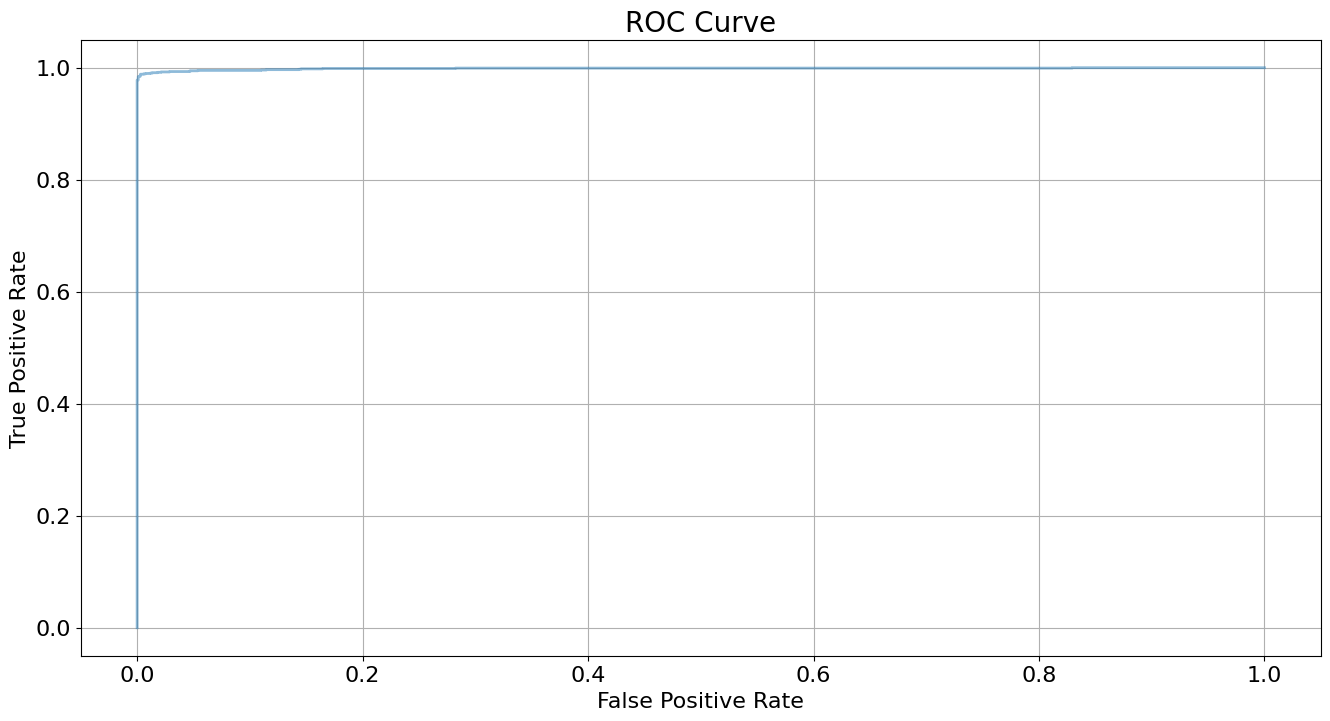

In [16]:
from catboost.utils import get_roc_curve
(fpr, tpr, thresholds) = get_roc_curve(model, holdout_data, plot=True)

In [25]:
features

['hotel_id',
 'city',
 'language',
 'mobile',
 'group',
 'brand',
 'parking',
 'pool',
 'children_policy',
 'stock',
 'date']

In [26]:
# Calcule les importances des features
feature_importances = model.get_feature_importance()

# Affiche les importances des features
for feature, importance in zip(features, feature_importances):
    print(feature, importance)

hotel_id 65.09497451277853
city 1.4863052016571403
language 1.29986315150875
mobile 0.37085020168739774
group 0.8861701989268215
brand 1.934012333195954
parking 0.45626191031076896
pool 0.1560482171301404
children_policy 0.24687382655738277
stock 5.267284559816658
date 22.801355886430454


In [27]:
params2 = dict(params)
params2.update({"ignored_features": ['hotel_id','stock','date']})#brand
model2 = CatBoostClassifier(**params2)
_ = model2.fit(train_data,eval_set=holdout_data)

Learning rate set to 0.165901
0:	test: 0.5836216	best: 0.5836216 (0)	total: 22.8ms	remaining: 2.25s
1:	test: 0.5979367	best: 0.5979367 (1)	total: 48.5ms	remaining: 2.37s
2:	test: 0.5993759	best: 0.5993759 (2)	total: 71.8ms	remaining: 2.32s
3:	test: 0.6003577	best: 0.6003577 (3)	total: 94.7ms	remaining: 2.27s
4:	test: 0.6227609	best: 0.6227609 (4)	total: 122ms	remaining: 2.32s
5:	test: 0.6314643	best: 0.6314643 (5)	total: 147ms	remaining: 2.31s
6:	test: 0.6654153	best: 0.6654153 (6)	total: 173ms	remaining: 2.3s
7:	test: 0.6815903	best: 0.6815903 (7)	total: 200ms	remaining: 2.3s
8:	test: 0.7018420	best: 0.7018420 (8)	total: 228ms	remaining: 2.31s
9:	test: 0.7096394	best: 0.7096394 (9)	total: 252ms	remaining: 2.26s
10:	test: 0.7132531	best: 0.7132531 (10)	total: 275ms	remaining: 2.22s
11:	test: 0.7180707	best: 0.7180707 (11)	total: 298ms	remaining: 2.19s
12:	test: 0.7226600	best: 0.7226600 (12)	total: 322ms	remaining: 2.15s
13:	test: 0.7257946	best: 0.7257946 (13)	total: 346ms	remaining: 

In [28]:
p = model2.predict(holdout_data)
p[p==0].shape

(829,)

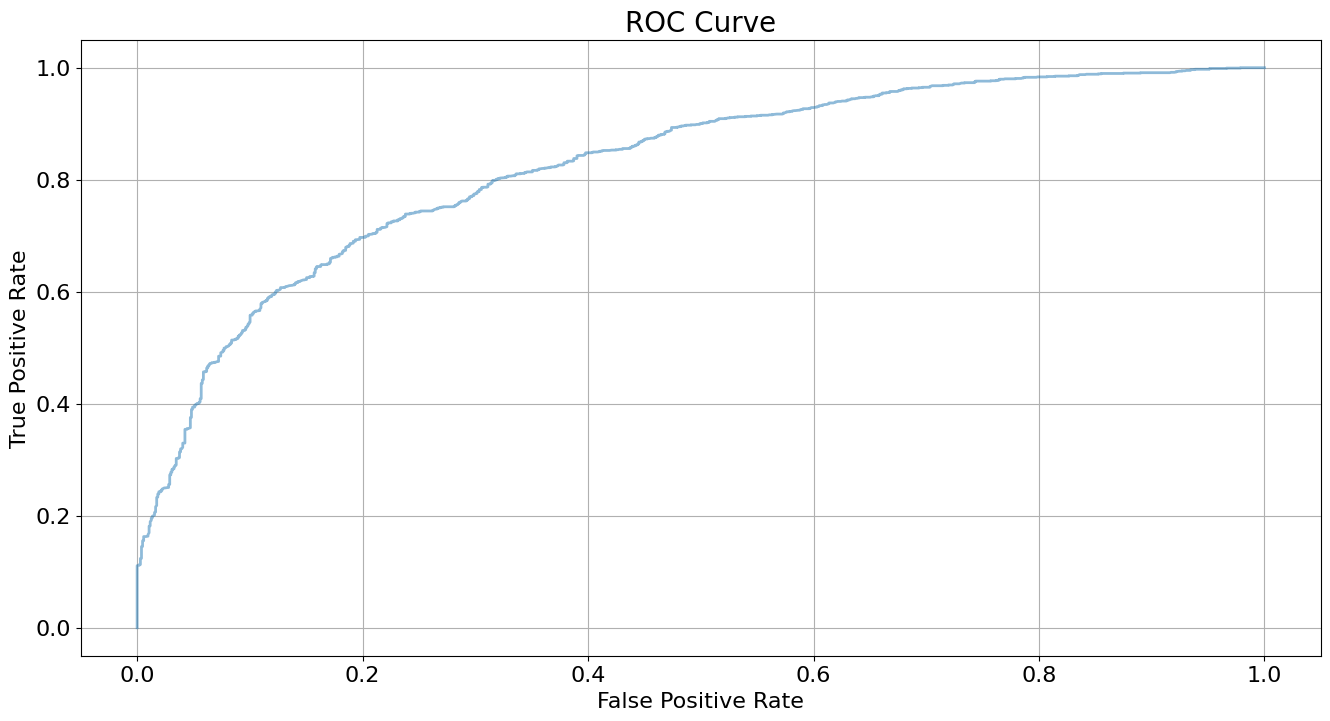

In [29]:
(fpr, tpr, thresholds) = get_roc_curve(model2, holdout_data, plot=True)

In [22]:
adversarial_test['predicted'] = p
test_t1p0 = adversarial_test[adversarial_test['target'] == 1 ]
test_t1p0 = test_t1p0[test_t1p0['predicted'] == 0]
#test_t1p0.to_csv('results_to_keep2.csv', index = False)

## Save data with good shape

In [37]:
nvx = pd.read_csv('results_to_keep2.csv')
print(nvx.drop(['target', 'predicted'],axis=1).columns)

Index(['hotel_id', 'city', 'language', 'mobile', 'group', 'brand', 'parking',
       'pool', 'children_policy', 'stock', 'date'],
      dtype='object')


In [36]:
nvx["city"]=pd.Categorical(nvx["city"],ordered=False)
nvx["language"]=pd.Categorical(nvx["language"],ordered=False)
nvx["mobile"]=pd.Categorical(nvx["mobile"],ordered=False)
nvx["hotel_id"]=pd.Categorical(nvx["hotel_id"],ordered=False)
nvx["group"]=pd.Categorical(nvx["group"],ordered=False)
nvx["brand"]=pd.Categorical(nvx["brand"],ordered=False)
nvx["parking"]=pd.Categorical(nvx["parking"],ordered=False)
nvx["pool"]=pd.Categorical(nvx["pool"],ordered=False)
nvx["children_policy"]=pd.Categorical(nvx["children_policy"],ordered=False)

In [38]:
# complete = data.loc[(data['hotel_id'] == nvx.drop(['target', 'predicted'],axis=1).iloc[0][0])
#                              & (data['city'] == nvx.drop(['target', 'predicted'],axis=1).iloc[0][1])
#                              & (data['language'] == nvx.drop(['target', 'predicted'],axis=1).iloc[0][2])
#                              & (data['mobile'] == nvx.drop(['target', 'predicted'],axis=1).iloc[0][3])
#                              & (data['group'] == nvx.drop(['target', 'predicted'],axis=1).iloc[0][4])
#                              & (data['brand'] == nvx.drop(['target', 'predicted'],axis=1).iloc[0][5])
#                              & (data['parking'] == nvx.drop(['target', 'predicted'],axis=1).iloc[0][6])
#                              & (data['pool'] == nvx.drop(['target', 'predicted'],axis=1).iloc[0][7])
#                              & (data['children_policy'] == nvx.drop(['target', 'predicted'],axis=1).iloc[0][8])
#                              & (data['stock'] == nvx.drop(['target', 'predicted'],axis=1).iloc[0][9])
#                              & (data['date'] == nvx.drop(['target', 'predicted'],axis=1).iloc[0][10])]

In [39]:
for i in range(1,len(nvx)):
    complete = pd.concat([complete ,
                         data.loc[(data['hotel_id'] == nvx.drop(['target', 'predicted'],axis=1).iloc[i][0])
                                 & (data['city'] == nvx.drop(['target', 'predicted'],axis=1).iloc[i][1])
                                 & (data['language'] == nvx.drop(['target', 'predicted'],axis=1).iloc[i][2])
                                 & (data['mobile'] == nvx.drop(['target', 'predicted'],axis=1).iloc[i][3])
                                 & (data['group'] == nvx.drop(['target', 'predicted'],axis=1).iloc[i][4])
                                 & (data['brand'] == nvx.drop(['target', 'predicted'],axis=1).iloc[i][5])
                                 & (data['parking'] == nvx.drop(['target', 'predicted'],axis=1).iloc[i][6])
                                 & (data['pool'] == nvx.drop(['target', 'predicted'],axis=1).iloc[i][7])
                                 & (data['children_policy'] == nvx.drop(['target', 'predicted'],axis=1).iloc[i][8])
                                 & (data['stock'] == nvx.drop(['target', 'predicted'],axis=1).iloc[i][9])
                                 & (data['date'] == nvx.drop(['target', 'predicted'],axis=1).iloc[i][10])]] )
   

In [41]:
#complete.to_csv('results_complete_to_keep2.csv', index = False)